In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
#which X?? max could do overfitting


In [5]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [7]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [40]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [9]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

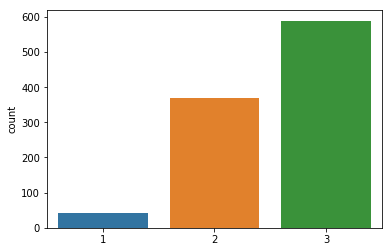

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


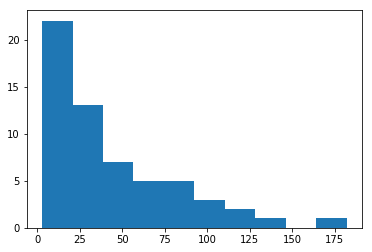

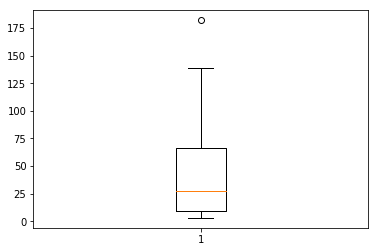

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [10]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [20]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Trained IDeal Model, Epochs to converge = 6


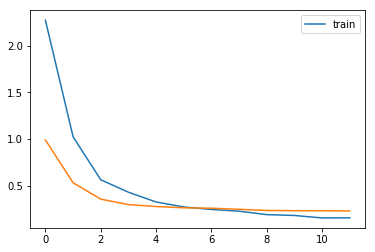

In [42]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [14]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.614331819028
2 	 -2762.646205813235 	0.0214	0.065072	0.026419
3 	 -2736.6331912176543 	0.0117	0.059334	0.009416
4 	 -2725.378102461501 	0.0071	0.058779	0.004113
5 	 -2719.697361647746 	0.0041	0.051646	0.002084
6 	 -2716.566652090635 	0.0027	0.040519	0.001151
7 	 -2714.7759730273488 	0.0021	0.031279	0.000659
8 	 -2713.6296358271984 	0.0017	0.024918	0.000422
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [106]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Trained model over soft-MV, Epochs to converge = 7


In [107]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

Trained model over hard-MV, Epochs to converge = 13


In [22]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

Trained model over D&S, Epochs to converge = 7


### Raykar Model (joint predict model)

In [11]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [10]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 2.03 sec)	logL: -3050.267	
Iter 2/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2642.405	Tol1: 0.13371	Tol2: 0.11462	
Iter 3/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -2496.312	Tol1: 0.05529	Tol2: 0.03931	
Iter 4/50 
M step: done,  E step: done //  (in 0.09 sec)	logL: -2418.961	Tol1: 0.03099	Tol2: 0.03050	
Iter 5/50 
M step: done,  E step: done //  (in 0.09 sec)	logL: -2368.606	Tol1: 0.02082	Tol2: 0.02815	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.00 sec)	logL: -3101.287	
Iter 2/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -2632.131	Tol1: 0.15128	Tol2: 0.08797	
Iter 3/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -2460.404	Tol1: 0.06524	Tol2: 0.04151	
Iter 4/50 
M step: done,  E 

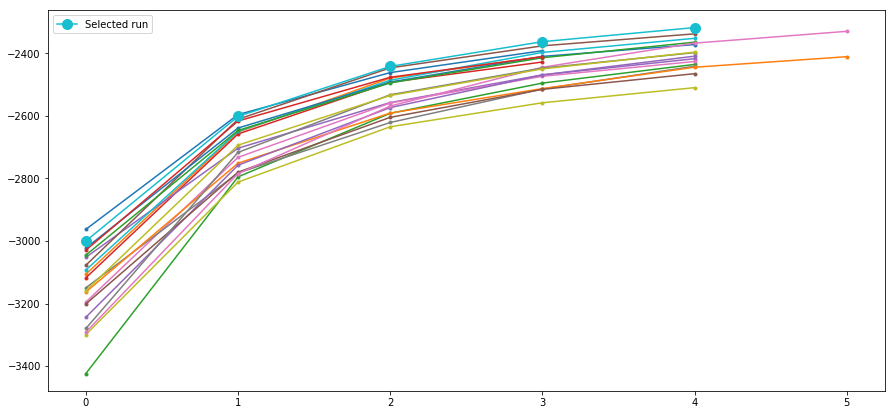

In [67]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [12]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


In [35]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [13]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(2,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean JS"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004658 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0091215 0.6219893]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3564.028	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2201.859	Tol1: 0.38220	Tol2: 0.95869	Tol3: 0.49993	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1884.407	Tol1: 0.14417	Tol2: 0.20752	Tol3: 0.06585	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1756.566	Tol1: 0.06784	Tol2: 0.15221	Tol3: 0.14541	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1700.558	Tol1: 0.03188	Tol2: 0.08429	Tol3: 0.19216	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1654.501	Tol1: 0.02708	Tol2: 0.05270	Tol3: 0.21178	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5356109 0.5179755]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3868.809	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2473.638	Tol1: 0.36062	Tol2: 0.66524	Tol3: 0.11081	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2209.356	Tol1: 0.10684	Tol2: 0.17421	Tol3: 0.18443	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2104.941	Tol1: 0.04726	Tol2: 0.11517	Tol3: 0.19241	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2021.882	Tol1: 0.03946	Tol2: 0.08400	Tol3: 0.19706	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1946.990	Tol1: 0.03704	Tol2: 0.04855	Tol3: 0.20977	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.159	Tol1: 0.02868	Tol2: 0.03808	Tol3: 0.21870	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1851.248	Tol1:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.534	Tol1: 0.02846	Tol2: 0.02993	Tol3: 0.25338	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51297605 0.8223143 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3402.604	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2339.232	Tol1: 0.31252	Tol2: 0.38369	Tol3: 0.12143	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2055.310	Tol1: 0.12137	Tol2: 0.14816	Tol3: 0.19318	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1928.697	Tol1: 0.06160	Tol2: 0.10097	Tol3: 0.21626	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.566	Tol1: 0.05192	Tol2: 0.06270	Tol3: 0.23092	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.327	Tol1: 0.04333	Tol2: 0.04208	Tol3: 0.24298	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.562	Tol1: 0.02174	Tol2: 0.03870	Tol3: 0.24029	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1633.705	Tol1: 0.01913	Tol2: 0.02453	Tol3: 0.24433	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78851324 0.0460243 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2900.618	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2137.264	Tol1: 0.26317	Tol2: 0.32995	Tol3: 0.06323	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1930.741	Tol1: 0.09663	Tol2: 0.12681	Tol3: 0.19003	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1813.309	Tol1: 0.06082	Tol2: 0.07498	Tol3: 0.21276	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1752.278	Tol1: 0.03366	Tol2: 0.05202	Tol3: 0.22619	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.403	Tol1: 0.03927	Tol2: 0.06241	Tol3: 0.22872	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.138	Tol1: 0.02308	Tol2: 0.03858	Tol3: 0.23634	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.725	Tol1: 0.02191	Tol2: 0.02330	Tol3: 0.23981	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9216456  0.19058685]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2910.467	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2158.005	Tol1: 0.25854	Tol2: 0.29217	Tol3: 0.09273	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.308	Tol1: 0.09115	Tol2: 0.12892	Tol3: 0.20467	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.978	Tol1: 0.05064	Tol2: 0.06832	Tol3: 0.20851	
Iter 5/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.446	Tol1: 0.03906	Tol2: 0.02139	Tol3: 0.25071	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1596.468	Tol1: 0.03271	Tol2: 0.02289	Tol3: 0.24763	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.377	Tol1: 0.02699	Tol2: 0.02224	Tol3: 0.24904	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.55
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003562 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40090644 0.2603973 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3357.525	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2336.083	Tol1: 0.30422	Tol2: 0.63277	Tol3: 0.34194	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2065.236	Tol1:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1872.751	Tol1: 0.04747	Tol2: 0.08224	Tol3: 0.20708	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1803.298	Tol1: 0.03709	Tol2: 0.05958	Tol3: 0.22229	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.059	Tol1: 0.03784	Tol2: 0.03773	Tol3: 0.23825	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.662	Tol1: 0.03423	Tol2: 0.03463	Tol3: 0.25061	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.444	Tol1: 0.02698	Tol2: 0.02986	Tol3: 0.25662	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15535583 0.0272579 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2828.451	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1984.474	Tol1: 0.29839	Tol2: 0.50800	Tol3: 0.06855	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.188	Tol1: 0.03232	Tol2: 0.05185	Tol3: 0.21997	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.793	Tol1: 0.02913	Tol2: 0.04270	Tol3: 0.23162	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.702	Tol1: 0.01915	Tol2: 0.03474	Tol3: 0.23860	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1721.468	Tol1: 0.01388	Tol2: 0.02044	Tol3: 0.23812	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23223688 0.99860466]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3140.538	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2127.155	Tol1: 0.32268	Tol2: 0.49793	Tol3: 0.10083	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1957.091	Tol1: 0.07995	Tol2: 0.14941	Tol3: 0.15349	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.950	Tol1: 0.05099	Tol2: 0.10293	Tol3: 0.18657	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.990	Tol1: 0.04111	Tol2: 0.07428	Tol3: 0.20443	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.969	Tol1: 0.02494	Tol2: 0.04710	Tol3: 0.21840	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.199	Tol1: 0.01948	Tol2: 0.02969	Tol3: 0.22982	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1403186  0.97429234]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2980.356	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2134.544	Tol1: 0.28380	Tol2: 0.53503	Tol3: 0.17298	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.263	Tol1: 0.10367	Tol2: 0.14529	Tol3: 0.12946	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -2093.535	Tol1: 0.10963	Tol2: 0.12632	Tol3: 0.16805	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.956	Tol1: 0.06333	Tol2: 0.09447	Tol3: 0.20875	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.402	Tol1: 0.04414	Tol2: 0.06454	Tol3: 0.22261	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1809.606	Tol1: 0.03457	Tol2: 0.05208	Tol3: 0.23462	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1755.120	Tol1: 0.03011	Tol2: 0.02597	Tol3: 0.23750	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.682	Tol1: 0.02817	Tol2: 0.02587	Tol3: 0.24233	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.562004  0.7989997]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2941.883	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.50 sec)	logL: -3003.279	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2180.778	Tol1: 0.27387	Tol2: 0.30094	Tol3: 0.09644	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1953.235	Tol1: 0.10434	Tol2: 0.11833	Tol3: 0.21420	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1847.272	Tol1: 0.05425	Tol2: 0.07745	Tol3: 0.22710	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.344	Tol1: 0.04110	Tol2: 0.05219	Tol3: 0.23729	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1708.978	Tol1: 0.03521	Tol2: 0.03403	Tol3: 0.24484	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.212	Tol1: 0.02736	Tol2: 0.02928	Tol3: 0.25069	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.6
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003428 mins
Initializing new EM...
Pre-train n

M step: done,  E step: done //  (in 0.51 sec)	logL: -3182.200	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -2059.272	Tol1: 0.35288	Tol2: 0.33572	Tol3: 0.05490	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.422	Tol1: 0.10967	Tol2: 0.14512	Tol3: 0.21818	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.805	Tol1: 0.05161	Tol2: 0.09229	Tol3: 0.21590	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1684.824	Tol1: 0.03105	Tol2: 0.05847	Tol3: 0.22375	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.164	Tol1: 0.01879	Tol2: 0.03590	Tol3: 0.23412	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1622.838	Tol1: 0.01834	Tol2: 0.01774	Tol3: 0.24260	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73209995 0.26502717]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -2131.635	Tol1: 0.32602	Tol2: 0.30852	Tol3: 0.02640	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.538	Tol1: 0.09856	Tol2: 0.12522	Tol3: 0.21020	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.194	Tol1: 0.04858	Tol2: 0.07135	Tol3: 0.20977	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.595	Tol1: 0.03205	Tol2: 0.05265	Tol3: 0.21751	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.608	Tol1: 0.02825	Tol2: 0.03904	Tol3: 0.22513	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.119	Tol1: 0.02238	Tol2: 0.02409	Tol3: 0.23129	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97901064 0.8321148 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2738.375	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -2099.363	Tol1: 0.26888	Tol2: 0.30791	Tol3: 0.08007	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.420	Tol1: 0.10096	Tol2: 0.11299	Tol3: 0.20348	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1773.139	Tol1: 0.06055	Tol2: 0.07961	Tol3: 0.21065	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.491	Tol1: 0.03702	Tol2: 0.05078	Tol3: 0.22070	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.794	Tol1: 0.02735	Tol2: 0.02994	Tol3: 0.22666	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.91566235 0.5909912 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2786.757	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2086.001	Tol1: 0.25146	Tol2: 0.29060	Tol3: 0.09991	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.412	Tol1: 0.04274	Tol2: 0.02983	Tol3: 0.24329	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.798	Tol1: 0.02807	Tol2: 0.02916	Tol3: 0.24781	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8154009  0.05091608]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2603.083	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2001.928	Tol1: 0.23094	Tol2: 0.26717	Tol3: 0.14683	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.034	Tol1: 0.07637	Tol2: 0.12164	Tol3: 0.21893	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.917	Tol1: 0.04549	Tol2: 0.06726	Tol3: 0.23293	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.481	Tol1: 0.03254	Tol2: 0.03994	Tol3: 0.24904	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.904	Tol1: 0.04183	Tol2: 0.04928	Tol3: 0.24478	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.921	Tol1: 0.03147	Tol2: 0.03935	Tol3: 0.25678	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.727	Tol1: 0.02435	Tol2: 0.02415	Tol3: 0.26248	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.3
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003505 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21649925 0.43417045]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3481.321	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2238.882	Tol1: 0.35689	Tol2: 0.82283	Tol3: 0.39201	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1996.314	Tol1: 0

M step: done,  E step: done //  (in 0.58 sec)	logL: -2900.372	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2135.469	Tol1: 0.26373	Tol2: 0.34240	Tol3: 0.04136	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1949.305	Tol1: 0.08718	Tol2: 0.11581	Tol3: 0.20636	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.916	Tol1: 0.04945	Tol2: 0.07538	Tol3: 0.21991	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1775.840	Tol1: 0.04160	Tol2: 0.04979	Tol3: 0.23301	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -1718.305	Tol1: 0.03240	Tol2: 0.03610	Tol3: 0.24735	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1668.556	Tol1: 0.02895	Tol2: 0.02241	Tol3: 0.25165	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9267052  0.71927035]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.354	Tol1: 0.05406	Tol2: 0.08056	Tol3: 0.20824	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.478	Tol1: 0.02694	Tol2: 0.06125	Tol3: 0.22276	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.869	Tol1: 0.02290	Tol2: 0.04347	Tol3: 0.23743	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.815	Tol1: 0.02074	Tol2: 0.02563	Tol3: 0.24976	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14432688 0.5461325 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3592.470	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2232.876	Tol1: 0.37846	Tol2: 0.72266	Tol3: 0.28357	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1962.306	Tol1: 0.12118	Tol2: 0.16104	Tol3: 0.17864	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -1737.744	Tol1: 0.06264	Tol2: 0.12862	Tol3: 0.17741	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1679.952	Tol1: 0.03326	Tol2: 0.06547	Tol3: 0.21190	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1645.400	Tol1: 0.02057	Tol2: 0.03711	Tol3: 0.23062	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.885	Tol1: 0.01915	Tol2: 0.03310	Tol3: 0.24177	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.675	Tol1: 0.02306	Tol2: 0.02307	Tol3: 0.25121	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37354833 0.2648777 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3536.054	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2201.135	Tol1: 0.37752	Tol2: 0.43017	Tol3: 0.06219	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.09 sec)	logL: -1788.354	Tol1: 0.03799	Tol2: 0.07772	Tol3: 0.23500	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1732.691	Tol1: 0.03112	Tol2: 0.05827	Tol3: 0.23518	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.932	Tol1: 0.03276	Tol2: 0.03559	Tol3: 0.24310	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1639.208	Tol1: 0.02191	Tol2: 0.02689	Tol3: 0.25211	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.67985946 0.88984054]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2928.055	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2096.133	Tol1: 0.28412	Tol2: 0.33367	Tol3: 0.04880	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1867.866	Tol1: 0.10890	Tol2: 0.13370	Tol3: 0.21435	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.452	Tol1: 0.02344	Tol2: 0.02162	Tol3: 0.22021	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.3
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003766 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05750681 0.94500494]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3269.299	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2147.169	Tol1: 0.34323	Tol2: 0.55338	Tol3: 0.13174	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.311	Tol1: 0.12056	Tol2: 0.16125	Tol3: 0.14418	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.335	Tol1: 0.06724	Tol2: 0.10276	Tol3: 0.18158	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.648	Tol1: 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2214.945	Tol1: 0.13482	Tol2: 0.17571	Tol3: 0.11058	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2058.973	Tol1: 0.07042	Tol2: 0.11446	Tol3: 0.20050	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.010	Tol1: 0.05486	Tol2: 0.07641	Tol3: 0.21929	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1866.773	Tol1: 0.04072	Tol2: 0.05260	Tol3: 0.23261	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.273	Tol1: 0.03830	Tol2: 0.03819	Tol3: 0.23746	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1739.144	Tol1: 0.03126	Tol2: 0.02670	Tol3: 0.23782	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.751	Tol1: 0.03070	Tol2: 0.02804	Tol3: 0.23544	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1649.208	Tol1: 0.02168	Tol2: 0.02283	Tol3: 0.23839	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.74672484 0.02053793]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2983.432	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2201.715	Tol1: 0.26202	Tol2: 0.37974	Tol3: 0.02303	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1991.623	Tol1: 0.09542	Tol2: 0.13290	Tol3: 0.19069	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.319	Tol1: 0.06241	Tol2: 0.09607	Tol3: 0.20865	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.124	Tol1: 0.03920	Tol2: 0.06555	Tol3: 0.21955	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.272	Tol1: 0.02667	Tol2: 0.04216	Tol3: 0.23480	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.720	Tol1: 0.02895	Tol2: 0.03257	Tol3: 0.24095	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.014	Tol

M step: done,  E step: done //  (in 0.07 sec)	logL: -1836.841	Tol1: 0.04263	Tol2: 0.02977	Tol3: 0.23274	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1759.431	Tol1: 0.04214	Tol2: 0.02785	Tol3: 0.24075	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1697.444	Tol1: 0.03523	Tol2: 0.02558	Tol3: 0.24463	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1653.809	Tol1: 0.02571	Tol2: 0.02670	Tol3: 0.24413	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6906638  0.35500997]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3694.498	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2341.686	Tol1: 0.36617	Tol2: 0.48360	Tol3: 0.10392	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1984.142	Tol1: 0.15269	Tol2: 0.14410	Tol3: 0.19904	
Iter 4/50
M step: done,  E step: done //  

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23830718 0.869593  ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3422.032	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2229.292	Tol1: 0.34855	Tol2: 0.66365	Tol3: 0.32229	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1967.328	Tol1: 0.11751	Tol2: 0.18352	Tol3: 0.16700	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1847.318	Tol1: 0.06100	Tol2: 0.10051	Tol3: 0.19446	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1776.511	Tol1: 0.03833	Tol2: 0.06930	Tol3: 0.21805	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.010	Tol1: 0.03349	Tol2: 0.04438	Tol3: 0.23588	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1670.203	Tol1: 0.02726	Tol2: 0.03393	Tol3: 0.24980	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1630.357	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.616	Tol1: 0.02680	Tol2: 0.05527	Tol3: 0.21775	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.106	Tol1: 0.03011	Tol2: 0.03497	Tol3: 0.22857	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.140	Tol1: 0.01987	Tol2: 0.02935	Tol3: 0.23596	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7784542 0.5529778]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3260.141	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2295.226	Tol1: 0.29597	Tol2: 0.40943	Tol3: 0.00316	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2014.161	Tol1: 0.12246	Tol2: 0.15366	Tol3: 0.21164	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.251	Tol1: 0.06251	Tol2: 0.09508	Tol3: 0.22346	
Iter 5/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.55 sec)	logL: -3741.286	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2289.112	Tol1: 0.38815	Tol2: 0.68152	Tol3: 0.48280	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2029.668	Tol1: 0.11334	Tol2: 0.15511	Tol3: 0.20357	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.544	Tol1: 0.07052	Tol2: 0.11583	Tol3: 0.23595	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.854	Tol1: 0.04754	Tol2: 0.08036	Tol3: 0.25640	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.068	Tol1: 0.04162	Tol2: 0.05806	Tol3: 0.28326	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.924	Tol1: 0.02796	Tol2: 0.04717	Tol3: 0.30162	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.712	Tol1: 0.01745	Tol2: 0.03621	Tol3: 0.31077	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1616.094	Tol1: 0.01740	Tol2: 0.02392	Tol3: 0.31733	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.733	Tol1: 0.03353	Tol2: 0.03815	Tol3: 0.30475	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.461	Tol1: 0.01756	Tol2: 0.03124	Tol3: 0.31301	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.414	Tol1: 0.01833	Tol2: 0.02157	Tol3: 0.31468	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94509804 0.21497642 0.21182461]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3169.730	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2123.239	Tol1: 0.33015	Tol2: 0.36472	Tol3: 0.03882	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1915.891	Tol1: 0.09766	Tol2: 0.15138	Tol3: 0.28076	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.963	Tol1: 0.05633	Tol2: 0.08133	Tol3: 0.28374	
Iter 5/50
M step: done,  E step:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9188228 0.5621505 0.5114062]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2891.103	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2164.653	Tol1: 0.25127	Tol2: 0.39913	Tol3: 0.04612	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1965.467	Tol1: 0.09202	Tol2: 0.14140	Tol3: 0.24779	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.776	Tol1: 0.05530	Tol2: 0.10121	Tol3: 0.28060	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.375	Tol1: 0.03415	Tol2: 0.05834	Tol3: 0.30145	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.829	Tol1: 0.02484	Tol2: 0.03855	Tol3: 0.31566	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.600	Tol1: 0.02129	Tol2: 0.02416	Tol3: 0.32156	
Finished training!
Initializing new EM...
Pre-train network on 0 ep

M step: done,  E step: done //  (in 0.61 sec)	logL: -3145.687	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2152.286	Tol1: 0.31580	Tol2: 0.32607	Tol3: 0.07645	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1865.857	Tol1: 0.13308	Tol2: 0.13504	Tol3: 0.23506	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1758.831	Tol1: 0.05736	Tol2: 0.09904	Tol3: 0.28626	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.135	Tol1: 0.03792	Tol2: 0.07067	Tol3: 0.29763	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.808	Tol1: 0.02206	Tol2: 0.04128	Tol3: 0.30868	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1617.617	Tol1: 0.02247	Tol2: 0.02706	Tol3: 0.31835	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6089132  0.56533617 0.11455119]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.62 sec)	logL: -2620.318	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1963.266	Tol1: 0.25075	Tol2: 0.32250	Tol3: 0.12761	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1818.671	Tol1: 0.07365	Tol2: 0.12847	Tol3: 0.24801	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.590	Tol1: 0.03963	Tol2: 0.06850	Tol3: 0.26578	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1690.758	Tol1: 0.03197	Tol2: 0.05048	Tol3: 0.28405	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.234	Tol1: 0.02101	Tol2: 0.03272	Tol3: 0.30482	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.445	Tol1: 0.02041	Tol2: 0.02020	Tol3: 0.31511	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5846285  0.69232666 0.07859411]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1695.256	Tol1: 0.03160	Tol2: 0.02631	Tol3: 0.31454	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.099	Tol1: 0.02369	Tol2: 0.02044	Tol3: 0.31848	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22437437 0.3746842  0.15690355]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3531.697	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2180.232	Tol1: 0.38267	Tol2: 0.53802	Tol3: 0.24340	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1871.986	Tol1: 0.14138	Tol2: 0.18736	Tol3: 0.23710	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.877	Tol1: 0.05935	Tol2: 0.12187	Tol3: 0.24759	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.759	Tol1: 0.03301	Tol2: 0.07428	Tol3: 0.27956	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.172	Tol1: 0.04199	Tol2: 0.05917	Tol3: 0.26231	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1689.423	Tol1: 0.02637	Tol2: 0.04303	Tol3: 0.29460	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.965	Tol1: 0.02454	Tol2: 0.03201	Tol3: 0.31251	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.310	Tol1: 0.02406	Tol2: 0.02678	Tol3: 0.32812	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16489843 0.54474556 0.38301957]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3315.269	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2134.858	Tol1: 0.35605	Tol2: 0.50269	Tol3: 0.13365	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1889.194	Tol1: 0.11507	Tol2: 0.15735	Tol3: 0.20474	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.576	Tol1: 0.03858	Tol2: 0.05591	Tol3: 0.30457	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1702.675	Tol1: 0.03344	Tol2: 0.03730	Tol3: 0.31772	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.258	Tol1: 0.02256	Tol2: 0.02778	Tol3: 0.33174	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.55
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.004418 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5605846  0.12412357 0.89356536]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2838.088	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2099.182	Tol1: 0.26035	Tol2: 0.40042	Tol3: 0.01389	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1903

M step: done,  E step: done //  (in 0.06 sec)	logL: -1965.334	Tol1: 0.11544	Tol2: 0.14055	Tol3: 0.19974	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1856.522	Tol1: 0.05537	Tol2: 0.11296	Tol3: 0.24159	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.950	Tol1: 0.03801	Tol2: 0.06930	Tol3: 0.25186	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.318	Tol1: 0.04123	Tol2: 0.04958	Tol3: 0.26922	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.130	Tol1: 0.03398	Tol2: 0.03944	Tol3: 0.28747	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.097	Tol1: 0.01997	Tol2: 0.02937	Tol3: 0.30422	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9514719  0.533146   0.19775438]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2756.655	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1527.470	Tol1: 0.01669	Tol2: 0.02436	Tol3: 0.31683	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1348664  0.21383703 0.02393817]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3772.805	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2387.965	Tol1: 0.36706	Tol2: 0.74200	Tol3: 0.39874	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2014.245	Tol1: 0.15650	Tol2: 0.16660	Tol3: 0.20230	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1858.509	Tol1: 0.07732	Tol2: 0.13805	Tol3: 0.27327	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1778.349	Tol1: 0.04313	Tol2: 0.09347	Tol3: 0.29112	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.831	Tol1: 0.04190	Tol2: 0.06624	Tol3: 0.30856	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1956.857	Tol1: 0.11123	Tol2: 0.14246	Tol3: 0.23373	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1850.372	Tol1: 0.05442	Tol2: 0.09079	Tol3: 0.27377	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.402	Tol1: 0.03673	Tol2: 0.05871	Tol3: 0.29764	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.279	Tol1: 0.02251	Tol2: 0.04139	Tol3: 0.31748	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.634	Tol1: 0.02562	Tol2: 0.02803	Tol3: 0.32345	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35266688 0.981205   0.11942922]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3143.693	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2142.416	Tol1: 0.31850	Tol2: 0.42472	Tol3: 0.01877	
Iter 3/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.49 sec)	logL: -2788.107	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.327	Tol1: 0.26856	Tol2: 0.30442	Tol3: 0.16627	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.334	Tol1: 0.08140	Tol2: 0.12173	Tol3: 0.27257	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.830	Tol1: 0.04404	Tol2: 0.07560	Tol3: 0.27783	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.988	Tol1: 0.03453	Tol2: 0.04793	Tol3: 0.28543	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.175	Tol1: 0.02187	Tol2: 0.03256	Tol3: 0.30543	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.718	Tol1: 0.02156	Tol2: 0.02121	Tol3: 0.31954	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33323613 0.06413035 0.52846605]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.296	Tol1: 0.02583	Tol2: 0.04407	Tol3: 0.29915	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.388	Tol1: 0.02389	Tol2: 0.03030	Tol3: 0.31747	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.713	Tol1: 0.02374	Tol2: 0.02255	Tol3: 0.33525	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6324817  0.25787812 0.8817039 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3104.804	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2181.274	Tol1: 0.29745	Tol2: 0.33912	Tol3: 0.06800	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1963.215	Tol1: 0.09997	Tol2: 0.12626	Tol3: 0.23533	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1862.032	Tol1: 0.05154	Tol2: 0.09082	Tol3: 0.25779	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -2251.003	Tol1: 0.36468	Tol2: 0.77111	Tol3: 0.57980	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1980.344	Tol1: 0.12024	Tol2: 0.16984	Tol3: 0.12826	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1866.766	Tol1: 0.05735	Tol2: 0.13153	Tol3: 0.20439	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1794.329	Tol1: 0.03880	Tol2: 0.08386	Tol3: 0.23585	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1736.542	Tol1: 0.03221	Tol2: 0.06678	Tol3: 0.25654	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.481	Tol1: 0.02480	Tol2: 0.05847	Tol3: 0.28167	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.843	Tol1: 0.02813	Tol2: 0.03995	Tol3: 0.29801	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.837	Tol1: 0.02309	Tol2: 0.02547	Tol3: 0.30920	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.345	Tol1: 0.06122	Tol2: 0.08501	Tol3: 0.29437	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.744	Tol1: 0.04110	Tol2: 0.05421	Tol3: 0.32236	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.762	Tol1: 0.03004	Tol2: 0.03694	Tol3: 0.33593	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.466	Tol1: 0.03408	Tol2: 0.02112	Tol3: 0.34376	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1606.953	Tol1: 0.02754	Tol2: 0.01756	Tol3: 0.34720	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51147825 0.37611482 0.46183023]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2871.802	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2174.531	Tol1: 0.24280	Tol2: 0.42867	Tol3: 0.06622	
Iter 3/50
M step: done,  E step:

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003550 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5328366  0.08178351 0.12041065]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2971.179	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2146.294	Tol1: 0.27763	Tol2: 0.39446	Tol3: 0.05889	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.410	Tol1: 0.08661	Tol2: 0.11387	Tol3: 0.26329	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.348	Tol1: 0.06022	Tol2: 0.09904	Tol3: 0.27554	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.058	Tol1: 0.03544	Tol2: 0.05213	Tol3: 0.29074	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.300	Tol1: 0.03306	Tol2: 0.03321	Tol3: 0.30370	
Iter 7/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.987	Tol1: 0.03432	Tol2: 0.05813	Tol3: 0.26865	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.067	Tol1: 0.02709	Tol2: 0.04834	Tol3: 0.28709	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.358	Tol1: 0.02060	Tol2: 0.03879	Tol3: 0.30169	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.290	Tol1: 0.01640	Tol2: 0.02495	Tol3: 0.31361	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05056012 0.71365577 0.15858786]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3013.883	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.153	Tol1: 0.28293	Tol2: 0.51330	Tol3: 0.10817	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1913.489	Tol1: 0.11460	Tol2: 0.13935	Tol3: 0.17211	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.54 sec)	logL: -3165.508	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2286.029	Tol1: 0.27783	Tol2: 0.42764	Tol3: 0.13546	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2000.735	Tol1: 0.12480	Tol2: 0.14223	Tol3: 0.17984	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.415	Tol1: 0.06114	Tol2: 0.11094	Tol3: 0.24802	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.193	Tol1: 0.04271	Tol2: 0.06359	Tol3: 0.27631	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1734.701	Tol1: 0.03531	Tol2: 0.05026	Tol3: 0.29312	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1684.103	Tol1: 0.02917	Tol2: 0.03507	Tol3: 0.31156	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.452	Tol1: 0.02414	Tol2: 0.02872	Tol3: 0.32442	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8181899  0.88623387 0.9371658 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.307	Tol1: 0.02170	Tol2: 0.05218	Tol3: 0.27894	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.592	Tol1: 0.02215	Tol2: 0.03896	Tol3: 0.30047	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.769	Tol1: 0.01765	Tol2: 0.02813	Tol3: 0.31435	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36289698 0.60015017 0.5121305 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3727.645	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2256.375	Tol1: 0.39469	Tol2: 0.48443	Tol3: 0.22976	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.914	Tol1: 0.14734	Tol2: 0.15439	Tol3: 0.24764	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.995	Tol1: 0.05246	Tol2: 0.11522	Tol3: 0.27983	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2181.919	Tol1: 0.34692	Tol2: 0.44937	Tol3: 0.24065	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.306	Tol1: 0.10936	Tol2: 0.16589	Tol3: 0.22565	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.411	Tol1: 0.04986	Tol2: 0.09922	Tol3: 0.25644	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.843	Tol1: 0.04472	Tol2: 0.07490	Tol3: 0.27452	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.798	Tol1: 0.03177	Tol2: 0.05959	Tol3: 0.30269	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.979	Tol1: 0.02332	Tol2: 0.03697	Tol3: 0.32255	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.794	Tol1: 0.02409	Tol2: 0.02727	Tol3: 0.33069	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6194078  0.28438604 0.21880265]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.547	Tol1: 0.02372	Tol2: 0.03279	Tol3: 0.32695	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.824	Tol1: 0.01896	Tol2: 0.02063	Tol3: 0.33414	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3940499  0.00419529 0.23123074]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3459.396	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2333.514	Tol1: 0.32546	Tol2: 0.50689	Tol3: 0.11677	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2032.145	Tol1: 0.12915	Tol2: 0.12886	Tol3: 0.22625	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1887.759	Tol1: 0.07105	Tol2: 0.10181	Tol3: 0.26553	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1788.157	Tol1: 0.05276	Tol2: 0.07153	Tol3: 0.28044	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.321	Tol1: 0.02126	Tol2: 0.02758	Tol3: 0.33179	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4096161  0.6709745  0.53461605]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3149.043	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2203.885	Tol1: 0.30014	Tol2: 0.42895	Tol3: 0.15164	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1951.046	Tol1: 0.11472	Tol2: 0.13950	Tol3: 0.17980	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.301	Tol1: 0.05932	Tol2: 0.11386	Tol3: 0.23265	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.322	Tol1: 0.03323	Tol2: 0.06566	Tol3: 0.26091	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.348	Tol1: 0.03324	Tol2: 0.04440	Tol3: 0.27931	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1811.474	Tol1: 0.04850	Tol2: 0.08128	Tol3: 0.28486	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.367	Tol1: 0.02490	Tol2: 0.04748	Tol3: 0.28675	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.510	Tol1: 0.01804	Tol2: 0.03495	Tol3: 0.29383	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.435	Tol1: 0.02022	Tol2: 0.02384	Tol3: 0.30206	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31661424 0.9745757  0.41057953]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3056.314	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2131.965	Tol1: 0.30244	Tol2: 0.40512	Tol3: 0.06633	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1905.989	Tol1: 0.10599	Tol2: 0.13111	Tol3: 0.24641	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.852	Tol1: 0.03114	Tol2: 0.02428	Tol3: 0.31388	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.420	Tol1: 0.02616	Tol2: 0.02042	Tol3: 0.32059	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.1
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003473 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7699488 0.9620974 0.8366402]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2915.804	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2140.170	Tol1: 0.26601	Tol2: 0.30935	Tol3: 0.03228	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1899.416	Tol1: 0.11249	Tol2: 0.13033	Tol3: 0.23486	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1780.012

M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.912	Tol1: 0.26371	Tol2: 0.31287	Tol3: 0.10068	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1793.772	Tol1: 0.08710	Tol2: 0.14900	Tol3: 0.25923	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1711.307	Tol1: 0.04597	Tol2: 0.07952	Tol3: 0.26667	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.649	Tol1: 0.01616	Tol2: 0.05077	Tol3: 0.29519	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.359	Tol1: 0.02452	Tol2: 0.03993	Tol3: 0.30589	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.525	Tol1: 0.02060	Tol2: 0.02174	Tol3: 0.31921	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6911974  0.9363185  0.70131075]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3437.820	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.162	Tol1: 0.02501	Tol2: 0.02898	Tol3: 0.30110	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06152368 0.5684296  0.66787636]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3474.443	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2233.747	Tol1: 0.35709	Tol2: 0.71649	Tol3: 0.58814	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.517	Tol1: 0.14605	Tol2: 0.18585	Tol3: 0.11536	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1776.723	Tol1: 0.06857	Tol2: 0.14852	Tol3: 0.21310	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1712.848	Tol1: 0.03595	Tol2: 0.09676	Tol3: 0.24101	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.633	Tol1: 0.02523	Tol2: 0.06944	Tol3: 0.26260	
Iter 7/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.450	Tol1: 0.03101	Tol2: 0.05210	Tol3: 0.30001	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1657.502	Tol1: 0.02811	Tol2: 0.04785	Tol3: 0.31408	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1625.846	Tol1: 0.01910	Tol2: 0.04264	Tol3: 0.32940	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.843	Tol1: 0.02460	Tol2: 0.03980	Tol3: 0.33325	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1555.604	Tol1: 0.01907	Tol2: 0.03278	Tol3: 0.34736	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.844	Tol1: 0.01334	Tol2: 0.02664	Tol3: 0.35719	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47368592 0.01915308 0.43456814 0.47554693]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2921.351	
Iter 2/50
M step: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.538	Tol1: 0.04123	Tol2: 0.08491	Tol3: 0.25707	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.806	Tol1: 0.03055	Tol2: 0.05837	Tol3: 0.28282	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.494	Tol1: 0.02562	Tol2: 0.04932	Tol3: 0.29418	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1672.290	Tol1: 0.02971	Tol2: 0.04203	Tol3: 0.30086	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1632.471	Tol1: 0.02381	Tol2: 0.03954	Tol3: 0.31406	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -1594.997	Tol1: 0.02296	Tol2: 0.03724	Tol3: 0.32457	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1562.223	Tol1: 0.02055	Tol2: 0.03246	Tol3: 0.34097	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1519.920	Tol1: 0.02708	Tol2: 0.02630	Tol3: 0.35250	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.05 sec)	logL: -2012.537	Tol1: 0.13686	Tol2: 0.15034	Tol3: 0.19924	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1858.685	Tol1: 0.07645	Tol2: 0.10972	Tol3: 0.24903	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.518	Tol1: 0.04690	Tol2: 0.07722	Tol3: 0.27315	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.854	Tol1: 0.03594	Tol2: 0.05887	Tol3: 0.28641	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.029	Tol1: 0.02390	Tol2: 0.05100	Tol3: 0.29873	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.014	Tol1: 0.01920	Tol2: 0.04086	Tol3: 0.30412	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.236	Tol1: 0.01638	Tol2: 0.03928	Tol3: 0.30783	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.728	Tol1: 0.01337	Tol2: 0.03613	Tol3: 0.31521	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1567.992	Tol1: 0.01181	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.014	Tol1: 0.01718	Tol2: 0.03669	Tol3: 0.30799	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.195	Tol1: 0.01828	Tol2: 0.03541	Tol3: 0.31591	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.783	Tol1: 0.01712	Tol2: 0.03718	Tol3: 0.32197	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1551.536	Tol1: 0.01414	Tol2: 0.03737	Tol3: 0.32987	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.187	Tol1: 0.01634	Tol2: 0.03646	Tol3: 0.33890	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1502.114	Tol1: 0.01577	Tol2: 0.03391	Tol3: 0.35000	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1481.377	Tol1: 0.01381	Tol2: 0.02818	Tol3: 0.35265	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78764546 0.471436   0.34278297 0.13960077]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1797.857	Tol1: 0.03866	Tol2: 0.07488	Tol3: 0.27816	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1744.998	Tol1: 0.02940	Tol2: 0.05615	Tol3: 0.29399	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.348	Tol1: 0.02731	Tol2: 0.04997	Tol3: 0.30340	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.444	Tol1: 0.02292	Tol2: 0.04628	Tol3: 0.31406	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1623.709	Tol1: 0.02094	Tol2: 0.03786	Tol3: 0.32559	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1599.116	Tol1: 0.01515	Tol2: 0.03542	Tol3: 0.33922	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.479	Tol1: 0.01791	Tol2: 0.02988	Tol3: 0.34575	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19671279 0.47274587 0.7838394  0.33854264]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q esti

M step: done,  E step: done //  (in 0.07 sec)	logL: -1670.604	Tol1: 0.01201	Tol2: 0.02731	Tol3: 0.26798	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8165606  0.6181814  0.10704377 0.7570765 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3240.039	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.395	Tol1: 0.29433	Tol2: 0.46445	Tol3: 0.04076	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2016.101	Tol1: 0.11822	Tol2: 0.14677	Tol3: 0.22481	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.198	Tol1: 0.07386	Tol2: 0.11854	Tol3: 0.25773	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.766	Tol1: 0.04683	Tol2: 0.07807	Tol3: 0.27327	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.317	Tol1: 0.03059	Tol2: 0.05693	Tol3: 0.29107	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.06 sec)	logL: -1545.732	Tol1: 0.01818	Tol2: 0.02932	Tol3: 0.33829	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.89536905 0.8906008  0.47188303 0.12112844]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -2711.544	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2098.336	Tol1: 0.22615	Tol2: 0.41726	Tol3: 0.16150	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.002	Tol1: 0.08261	Tol2: 0.15383	Tol3: 0.22589	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.891	Tol1: 0.05201	Tol2: 0.09651	Tol3: 0.24522	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.819	Tol1: 0.03456	Tol2: 0.07092	Tol3: 0.26781	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1715.789	Tol1: 0.02613	Tol2: 0.05927	Tol3: 0.28540	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1773.420	Tol1: 0.05027	Tol2: 0.08730	Tol3: 0.26870	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.842	Tol1: 0.03529	Tol2: 0.05826	Tol3: 0.28854	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.667	Tol1: 0.02816	Tol2: 0.05024	Tol3: 0.30090	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.874	Tol1: 0.02273	Tol2: 0.04545	Tol3: 0.30644	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.152	Tol1: 0.01952	Tol2: 0.04203	Tol3: 0.31658	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.523	Tol1: 0.01671	Tol2: 0.03902	Tol3: 0.32623	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1545.904	Tol1: 0.01316	Tol2: 0.03799	Tol3: 0.33129	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.124	Tol1: 0.01344	Tol2: 0.03626	Tol3: 0.34316	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1503.114	Tol1: 0.01443	

M step: done,  E step: done //  (in 0.08 sec)	logL: -1498.768	Tol1: 0.01775	Tol2: 0.03376	Tol3: 0.33452	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1477.438	Tol1: 0.01423	Tol2: 0.02853	Tol3: 0.34046	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  12.95
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003714 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.11168363 0.18849419 0.9894765  0.8054933 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3109.325	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2300.018	Tol1: 0.26028	Tol2: 0.50716	Tol3: 0.11343	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1988.054	Tol1: 0.13564	Tol2: 0.16118	Tol3: 0.15056	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec

M step: done,  E step: done //  (in 0.08 sec)	logL: -1708.737	Tol1: 0.03352	Tol2: 0.06443	Tol3: 0.28940	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1666.284	Tol1: 0.02484	Tol2: 0.05180	Tol3: 0.30690	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1630.195	Tol1: 0.02166	Tol2: 0.04569	Tol3: 0.31880	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1595.598	Tol1: 0.02122	Tol2: 0.04515	Tol3: 0.32671	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.602	Tol1: 0.02068	Tol2: 0.03935	Tol3: 0.33672	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.022	Tol1: 0.01701	Tol2: 0.03279	Tol3: 0.35268	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1511.109	Tol1: 0.01622	Tol2: 0.02738	Tol3: 0.36339	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19490166 0.9042608  0.75250024 0.5690102 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

M step: done,  E step: done //  (in 0.06 sec)	logL: -1772.549	Tol1: 0.04771	Tol2: 0.07614	Tol3: 0.25671	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.108	Tol1: 0.03805	Tol2: 0.06013	Tol3: 0.28793	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.162	Tol1: 0.02695	Tol2: 0.05506	Tol3: 0.30706	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.613	Tol1: 0.02384	Tol2: 0.04389	Tol3: 0.31776	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1594.012	Tol1: 0.01581	Tol2: 0.04052	Tol3: 0.32921	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.023	Tol1: 0.01756	Tol2: 0.03888	Tol3: 0.33766	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1544.133	Tol1: 0.01398	Tol2: 0.03428	Tol3: 0.35043	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1523.208	Tol1: 0.01355	Tol2: 0.03017	Tol3: 0.35875	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1502.320	Tol1: 0.01371	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1857.978	Tol1: 0.05582	Tol2: 0.11097	Tol3: 0.23133	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1783.098	Tol1: 0.04030	Tol2: 0.07415	Tol3: 0.24951	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1723.559	Tol1: 0.03339	Tol2: 0.05797	Tol3: 0.26898	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1677.931	Tol1: 0.02647	Tol2: 0.04793	Tol3: 0.28444	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.765	Tol1: 0.01857	Tol2: 0.04136	Tol3: 0.29303	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1610.840	Tol1: 0.02182	Tol2: 0.03965	Tol3: 0.30203	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1570.211	Tol1: 0.02522	Tol2: 0.04009	Tol3: 0.30994	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.531	Tol1: 0.01635	Tol2: 0.04097	Tol3: 0.32612	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.450	Tol1: 0.01171	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2371.440	Tol1: 0.33929	Tol2: 0.62163	Tol3: 0.20861	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2112.539	Tol1: 0.10917	Tol2: 0.18861	Tol3: 0.23363	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1957.877	Tol1: 0.07321	Tol2: 0.09926	Tol3: 0.23024	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.328	Tol1: 0.05391	Tol2: 0.08014	Tol3: 0.26431	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1758.739	Tol1: 0.05053	Tol2: 0.06515	Tol3: 0.28384	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.794	Tol1: 0.04261	Tol2: 0.05711	Tol3: 0.30096	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.873	Tol1: 0.02846	Tol2: 0.04778	Tol3: 0.31595	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.668	Tol1: 0.02580	Tol2: 0.04433	Tol3: 0.31611	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1557.916	Tol1: 0.02243	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.463	Tol1: 0.02193	Tol2: 0.03753	Tol3: 0.31197	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1556.438	Tol1: 0.01831	Tol2: 0.03605	Tol3: 0.32299	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1531.452	Tol1: 0.01605	Tol2: 0.03127	Tol3: 0.33215	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1515.460	Tol1: 0.01044	Tol2: 0.02464	Tol3: 0.34327	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43244427 0.09915677 0.57321906 0.2879335 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2698.487	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2068.289	Tol1: 0.23354	Tol2: 0.50399	Tol3: 0.10614	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1889.900	Tol1: 0.08625	Tol2: 0.15496	Tol3: 0.22494	
Iter 4/50
M step: 

M step: done,  E step: done //  (in 0.12 sec)	logL: -1613.494	Tol1: 0.01254	Tol2: 0.03879	Tol3: 0.31548	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1587.730	Tol1: 0.01597	Tol2: 0.03842	Tol3: 0.31774	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1565.981	Tol1: 0.01370	Tol2: 0.03784	Tol3: 0.33280	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1547.583	Tol1: 0.01175	Tol2: 0.03562	Tol3: 0.33820	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1529.420	Tol1: 0.01174	Tol2: 0.02984	Tol3: 0.34381	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41896322 0.20592245 0.9761735  0.33149108]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2719.910	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2154.556	Tol1: 0.20786	Tol2: 0.41536	Tol3: 0.07430	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.727	Tol1: 0.03267	Tol2: 0.07800	Tol3: 0.28427	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.155	Tol1: 0.02290	Tol2: 0.05553	Tol3: 0.29618	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.073	Tol1: 0.02315	Tol2: 0.05052	Tol3: 0.30524	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.968	Tol1: 0.02372	Tol2: 0.04287	Tol3: 0.31211	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.828	Tol1: 0.02007	Tol2: 0.04151	Tol3: 0.32489	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.267	Tol1: 0.01889	Tol2: 0.03793	Tol3: 0.33727	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.478	Tol1: 0.01562	Tol2: 0.03010	Tol3: 0.34593	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1542.777	Tol1: 0.01261	Tol2: 0.02813	Tol3: 0.35102	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.07 sec)	logL: -1787.956	Tol1: 0.02897	Tol2: 0.05610	Tol3: 0.28611	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1750.437	Tol1: 0.02098	Tol2: 0.04832	Tol3: 0.29474	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1707.376	Tol1: 0.02460	Tol2: 0.04290	Tol3: 0.30204	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.314	Tol1: 0.02698	Tol2: 0.04439	Tol3: 0.31108	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1622.933	Tol1: 0.02310	Tol2: 0.03755	Tol3: 0.31960	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1593.488	Tol1: 0.01814	Tol2: 0.03751	Tol3: 0.32448	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1564.879	Tol1: 0.01795	Tol2: 0.02889	Tol3: 0.33457	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6253476  0.39833537 0.72162783 0.847462  ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.80971247 0.9410926  0.40425152 0.5275612 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3390.497	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2333.892	Tol1: 0.31164	Tol2: 0.48408	Tol3: 0.02668	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2079.693	Tol1: 0.10892	Tol2: 0.16517	Tol3: 0.23749	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1940.923	Tol1: 0.06673	Tol2: 0.10606	Tol3: 0.25288	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.026	Tol1: 0.04323	Tol2: 0.08042	Tol3: 0.27520	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1792.159	Tol1: 0.03493	Tol2: 0.06797	Tol3: 0.29092	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1740.483	Tol1: 0.02883	Tol2: 0.04766	Tol3: 0.30286	
Iter 8/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.07 sec)	logL: -1761.960	Tol1: 0.03244	Tol2: 0.05443	Tol3: 0.29619	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.616	Tol1: 0.03255	Tol2: 0.04633	Tol3: 0.31105	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.509	Tol1: 0.02470	Tol2: 0.04270	Tol3: 0.32442	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.412	Tol1: 0.02292	Tol2: 0.04156	Tol3: 0.33232	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.423	Tol1: 0.01785	Tol2: 0.03736	Tol3: 0.33793	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.705	Tol1: 0.00985	Tol2: 0.03155	Tol3: 0.34720	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1557.310	Tol1: 0.01418	Tol2: 0.02630	Tol3: 0.35464	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3748521  0.5820424  0.0725047  0.26992348]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q est

M step: done,  E step: done //  (in 0.05 sec)	logL: -2029.085	Tol1: 0.11686	Tol2: 0.15989	Tol3: 0.20892	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1913.489	Tol1: 0.05697	Tol2: 0.10959	Tol3: 0.23870	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1826.317	Tol1: 0.04556	Tol2: 0.07556	Tol3: 0.25850	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.802	Tol1: 0.03094	Tol2: 0.05481	Tol3: 0.28088	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1730.322	Tol1: 0.02231	Tol2: 0.04544	Tol3: 0.28966	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.875	Tol1: 0.02338	Tol2: 0.04139	Tol3: 0.29508	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.312	Tol1: 0.01749	Tol2: 0.03677	Tol3: 0.30190	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.527	Tol1: 0.01131	Tol2: 0.03945	Tol3: 0.30793	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.885	Tol1: 0.01684	To

M step: done,  E step: done //  (in 0.11 sec)	logL: -1516.555	Tol1: 0.01348	Tol2: 0.03676	Tol3: 0.33101	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1501.511	Tol1: 0.00992	Tol2: 0.03464	Tol3: 0.33448	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1481.104	Tol1: 0.01359	Tol2: 0.02689	Tol3: 0.34261	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46208465 0.1504522  0.48773977 0.34989607]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -3589.380	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2444.936	Tol1: 0.31884	Tol2: 0.65992	Tol3: 0.22553	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2225.174	Tol1: 0.08988	Tol2: 0.16226	Tol3: 0.17863	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2058.882	Tol1: 0.07473	Tol2: 0.11599	Tol3: 0.19300	
Iter 5/50
M step: d

M step: done,  E step: done //  (in 0.05 sec)	logL: -1730.339	Tol1: 0.03295	Tol2: 0.05586	Tol3: 0.30463	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.208	Tol1: 0.02897	Tol2: 0.04808	Tol3: 0.31630	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.292	Tol1: 0.02197	Tol2: 0.04398	Tol3: 0.32687	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.390	Tol1: 0.02550	Tol2: 0.04070	Tol3: 0.33102	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1564.018	Tol1: 0.02334	Tol2: 0.04002	Tol3: 0.34149	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.458	Tol1: 0.01890	Tol2: 0.04038	Tol3: 0.35225	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.083	Tol1: 0.01393	Tol2: 0.03648	Tol3: 0.36076	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.761	Tol1: 0.01475	Tol2: 0.03078	Tol3: 0.36637	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1471.357	Tol1: 0.0130

M step: done,  E step: done //  (in 0.05 sec)	logL: -1553.573	Tol1: 0.01473	Tol2: 0.03629	Tol3: 0.31126	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.174	Tol1: 0.01249	Tol2: 0.03553	Tol3: 0.31802	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.262	Tol1: 0.01363	Tol2: 0.03328	Tol3: 0.32524	
Iter 14/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1493.754	Tol1: 0.01289	Tol2: 0.03032	Tol3: 0.33453	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1476.621	Tol1: 0.01147	Tol2: 0.02459	Tol3: 0.34325	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16778277 0.88598007 0.51840484 0.14593193]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3384.071	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2412.851	Tol1: 0.28700	Tol2: 0.77298	Tol3: 0.19941	
Iter 3/50
M step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1638.803	Tol1: 0.01841	Tol2: 0.03558	Tol3: 0.29879	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.546	Tol1: 0.01236	Tol2: 0.03863	Tol3: 0.30310	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.887	Tol1: 0.01400	Tol2: 0.03513	Tol3: 0.30736	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1572.792	Tol1: 0.01447	Tol2: 0.03391	Tol3: 0.31617	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.767	Tol1: 0.01528	Tol2: 0.03307	Tol3: 0.32250	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1530.425	Tol1: 0.01184	Tol2: 0.03311	Tol3: 0.32950	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1509.914	Tol1: 0.01340	Tol2: 0.02893	Tol3: 0.33226	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18189621 0.18733492 0.15819035 0.03331703]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.517	Tol1: 0.03548	Tol2: 0.06871	Tol3: 0.23588	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1822.252	Tol1: 0.02580	Tol2: 0.05436	Tol3: 0.25054	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1784.854	Tol1: 0.02052	Tol2: 0.04883	Tol3: 0.25781	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1747.734	Tol1: 0.02080	Tol2: 0.03656	Tol3: 0.26744	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.155	Tol1: 0.02036	Tol2: 0.03546	Tol3: 0.27253	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1687.525	Tol1: 0.01439	Tol2: 0.03782	Tol3: 0.27492	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.409	Tol1: 0.01370	Tol2: 0.03338	Tol3: 0.28170	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.986	Tol1: 0.01167	Tol2: 0.03186	Tol3: 0.28663	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.317	Tol1: 0.01439	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1539.247	Tol1: 0.01806	Tol2: 0.03558	Tol3: 0.33351	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1515.210	Tol1: 0.01562	Tol2: 0.03377	Tol3: 0.34396	
Iter 15/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1490.020	Tol1: 0.01662	Tol2: 0.03160	Tol3: 0.34832	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1470.269	Tol1: 0.01326	Tol2: 0.02517	Tol3: 0.35405	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  13.75
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002777 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33207524 0.3518087  0.8023559  0.6422209 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2893.717	
Iter 2/50
M step: done,  E step: done //  (in 0.05 s

M step: done,  E step: done //  (in 0.06 sec)	logL: -1584.432	Tol1: 0.01558	Tol2: 0.04150	Tol3: 0.31402	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1543.211	Tol1: 0.02602	Tol2: 0.04515	Tol3: 0.31828	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1509.637	Tol1: 0.02176	Tol2: 0.04093	Tol3: 0.33414	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1483.721	Tol1: 0.01717	Tol2: 0.03900	Tol3: 0.34567	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1460.747	Tol1: 0.01548	Tol2: 0.03598	Tol3: 0.35505	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1438.964	Tol1: 0.01491	Tol2: 0.03009	Tol3: 0.36236	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1418.624	Tol1: 0.01414	Tol2: 0.02344	Tol3: 0.37155	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0781125  0.82616276 0.3104761  0.15872431]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q e

M step: done,  E step: done //  (in 0.07 sec)	logL: -1742.201	Tol1: 0.05068	Tol2: 0.08077	Tol3: 0.28454	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.290	Tol1: 0.02750	Tol2: 0.05789	Tol3: 0.29608	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1653.210	Tol1: 0.02425	Tol2: 0.04981	Tol3: 0.30389	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1616.154	Tol1: 0.02241	Tol2: 0.04139	Tol3: 0.31127	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1585.458	Tol1: 0.01899	Tol2: 0.03637	Tol3: 0.31767	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1559.156	Tol1: 0.01659	Tol2: 0.03304	Tol3: 0.32463	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1541.648	Tol1: 0.01123	Tol2: 0.02766	Tol3: 0.33157	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9000237  0.69224316 0.6702537  0.6548221 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q esti

M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.419	Tol1: 0.08078	Tol2: 0.11739	Tol3: 0.25437	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.446	Tol1: 0.05181	Tol2: 0.09048	Tol3: 0.27848	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.854	Tol1: 0.03336	Tol2: 0.06953	Tol3: 0.29426	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1649.876	Tol1: 0.02826	Tol2: 0.05463	Tol3: 0.30779	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1604.981	Tol1: 0.02721	Tol2: 0.04844	Tol3: 0.31890	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1569.780	Tol1: 0.02193	Tol2: 0.04354	Tol3: 0.33382	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1535.762	Tol1: 0.02167	Tol2: 0.04148	Tol3: 0.34505	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.274	Tol1: 0.01985	Tol2: 0.03746	Tol3: 0.35724	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1481.799	Tol1: 0.01560	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2182.365	Tol1: 0.25952	Tol2: 0.43756	Tol3: 0.10157	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1936.984	Tol1: 0.11244	Tol2: 0.13098	Tol3: 0.21949	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.861	Tol1: 0.05789	Tol2: 0.11349	Tol3: 0.25435	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.205	Tol1: 0.04201	Tol2: 0.07761	Tol3: 0.26810	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.291	Tol1: 0.03256	Tol2: 0.06297	Tol3: 0.28825	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.826	Tol1: 0.02156	Tol2: 0.05154	Tol3: 0.30022	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.032	Tol1: 0.02163	Tol2: 0.04386	Tol3: 0.30968	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.988	Tol1: 0.01794	Tol2: 0.03938	Tol3: 0.31722	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.431	Tol1: 0.01544	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1574.395	Tol1: 0.01110	Tol2: 0.03411	Tol3: 0.34082	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1551.446	Tol1: 0.01458	Tol2: 0.02697	Tol3: 0.34561	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5413748  0.31558067 0.10315658 0.423845  ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -2972.529	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2191.298	Tol1: 0.26282	Tol2: 0.46973	Tol3: 0.06575	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1995.653	Tol1: 0.08928	Tol2: 0.12927	Tol3: 0.21429	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.342	Tol1: 0.06079	Tol2: 0.09451	Tol3: 0.24797	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1781.489	Tol1: 0.04954	Tol2: 0.07296	Tol3: 0.26897	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1518.970	Tol1: 0.01337	Tol2: 0.03001	Tol3: 0.33926	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1499.907	Tol1: 0.01255	Tol2: 0.02309	Tol3: 0.34514	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1960867  0.23478411 0.288308   0.78945386]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3420.758	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2450.005	Tol1: 0.28378	Tol2: 0.54662	Tol3: 0.14667	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2089.551	Tol1: 0.14712	Tol2: 0.15417	Tol3: 0.14966	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1952.738	Tol1: 0.06548	Tol2: 0.12813	Tol3: 0.20828	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.277	Tol1: 0.04581	Tol2: 0.08775	Tol3: 0.24581	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -1750.018	Tol1: 0.03168	Tol2: 0.05329	Tol3: 0.27635	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.908	Tol1: 0.02635	Tol2: 0.04648	Tol3: 0.28790	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.075	Tol1: 0.02162	Tol2: 0.04385	Tol3: 0.29979	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.780	Tol1: 0.01757	Tol2: 0.04129	Tol3: 0.30843	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.135	Tol1: 0.01322	Tol2: 0.03845	Tol3: 0.31323	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1588.986	Tol1: 0.01680	Tol2: 0.03531	Tol3: 0.32453	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1563.658	Tol1: 0.01594	Tol2: 0.03310	Tol3: 0.33539	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.516	Tol1: 0.01224	Tol2: 0.03190	Tol3: 0.34828	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.806	Tol1: 0.01211

M step: done,  E step: done //  (in 0.62 sec)	logL: -3692.240	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2477.280	Tol1: 0.32906	Tol2: 0.73519	Tol3: 0.22255	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.707	Tol1: 0.12981	Tol2: 0.17555	Tol3: 0.14008	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1980.469	Tol1: 0.08129	Tol2: 0.13090	Tol3: 0.19546	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.414	Tol1: 0.05052	Tol2: 0.08218	Tol3: 0.22651	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.320	Tol1: 0.03940	Tol2: 0.06423	Tol3: 0.25338	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.047	Tol1: 0.04333	Tol2: 0.05065	Tol3: 0.26416	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1672.931	Tol1: 0.03189	Tol2: 0.04421	Tol3: 0.28143	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.760	Tol1: 0.02401	Tol2: 0.03838	Tol3: 0.29114	
Iter 10/50
M step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41406894 0.34905347 0.52017653 0.16241382]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3371.683	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2285.029	Tol1: 0.32229	Tol2: 0.58718	Tol3: 0.08005	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1990.723	Tol1: 0.12880	Tol2: 0.16718	Tol3: 0.22234	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1872.492	Tol1: 0.05939	Tol2: 0.11752	Tol3: 0.23312	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1797.703	Tol1: 0.03994	Tol2: 0.07926	Tol3: 0.24989	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.956	Tol1: 0.03212	Tol2: 0.06195	Tol3: 0.27001	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.508	Tol1: 0.02612	Tol2: 0.05302	Tol3: 0.28563	
Iter 8/50
M step: done,  E step: done //  (in 0.05 se

M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.795	Tol1: 0.09046	Tol2: 0.16061	Tol3: 0.22672	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.696	Tol1: 0.05099	Tol2: 0.10579	Tol3: 0.24406	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.793	Tol1: 0.03945	Tol2: 0.07515	Tol3: 0.26011	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1823.018	Tol1: 0.03889	Tol2: 0.05334	Tol3: 0.27472	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1770.794	Tol1: 0.02865	Tol2: 0.05297	Tol3: 0.29458	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1722.702	Tol1: 0.02716	Tol2: 0.04048	Tol3: 0.30689	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1679.516	Tol1: 0.02507	Tol2: 0.04016	Tol3: 0.31533	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1641.631	Tol1: 0.02256	Tol2: 0.03630	Tol3: 0.32544	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1606.881	Tol1: 0.02117	To

M step: done,  E step: done //  (in 0.56 sec)	logL: -2692.585	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2078.320	Tol1: 0.22813	Tol2: 0.39634	Tol3: 0.12298	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1920.603	Tol1: 0.07589	Tol2: 0.13913	Tol3: 0.23797	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.441	Tol1: 0.05163	Tol2: 0.09452	Tol3: 0.24512	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.400	Tol1: 0.03790	Tol2: 0.08060	Tol3: 0.27550	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.232	Tol1: 0.03091	Tol2: 0.05737	Tol3: 0.28793	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.093	Tol1: 0.02305	Tol2: 0.04478	Tol3: 0.29693	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.959	Tol1: 0.01877	Tol2: 0.04117	Tol3: 0.29974	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1597.273	Tol1: 0.01885	Tol2: 0.03700	Tol3: 0.30740	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.395	Tol1: 0.04200	Tol2: 0.07702	Tol3: 0.23006	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1806.658	Tol1: 0.03304	Tol2: 0.06250	Tol3: 0.25322	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.940	Tol1: 0.02863	Tol2: 0.04957	Tol3: 0.27028	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.255	Tol1: 0.02546	Tol2: 0.04590	Tol3: 0.28442	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.847	Tol1: 0.02129	Tol2: 0.03869	Tol3: 0.29033	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.178	Tol1: 0.01772	Tol2: 0.03668	Tol3: 0.29577	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1620.119	Tol1: 0.01463	Tol2: 0.03520	Tol3: 0.29817	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1590.277	Tol1: 0.01842	Tol2: 0.03573	Tol3: 0.30636	
Iter 13/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1561.618	Tol1: 0.01802	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.464	Tol1: 0.02544	Tol2: 0.04314	Tol3: 0.29243	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.706	Tol1: 0.01900	Tol2: 0.04190	Tol3: 0.30102	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1607.834	Tol1: 0.01944	Tol2: 0.04037	Tol3: 0.30390	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1574.153	Tol1: 0.02095	Tol2: 0.03904	Tol3: 0.31099	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1549.796	Tol1: 0.01547	Tol2: 0.03858	Tol3: 0.32150	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.974	Tol1: 0.01214	Tol2: 0.03744	Tol3: 0.33411	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.896	Tol1: 0.01638	Tol2: 0.03378	Tol3: 0.34099	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1488.620	Tol1: 0.01147	Tol2: 0.03150	Tol3: 0.35295	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1469.328	Tol1: 0.0129

M step: done,  E step: done //  (in 0.06 sec)	logL: -2272.285	Tol1: 0.31680	Tol2: 0.42879	Tol3: 0.07912	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2019.682	Tol1: 0.11117	Tol2: 0.15914	Tol3: 0.24795	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.801	Tol1: 0.08560	Tol2: 0.10612	Tol3: 0.26894	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.667	Tol1: 0.05584	Tol2: 0.08147	Tol3: 0.29568	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.091	Tol1: 0.02786	Tol2: 0.06474	Tol3: 0.31713	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.983	Tol1: 0.03133	Tol2: 0.05063	Tol3: 0.32682	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1591.376	Tol1: 0.03082	Tol2: 0.04529	Tol3: 0.33063	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.407	Tol1: 0.02574	Tol2: 0.04358	Tol3: 0.34195	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1518.261	Tol1: 0.02073	Tol

Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2679.175	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2119.926	Tol1: 0.20874	Tol2: 0.37036	Tol3: 0.16228	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.317	Tol1: 0.08331	Tol2: 0.14153	Tol3: 0.22421	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1855.551	Tol1: 0.04516	Tol2: 0.08847	Tol3: 0.24732	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.643	Tol1: 0.03498	Tol2: 0.06741	Tol3: 0.26352	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.310	Tol1: 0.02085	Tol2: 0.05209	Tol3: 0.27876	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.999	Tol1: 0.01615	Tol2: 0.04490	Tol3: 0.28605	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.339	Tol1: 0.02067	Tol2: 0.03935	Tol3: 0.29286	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.50 sec)	logL: -3478.033	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.778	Tol1: 0.32497	Tol2: 0.68042	Tol3: 0.11716	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2044.695	Tol1: 0.12909	Tol2: 0.16321	Tol3: 0.16918	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1894.761	Tol1: 0.07333	Tol2: 0.12009	Tol3: 0.20822	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.199	Tol1: 0.04568	Tol2: 0.08828	Tol3: 0.24649	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.936	Tol1: 0.03388	Tol2: 0.06362	Tol3: 0.26871	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.553	Tol1: 0.03170	Tol2: 0.05511	Tol3: 0.28617	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.255	Tol1: 0.02382	Tol2: 0.04372	Tol3: 0.29638	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1618.205	Tol1: 0.02002	Tol2: 0.04021	Tol3: 0.30511	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1716.661	Tol1: 0.02327	Tol2: 0.05053	Tol3: 0.31317	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.994	Tol1: 0.02019	Tol2: 0.03979	Tol3: 0.32350	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.972	Tol1: 0.01606	Tol2: 0.03534	Tol3: 0.33117	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1628.391	Tol1: 0.01606	Tol2: 0.03352	Tol3: 0.33238	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.646	Tol1: 0.01458	Tol2: 0.02784	Tol3: 0.34217	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31774706 0.07367314 0.6253597  0.25658512 0.6953929 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3549.768	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2424.026	Tol1: 0.31713	Tol2: 0.60471	Tol3: 0.15303	
Iter 3/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -1865.920	Tol1: 0.05020	Tol2: 0.12769	Tol3: 0.22791	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.796	Tol1: 0.03651	Tol2: 0.08072	Tol3: 0.24708	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.822	Tol1: 0.03336	Tol2: 0.06333	Tol3: 0.27752	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.001	Tol1: 0.02809	Tol2: 0.05378	Tol3: 0.30231	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.445	Tol1: 0.02046	Tol2: 0.04188	Tol3: 0.31853	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.603	Tol1: 0.01622	Tol2: 0.03265	Tol3: 0.32704	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.337	Tol1: 0.01798	Tol2: 0.02932	Tol3: 0.33107	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14189191 0.31687662 0.5945216  0.9508421  0.64740247]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1599.685	Tol1: 0.02231	Tol2: 0.03528	Tol3: 0.36090	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.978	Tol1: 0.02107	Tol2: 0.03406	Tol3: 0.36539	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.347	Tol1: 0.01892	Tol2: 0.03071	Tol3: 0.36892	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.259	Tol1: 0.01503	Tol2: 0.02965	Tol3: 0.37918	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64264363 0.7359013  0.75908667 0.26881805 0.1894842 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3328.347	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2346.545	Tol1: 0.29498	Tol2: 0.51983	Tol3: 0.06708	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2031.237	Tol1: 0.13437	Tol2: 0.14631	Tol3: 0.22232	
Iter 4/

M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.418	Tol1: 0.05515	Tol2: 0.09261	Tol3: 0.27091	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.015	Tol1: 0.03429	Tol2: 0.07967	Tol3: 0.30069	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1758.895	Tol1: 0.03039	Tol2: 0.05410	Tol3: 0.31601	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.721	Tol1: 0.02341	Tol2: 0.04069	Tol3: 0.33320	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1690.258	Tol1: 0.01599	Tol2: 0.03479	Tol3: 0.34133	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.550	Tol1: 0.01935	Tol2: 0.03327	Tol3: 0.34551	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.256	Tol1: 0.01828	Tol2: 0.03050	Tol3: 0.35381	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1598.358	Tol1: 0.01776	Tol2: 0.03308	Tol3: 0.36720	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.178	Tol1: 0.01450	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.582	Tol1: 0.02185	Tol2: 0.04125	Tol3: 0.32930	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.089	Tol1: 0.02241	Tol2: 0.03805	Tol3: 0.33629	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.762	Tol1: 0.01905	Tol2: 0.03346	Tol3: 0.35225	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1533.628	Tol1: 0.01801	Tol2: 0.02835	Tol3: 0.35682	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9344459  0.0128666  0.86192054 0.09566696 0.3961224 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3064.618	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2286.453	Tol1: 0.25392	Tol2: 0.46471	Tol3: 0.13385	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2043.861	Tol1: 0.10610	Tol2: 0.14721	Tol3: 0.25661	
Iter 4/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1914.536	Tol1: 0.05631	Tol2: 0.08379	Tol3: 0.28689	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1825.267	Tol1: 0.04663	Tol2: 0.06220	Tol3: 0.30810	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.605	Tol1: 0.03871	Tol2: 0.05098	Tol3: 0.32438	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.442	Tol1: 0.03429	Tol2: 0.04558	Tol3: 0.33695	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1656.416	Tol1: 0.02244	Tol2: 0.03936	Tol3: 0.34240	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.575	Tol1: 0.02103	Tol2: 0.03426	Tol3: 0.34530	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1588.359	Tol1: 0.02048	Tol2: 0.03049	Tol3: 0.35552	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1558.680	Tol1: 0.01869	Tol2: 0.02952	Tol3: 0.36108	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.130	Tol1: 0.03256	Tol2: 0.08042	Tol3: 0.27942	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.006	Tol1: 0.02957	Tol2: 0.06425	Tol3: 0.30389	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.158	Tol1: 0.02256	Tol2: 0.05417	Tol3: 0.32567	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.314	Tol1: 0.01942	Tol2: 0.04750	Tol3: 0.34296	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.511	Tol1: 0.01729	Tol2: 0.04106	Tol3: 0.35739	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1556.030	Tol1: 0.01549	Tol2: 0.03340	Tol3: 0.37014	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.812	Tol1: 0.01621	Tol2: 0.02555	Tol3: 0.38123	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5519454  0.5298212  0.82822573 0.3662548  0.34840527]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1541.129	Tol1: 0.01595	Tol2: 0.03252	Tol3: 0.36711	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1516.576	Tol1: 0.01593	Tol2: 0.03081	Tol3: 0.37392	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1484.910	Tol1: 0.02088	Tol2: 0.02803	Tol3: 0.38444	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07303938 0.86757594 0.11442907 0.79339373 0.97366   ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2997.352	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2203.423	Tol1: 0.26488	Tol2: 0.51949	Tol3: 0.08528	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.851	Tol1: 0.10827	Tol2: 0.17044	Tol3: 0.16512	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.045	Tol1: 0.04825	Tol2: 0.09952	Tol3: 0.20501	
Iter 5/5

M step: done,  E step: done //  (in 0.08 sec)	logL: -2028.689	Tol1: 0.08936	Tol2: 0.17405	Tol3: 0.25789	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1928.189	Tol1: 0.04954	Tol2: 0.11635	Tol3: 0.27266	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1863.355	Tol1: 0.03362	Tol2: 0.08505	Tol3: 0.29399	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.700	Tol1: 0.03738	Tol2: 0.06433	Tol3: 0.31381	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.745	Tol1: 0.03844	Tol2: 0.05222	Tol3: 0.33360	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1668.647	Tol1: 0.03253	Tol2: 0.04293	Tol3: 0.34610	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.487	Tol1: 0.02407	Tol2: 0.03824	Tol3: 0.34862	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.806	Tol1: 0.02007	Tol2: 0.03039	Tol3: 0.34999	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.991	Tol1: 0.01555	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.867	Tol1: 0.02174	Tol2: 0.03647	Tol3: 0.35339	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.694	Tol1: 0.01323	Tol2: 0.03354	Tol3: 0.36108	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1555.755	Tol1: 0.01515	Tol2: 0.02888	Tol3: 0.36815	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0325653  0.49505004 0.8795404  0.0712994  0.13619712]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3491.861	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2282.292	Tol1: 0.34640	Tol2: 0.68134	Tol3: 0.20055	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1999.401	Tol1: 0.12395	Tol2: 0.19899	Tol3: 0.20997	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.210	Tol1: 0.07212	Tol2: 0.12105	Tol3: 0.22982	
Iter 5/5

M step: done,  E step: done //  (in 0.07 sec)	logL: -1886.629	Tol1: 0.07437	Tol2: 0.14924	Tol3: 0.19698	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1776.654	Tol1: 0.05829	Tol2: 0.10170	Tol3: 0.21538	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1712.761	Tol1: 0.03596	Tol2: 0.08436	Tol3: 0.26428	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1670.793	Tol1: 0.02450	Tol2: 0.06727	Tol3: 0.29825	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1630.325	Tol1: 0.02422	Tol2: 0.05310	Tol3: 0.31985	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1595.511	Tol1: 0.02135	Tol2: 0.04540	Tol3: 0.33726	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1569.368	Tol1: 0.01639	Tol2: 0.03655	Tol3: 0.34889	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1548.295	Tol1: 0.01343	Tol2: 0.03381	Tol3: 0.35917	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1528.307	Tol1: 0.01291	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.284	Tol1: 0.10440	Tol2: 0.15115	Tol3: 0.22717	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.036	Tol1: 0.07007	Tol2: 0.10275	Tol3: 0.26398	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1764.351	Tol1: 0.04528	Tol2: 0.08574	Tol3: 0.29912	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.943	Tol1: 0.03254	Tol2: 0.07024	Tol3: 0.31929	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.870	Tol1: 0.02348	Tol2: 0.05219	Tol3: 0.33487	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.050	Tol1: 0.02149	Tol2: 0.04163	Tol3: 0.34503	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.428	Tol1: 0.01694	Tol2: 0.03541	Tol3: 0.35445	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.151	Tol1: 0.01888	Tol2: 0.03236	Tol3: 0.36142	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1546.981	Tol1: 0.01664	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.649	Tol1: 0.02415	Tol2: 0.03737	Tol3: 0.33833	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1597.895	Tol1: 0.01768	Tol2: 0.03113	Tol3: 0.34852	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1572.635	Tol1: 0.01581	Tol2: 0.02423	Tol3: 0.35562	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54932797 0.00314606 0.8920983  0.4403645  0.25365   ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3066.947	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2269.920	Tol1: 0.25988	Tol2: 0.50534	Tol3: 0.06445	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2016.964	Tol1: 0.11144	Tol2: 0.15253	Tol3: 0.25343	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1868.365	Tol1: 0.07367	Tol2: 0.10595	Tol3: 0.27829	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.465	Tol1: 0.01455	Tol2: 0.03150	Tol3: 0.38841	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1468.071	Tol1: 0.01503	Tol2: 0.02464	Tol3: 0.40220	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51944906 0.11799572 0.6025249  0.531505   0.27457002]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2869.475	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.206	Tol1: 0.24683	Tol2: 0.44220	Tol3: 0.13806	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1909.964	Tol1: 0.11625	Tol2: 0.15172	Tol3: 0.25168	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1786.582	Tol1: 0.06460	Tol2: 0.09887	Tol3: 0.28734	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.136	Tol1: 0.03999	Tol2: 0.07303	Tol3: 0.30873	
Iter 6/50

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4595295  0.45777094 0.1623461  0.20544389 0.9264546 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3023.610	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2218.806	Tol1: 0.26617	Tol2: 0.48965	Tol3: 0.06805	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.237	Tol1: 0.12780	Tol2: 0.16571	Tol3: 0.23102	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1817.947	Tol1: 0.06061	Tol2: 0.11475	Tol3: 0.26751	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.391	Tol1: 0.04651	Tol2: 0.08348	Tol3: 0.29001	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.388	Tol1: 0.02481	Tol2: 0.06634	Tol3: 0.31458	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.218	Tol1: 0.01962	Tol2: 0.04992	Tol3: 0.32733	
Iter 8/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.05 sec)	logL: -2080.972	Tol1: 0.06445	Tol2: 0.12044	Tol3: 0.24261	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1994.208	Tol1: 0.04169	Tol2: 0.08359	Tol3: 0.26686	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1933.594	Tol1: 0.03040	Tol2: 0.06652	Tol3: 0.29004	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.416	Tol1: 0.02854	Tol2: 0.04844	Tol3: 0.30339	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1832.125	Tol1: 0.02464	Tol2: 0.04496	Tol3: 0.31708	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1791.340	Tol1: 0.02226	Tol2: 0.03829	Tol3: 0.33061	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.413	Tol1: 0.01838	Tol2: 0.03071	Tol3: 0.33837	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.566	Tol1: 0.01868	Tol2: 0.02929	Tol3: 0.34144	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.382	Tol1: 0.02518	Tol2: 0.03480	Tol3: 0.35184	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1628.305	Tol1: 0.02168	Tol2: 0.03231	Tol3: 0.35984	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.693	Tol1: 0.01696	Tol2: 0.03296	Tol3: 0.36431	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.552	Tol1: 0.01571	Tol2: 0.03113	Tol3: 0.36825	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1550.384	Tol1: 0.01597	Tol2: 0.02674	Tol3: 0.37352	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08065467 0.54857534 0.6437379  0.1921576  0.1076552 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3166.159	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2247.178	Tol1: 0.29025	Tol2: 0.65607	Tol3: 0.09480	
Iter 3

M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.766	Tol1: 0.01947	Tol2: 0.03912	Tol3: 0.34213	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.841	Tol1: 0.02045	Tol2: 0.03375	Tol3: 0.35911	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1554.327	Tol1: 0.01428	Tol2: 0.03640	Tol3: 0.36728	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1527.751	Tol1: 0.01710	Tol2: 0.03185	Tol3: 0.36766	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1501.765	Tol1: 0.01701	Tol2: 0.02815	Tol3: 0.37385	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04757994 0.91504747 0.5789005  0.27794716 0.24500954]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3420.860	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2416.392	Tol1: 0.29363	Tol2: 0.58581	Tol3: 0.10110	
Iter 3

M step: done,  E step: done //  (in 0.06 sec)	logL: -1600.412	Tol1: 0.02161	Tol2: 0.03053	Tol3: 0.35598	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.523	Tol1: 0.01555	Tol2: 0.02945	Tol3: 0.35911	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13321905 0.7625361  0.6213995  0.31490523 0.620528  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2876.894	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2156.189	Tol1: 0.25052	Tol2: 0.44988	Tol3: 0.05797	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1904.613	Tol1: 0.11668	Tol2: 0.15191	Tol3: 0.20716	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1792.746	Tol1: 0.05873	Tol2: 0.10440	Tol3: 0.25764	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.657	Tol1: 0.03240	Tol2: 0.08071	Tol3: 0.28878	
Iter 6/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -2384.672	Tol1: 0.27656	Tol2: 0.54195	Tol3: 0.06269	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2169.414	Tol1: 0.09027	Tol2: 0.16961	Tol3: 0.21862	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2068.255	Tol1: 0.04663	Tol2: 0.10957	Tol3: 0.23413	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2016.313	Tol1: 0.02511	Tol2: 0.07819	Tol3: 0.26351	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.651	Tol1: 0.02562	Tol2: 0.05762	Tol3: 0.28383	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1926.115	Tol1: 0.01961	Tol2: 0.04798	Tol3: 0.30537	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1890.133	Tol1: 0.01868	Tol2: 0.03531	Tol3: 0.31479	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.674	Tol1: 0.01188	Tol2: 0.03185	Tol3: 0.32289	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.722	Tol1: 0.01336	Tol

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20206426 0.7805796  0.29735687 0.98448545 0.5947426 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3069.152	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2318.435	Tol1: 0.24460	Tol2: 0.49202	Tol3: 0.08622	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2026.651	Tol1: 0.12585	Tol2: 0.14708	Tol3: 0.17423	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1899.671	Tol1: 0.06265	Tol2: 0.10981	Tol3: 0.23550	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1809.238	Tol1: 0.04760	Tol2: 0.07989	Tol3: 0.27048	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.251	Tol1: 0.03260	Tol2: 0.06145	Tol3: 0.29752	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.131	Tol1: 0.02978	Tol2: 0.04625	Tol3: 0.31524	
Iter 8/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.06 sec)	logL: -1912.676	Tol1: 0.01900	Tol2: 0.04650	Tol3: 0.30014	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1878.382	Tol1: 0.01793	Tol2: 0.03834	Tol3: 0.31005	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1847.806	Tol1: 0.01628	Tol2: 0.03031	Tol3: 0.32147	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.052	Tol1: 0.01610	Tol2: 0.02790	Tol3: 0.32910	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9798994  0.8342368  0.22433977 0.4224706  0.33147636]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2915.842	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2180.070	Tol1: 0.25234	Tol2: 0.43613	Tol3: 0.18294	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1977.813	Tol1: 0.09278	Tol2: 0.17884	Tol3: 0.26391	
Iter 4/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1496.373	Tol1: 0.01550	Tol2: 0.02665	Tol3: 0.38042	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7871044  0.04226374 0.6029858  0.6498621  0.38751298]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3093.409	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2246.063	Tol1: 0.27392	Tol2: 0.43363	Tol3: 0.05689	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2000.461	Tol1: 0.10935	Tol2: 0.16053	Tol3: 0.25360	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.289	Tol1: 0.06507	Tol2: 0.09723	Tol3: 0.26807	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.651	Tol1: 0.03991	Tol2: 0.07512	Tol3: 0.28907	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.735	Tol1: 0.02613	Tol2: 0.05568	Tol3: 0.30731	
Iter 7/50


M step: done,  E step: done //  (in 0.58 sec)	logL: -3398.147	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2511.422	Tol1: 0.26094	Tol2: 0.53256	Tol3: 0.08059	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2221.065	Tol1: 0.11561	Tol2: 0.16242	Tol3: 0.20424	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2043.670	Tol1: 0.07987	Tol2: 0.11471	Tol3: 0.24653	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1930.774	Tol1: 0.05524	Tol2: 0.08776	Tol3: 0.27056	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1850.244	Tol1: 0.04171	Tol2: 0.07090	Tol3: 0.29096	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1783.295	Tol1: 0.03618	Tol2: 0.05685	Tol3: 0.30808	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1744.485	Tol1: 0.02176	Tol2: 0.04910	Tol3: 0.31931	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1713.560	Tol1: 0.01773	Tol2: 0.03796	Tol3: 0.32609	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -1777.840	Tol1: 0.03088	Tol2: 0.05071	Tol3: 0.32558	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.221	Tol1: 0.02622	Tol2: 0.03898	Tol3: 0.33520	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1700.161	Tol1: 0.01794	Tol2: 0.03207	Tol3: 0.34348	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.068	Tol1: 0.02299	Tol2: 0.03434	Tol3: 0.34928	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1624.340	Tol1: 0.02211	Tol2: 0.03135	Tol3: 0.35927	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1597.591	Tol1: 0.01647	Tol2: 0.03292	Tol3: 0.37139	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.189	Tol1: 0.01340	Tol2: 0.03079	Tol3: 0.37743	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1552.526	Tol1: 0.01501	Tol2: 0.02877	Tol3: 0.37698	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lamb

M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.761	Tol1: 0.02485	Tol2: 0.03111	Tol3: 0.34999	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.581	Tol1: 0.02216	Tol2: 0.02607	Tol3: 0.36603	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.66697645 0.4462791  0.96705246 0.5319779  0.57936114]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2920.106	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2163.424	Tol1: 0.25913	Tol2: 0.43932	Tol3: 0.11310	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1962.103	Tol1: 0.09306	Tol2: 0.17355	Tol3: 0.27947	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.092	Tol1: 0.04384	Tol2: 0.09887	Tol3: 0.27456	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.960	Tol1: 0.03898	Tol2: 0.07838	Tol3: 0.28997	
Iter 6/50

M step: done,  E step: done //  (in 0.58 sec)	logL: -3397.807	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2336.220	Tol1: 0.31243	Tol2: 0.52767	Tol3: 0.10513	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2076.860	Tol1: 0.11102	Tol2: 0.15487	Tol3: 0.26221	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1937.916	Tol1: 0.06690	Tol2: 0.10595	Tol3: 0.27569	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1851.179	Tol1: 0.04476	Tol2: 0.08509	Tol3: 0.28567	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.396	Tol1: 0.03932	Tol2: 0.06328	Tol3: 0.29894	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1714.969	Tol1: 0.03567	Tol2: 0.05580	Tol3: 0.31712	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.959	Tol1: 0.02799	Tol2: 0.04019	Tol3: 0.32487	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.881	Tol1: 0.02044	Tol2: 0.03272	Tol3: 0.33068	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1933.266	Tol1: 0.04822	Tol2: 0.08383	Tol3: 0.25139	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.316	Tol1: 0.04653	Tol2: 0.07188	Tol3: 0.27538	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.584	Tol1: 0.04271	Tol2: 0.05976	Tol3: 0.30439	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1696.805	Tol1: 0.03841	Tol2: 0.05234	Tol3: 0.32807	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.522	Tol1: 0.03081	Tol2: 0.04570	Tol3: 0.34039	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.998	Tol1: 0.02525	Tol2: 0.03859	Tol3: 0.34545	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1566.517	Tol1: 0.02276	Tol2: 0.03370	Tol3: 0.35200	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1531.871	Tol1: 0.02212	Tol2: 0.03003	Tol3: 0.35892	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1495.254	Tol1: 0.02390	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1636.037	Tol1: 0.02054	Tol2: 0.03883	Tol3: 0.34191	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1606.477	Tol1: 0.01807	Tol2: 0.03242	Tol3: 0.34972	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1579.014	Tol1: 0.01710	Tol2: 0.02850	Tol3: 0.35572	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44798467 0.19247179 0.12037417 0.7395013  0.55710703]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3620.393	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2446.691	Tol1: 0.32419	Tol2: 0.54355	Tol3: 0.10394	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2155.024	Tol1: 0.11921	Tol2: 0.16010	Tol3: 0.21739	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.975	Tol1: 0.07705	Tol2: 0.11727	Tol3: 0.24485	
Iter 5/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.085	Tol1: 0.02795	Tol2: 0.05014	Tol3: 0.30976	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.145	Tol1: 0.02507	Tol2: 0.04345	Tol3: 0.32193	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1637.811	Tol1: 0.01936	Tol2: 0.03498	Tol3: 0.33536	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1602.738	Tol1: 0.02141	Tol2: 0.03166	Tol3: 0.34829	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1572.385	Tol1: 0.01894	Tol2: 0.03021	Tol3: 0.35437	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1550.168	Tol1: 0.01413	Tol2: 0.02901	Tol3: 0.36088	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5689605  0.64649314 0.37217003 0.13431513 0.57711977]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3393.537	
Iter 2/

M step: done,  E step: done //  (in 0.05 sec)	logL: -1715.108	Tol1: 0.02441	Tol2: 0.04562	Tol3: 0.33726	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1675.357	Tol1: 0.02318	Tol2: 0.04109	Tol3: 0.34458	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1643.476	Tol1: 0.01903	Tol2: 0.03449	Tol3: 0.35463	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1607.718	Tol1: 0.02176	Tol2: 0.03138	Tol3: 0.36349	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1579.234	Tol1: 0.01772	Tol2: 0.02890	Tol3: 0.37271	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.82058144 0.8377002  0.96768814 0.16236018 0.4655669 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3372.422	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2327.422	Tol1: 0.30987	Tol2: 0.49533	Tol3: 0.08096	
Iter 3/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.873	Tol1: 0.07328	Tol2: 0.10767	Tol3: 0.21811	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.318	Tol1: 0.05242	Tol2: 0.08987	Tol3: 0.25939	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.786	Tol1: 0.02922	Tol2: 0.07431	Tol3: 0.28400	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.055	Tol1: 0.02029	Tol2: 0.05654	Tol3: 0.29974	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.232	Tol1: 0.02553	Tol2: 0.04829	Tol3: 0.31803	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.037	Tol1: 0.02460	Tol2: 0.03863	Tol3: 0.33685	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1564.896	Tol1: 0.01828	Tol2: 0.03599	Tol3: 0.34803	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1544.066	Tol1: 0.01331	Tol2: 0.03301	Tol3: 0.35300	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1516.503	Tol1: 0.01785	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.484	Tol1: 0.02768	Tol2: 0.03931	Tol3: 0.34616	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.680	Tol1: 0.02579	Tol2: 0.03285	Tol3: 0.35377	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1623.775	Tol1: 0.01868	Tol2: 0.03045	Tol3: 0.36427	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.936	Tol1: 0.01407	Tol2: 0.02382	Tol3: 0.36859	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25685215 0.24392276 0.20693316 0.21034661 0.875245  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3573.731	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2365.422	Tol1: 0.33811	Tol2: 0.58530	Tol3: 0.19706	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2113.420	Tol1: 0.10654	Tol2: 0.16754	Tol3: 0.16864	
Iter 4/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -2355.951	Tol1: 0.27026	Tol2: 0.46113	Tol3: 0.02818	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2057.273	Tol1: 0.12678	Tol2: 0.16305	Tol3: 0.24607	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1932.599	Tol1: 0.06060	Tol2: 0.13831	Tol3: 0.28989	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.363	Tol1: 0.04100	Tol2: 0.09062	Tol3: 0.29418	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.865	Tol1: 0.03642	Tol2: 0.06241	Tol3: 0.31780	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.318	Tol1: 0.03166	Tol2: 0.04916	Tol3: 0.34078	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1680.242	Tol1: 0.02838	Tol2: 0.04099	Tol3: 0.35347	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1619.847	Tol1: 0.03594	Tol2: 0.03802	Tol3: 0.36318	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1568.377	Tol1: 0.03177	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -1632.539	Tol1: 0.02988	Tol2: 0.04513	Tol3: 0.35338	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -1592.135	Tol1: 0.02475	Tol2: 0.04016	Tol3: 0.36115	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1553.500	Tol1: 0.02427	Tol2: 0.03541	Tol3: 0.37264	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1522.104	Tol1: 0.02021	Tol2: 0.03334	Tol3: 0.38264	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1493.634	Tol1: 0.01870	Tol2: 0.03088	Tol3: 0.39067	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1466.361	Tol1: 0.01826	Tol2: 0.02720	Tol3: 0.39530	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.52806234 0.5354832  0.2064863  0.78010625 0.90840316]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3219.607	
Iter 2/

M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.418	Tol1: 0.02660	Tol2: 0.03659	Tol3: 0.36694	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1633.088	Tol1: 0.02585	Tol2: 0.03183	Tol3: 0.37310	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1606.154	Tol1: 0.01649	Tol2: 0.02700	Tol3: 0.38560	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8809979  0.08536903 0.54769814 0.8067163  0.411609  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3595.087	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2460.786	Tol1: 0.31551	Tol2: 0.53981	Tol3: 0.08108	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2173.987	Tol1: 0.11655	Tol2: 0.15170	Tol3: 0.23754	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2025.621	Tol1: 0.06825	Tol2: 0.11512	Tol3: 0.26798	
Iter 5/5

M step: done,  E step: done //  (in 0.07 sec)	logL: -1839.284	Tol1: 0.03452	Tol2: 0.05932	Tol3: 0.29784	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1767.496	Tol1: 0.03903	Tol2: 0.04817	Tol3: 0.31712	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.547	Tol1: 0.02939	Tol2: 0.04564	Tol3: 0.33143	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1677.206	Tol1: 0.02235	Tol2: 0.03491	Tol3: 0.34569	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.371	Tol1: 0.01958	Tol2: 0.03073	Tol3: 0.35824	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.278	Tol1: 0.01465	Tol2: 0.02297	Tol3: 0.36792	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25655246 0.00754515 0.6694826  0.7621859  0.72235465]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3455.658	
Iter 2/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -2242.759	Tol1: 0.33057	Tol2: 0.48965	Tol3: 0.09198	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1986.584	Tol1: 0.11422	Tol2: 0.16249	Tol3: 0.23490	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1865.673	Tol1: 0.06086	Tol2: 0.11144	Tol3: 0.27967	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.180	Tol1: 0.04797	Tol2: 0.09794	Tol3: 0.30726	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1720.895	Tol1: 0.03113	Tol2: 0.07703	Tol3: 0.33441	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1672.904	Tol1: 0.02789	Tol2: 0.05567	Tol3: 0.34823	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1635.159	Tol1: 0.02256	Tol2: 0.04214	Tol3: 0.36999	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.135	Tol1: 0.02020	Tol2: 0.03114	Tol3: 0.38421	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.388	Tol1: 0.01545	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1969.469	Tol1: 0.08119	Tol2: 0.11744	Tol3: 0.26278	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.598	Tol1: 0.04614	Tol2: 0.09993	Tol3: 0.30023	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.069	Tol1: 0.03382	Tol2: 0.07982	Tol3: 0.33295	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1753.036	Tol1: 0.03418	Tol2: 0.06103	Tol3: 0.36103	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.024	Tol1: 0.03195	Tol2: 0.04785	Tol3: 0.38390	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1650.564	Tol1: 0.02738	Tol2: 0.03263	Tol3: 0.39542	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.877	Tol1: 0.01920	Tol2: 0.02061	Tol3: 0.40669	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4286531  0.24395093 0.9057531  0.87222    0.5722341  0.95827395]
Alphas:  (6,)
MV init:  (1000, 8)
Bet

M step: done,  E step: done //  (in 0.06 sec)	logL: -1840.844	Tol1: 0.03897	Tol2: 0.08518	Tol3: 0.35528	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1766.967	Tol1: 0.04013	Tol2: 0.06087	Tol3: 0.37592	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1708.339	Tol1: 0.03318	Tol2: 0.04380	Tol3: 0.39947	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.789	Tol1: 0.03135	Tol2: 0.02925	Tol3: 0.41483	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.504	Tol1: 0.02978	Tol2: 0.01891	Tol3: 0.42750	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3748316  0.5636021  0.37730914 0.9776339  0.9395833  0.43626353]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3572.978	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2426.875	Tol1: 0.32077	Tol2: 0.51876	Tol3: 0.11362	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.558	Tol1: 0.03041	Tol2: 0.07357	Tol3: 0.28638	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.428	Tol1: 0.02967	Tol2: 0.06687	Tol3: 0.30597	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.140	Tol1: 0.02376	Tol2: 0.05730	Tol3: 0.32251	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.555	Tol1: 0.02393	Tol2: 0.04648	Tol3: 0.33736	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.858	Tol1: 0.01492	Tol2: 0.03623	Tol3: 0.35776	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.243	Tol1: 0.01448	Tol2: 0.02581	Tol3: 0.36651	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77231836 0.5238372  0.19900332 0.73673767 0.4752449  0.23042376]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3106.5

M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.839	Tol1: 0.04495	Tol2: 0.07512	Tol3: 0.33757	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.672	Tol1: 0.02978	Tol2: 0.06074	Tol3: 0.36436	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1652.337	Tol1: 0.02785	Tol2: 0.04306	Tol3: 0.38181	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1610.390	Tol1: 0.02539	Tol2: 0.02949	Tol3: 0.40362	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.87887436 0.06354278 0.7620053  0.901574   0.5350778  0.4198259 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3564.181	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2475.215	Tol1: 0.30553	Tol2: 0.61289	Tol3: 0.26509	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2135.252	Tol1: 0.13735	Tol2: 0.17661	Tol3: 0.07684	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1679.000	Tol1: 0.02383	Tol2: 0.05369	Tol3: 0.36570	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.238	Tol1: 0.02845	Tol2: 0.03782	Tol3: 0.38215	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.073	Tol1: 0.02156	Tol2: 0.02396	Tol3: 0.40132	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37436384 0.6722709  0.8302165  0.17824654 0.97514087 0.54304016]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3073.534	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2290.784	Tol1: 0.25467	Tol2: 0.45281	Tol3: 0.07971	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2095.884	Tol1: 0.08508	Tol2: 0.13512	Tol3: 0.24590	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1976.223	Tol1: 0.05709	Tol2: 0.10850	Tol3: 0.26479	

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06039687 0.00849701 0.13673848 0.22011021 0.76716673 0.8724506 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2987.651	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2189.129	Tol1: 0.26727	Tol2: 0.53218	Tol3: 0.10415	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1933.227	Tol1: 0.11690	Tol2: 0.16590	Tol3: 0.15473	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -1813.913	Tol1: 0.06172	Tol2: 0.11044	Tol3: 0.22334	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1747.200	Tol1: 0.03678	Tol2: 0.08103	Tol3: 0.26146	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1687.381	Tol1: 0.03424	Tol2: 0.08008	Tol3: 0.30427	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1628.529	Tol1: 0.03488	Tol2: 0.07075	Tol3: 0.33517	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.60 sec)	logL: -3411.788	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2334.504	Tol1: 0.31575	Tol2: 0.55846	Tol3: 0.08310	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2077.534	Tol1: 0.11008	Tol2: 0.17032	Tol3: 0.25747	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1957.982	Tol1: 0.05755	Tol2: 0.11378	Tol3: 0.27238	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1862.478	Tol1: 0.04878	Tol2: 0.09164	Tol3: 0.29634	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1797.827	Tol1: 0.03471	Tol2: 0.07077	Tol3: 0.32206	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1747.511	Tol1: 0.02799	Tol2: 0.05788	Tol3: 0.34650	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1708.381	Tol1: 0.02239	Tol2: 0.04195	Tol3: 0.36597	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.855	Tol1: 0.01904	Tol2: 0.02700	Tol3: 0.37803	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.918	Tol1: 0.02960	Tol2: 0.06469	Tol3: 0.33730	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.284	Tol1: 0.03025	Tol2: 0.04940	Tol3: 0.35748	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.889	Tol1: 0.02304	Tol2: 0.03454	Tol3: 0.37802	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1560.333	Tol1: 0.01611	Tol2: 0.02373	Tol3: 0.38609	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97061116 0.7024715  0.16997635 0.18827158 0.79488504 0.18049446]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3559.449	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2555.275	Tol1: 0.28212	Tol2: 0.54122	Tol3: 0.05651	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2210.167	Tol1: 0.13506	Tol2: 0.15927	Tol3: 0.21126

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8283155  0.1365435  0.65999144 0.40873775 0.51669    0.72395283]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3310.157	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2423.123	Tol1: 0.26797	Tol2: 0.57245	Tol3: 0.15562	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2131.864	Tol1: 0.12020	Tol2: 0.16094	Tol3: 0.13796	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1950.981	Tol1: 0.08485	Tol2: 0.10002	Tol3: 0.22872	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.900	Tol1: 0.05232	Tol2: 0.10202	Tol3: 0.28328	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.779	Tol1: 0.03793	Tol2: 0.09614	Tol3: 0.31780	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.881	Tol1: 0.03424	Tol2: 0.07720	Tol3: 0.33972	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.913	Tol1: 0.02630	Tol2: 0.02275	Tol3: 0.40810	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46726292 0.20328717 0.0390702  0.38676646 0.8881142  0.254843  ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3251.214	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2374.922	Tol1: 0.26953	Tol2: 0.59664	Tol3: 0.03925	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2195.803	Tol1: 0.07542	Tol2: 0.14520	Tol3: 0.19448	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2038.331	Tol1: 0.07171	Tol2: 0.11125	Tol3: 0.24087	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1933.779	Tol1: 0.05129	Tol2: 0.09437	Tol3: 0.30792	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1830.047	Tol1: 0.05364	Tol2: 0.07895	Tol3: 0.34247	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.508	Tol1: 0.02359	Tol2: 0.07137	Tol3: 0.30644	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.527	Tol1: 0.02537	Tol2: 0.06054	Tol3: 0.32884	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.052	Tol1: 0.02100	Tol2: 0.04345	Tol3: 0.35147	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1622.529	Tol1: 0.01906	Tol2: 0.03165	Tol3: 0.36295	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.659	Tol1: 0.01718	Tol2: 0.02153	Tol3: 0.37978	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23919033 0.08370283 0.9187239  0.1409083  0.5970202  0.75693524]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3361.542	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2351.634	Tol1: 0.30043	Tol2: 0.58522	Tol3: 0.11964

M step: done,  E step: done //  (in 0.06 sec)	logL: -1633.393	Tol1: 0.03026	Tol2: 0.04764	Tol3: 0.36765	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.953	Tol1: 0.02476	Tol2: 0.03563	Tol3: 0.38911	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.449	Tol1: 0.01978	Tol2: 0.02217	Tol3: 0.40042	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5092898  0.3877843  0.720194   0.30304393 0.29803845 0.91389775]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3035.662	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2248.418	Tol1: 0.25933	Tol2: 0.50185	Tol3: 0.09233	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.557	Tol1: 0.11869	Tol2: 0.16113	Tol3: 0.23616	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.809	Tol1: 0.05286	Tol2: 0.10943	Tol3: 0.28134

M step: done,  E step: done //  (in 0.67 sec)	logL: -3423.319	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2454.936	Tol1: 0.28288	Tol2: 0.66957	Tol3: 0.24021	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.607	Tol1: 0.12193	Tol2: 0.15678	Tol3: 0.12616	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2000.087	Tol1: 0.07215	Tol2: 0.14215	Tol3: 0.20259	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1911.675	Tol1: 0.04420	Tol2: 0.10409	Tol3: 0.25604	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1846.383	Tol1: 0.03415	Tol2: 0.09051	Tol3: 0.29313	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1770.985	Tol1: 0.04084	Tol2: 0.07541	Tol3: 0.30778	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.315	Tol1: 0.03369	Tol2: 0.06366	Tol3: 0.33821	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1672.289	Tol1: 0.02280	Tol2: 0.04791	Tol3: 0.35816	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1834.213	Tol1: 0.04751	Tol2: 0.10660	Tol3: 0.26136	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.006	Tol1: 0.03173	Tol2: 0.07914	Tol3: 0.29230	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1722.248	Tol1: 0.03027	Tol2: 0.06889	Tol3: 0.32704	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1680.283	Tol1: 0.02437	Tol2: 0.05341	Tol3: 0.35187	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.148	Tol1: 0.02389	Tol2: 0.03971	Tol3: 0.37151	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.149	Tol1: 0.01829	Tol2: 0.02717	Tol3: 0.38176	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.66297364 0.53076446 0.21832924 0.09846868 0.9680185  0.5830381 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3302.860	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.222	Tol1: 0.02915	Tol2: 0.04996	Tol3: 0.35276	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1561.061	Tol1: 0.02447	Tol2: 0.03621	Tol3: 0.36533	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1541.242	Tol1: 0.01270	Tol2: 0.02534	Tol3: 0.37746	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36044505 0.2742791  0.13635392 0.84553087 0.26663658 0.5501947 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3189.494	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2193.847	Tol1: 0.31216	Tol2: 0.52100	Tol3: 0.08881	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1935.366	Tol1: 0.11782	Tol2: 0.15659	Tol3: 0.25395	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1826.451	Tol1: 0.05628	Tol2: 0.12235	Tol3: 0.30952

M step: done,  E step: done //  (in 0.05 sec)	logL: -1554.059	Tol1: 0.02621	Tol2: 0.03609	Tol3: 0.40576	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1521.945	Tol1: 0.02066	Tol2: 0.02333	Tol3: 0.41320	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38683015 0.11344254 0.38869292 0.80488485 0.3159739  0.09393121]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2992.975	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2211.811	Tol1: 0.26100	Tol2: 0.55065	Tol3: 0.03053	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2025.035	Tol1: 0.08444	Tol2: 0.16235	Tol3: 0.22027	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.442	Tol1: 0.06449	Tol2: 0.10711	Tol3: 0.23991	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.232	Tol1: 0.05184	Tol2: 0.08271	Tol3: 0.28525

M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.565	Tol1: 0.02860	Tol2: 0.06605	Tol3: 0.33632	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.004	Tol1: 0.02260	Tol2: 0.04767	Tol3: 0.35157	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.045	Tol1: 0.02043	Tol2: 0.03123	Tol3: 0.36769	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.823	Tol1: 0.01564	Tol2: 0.02341	Tol3: 0.37827	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6718429  0.6213682  0.6832417  0.6960349  0.94791615 0.07851791]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2696.265	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2059.397	Tol1: 0.23620	Tol2: 0.42418	Tol3: 0.17072	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1879.331	Tol1: 0.08744	Tol2: 0.16055	Tol3: 0.27648

M step: done,  E step: done //  (in 0.56 sec)	logL: -3090.135	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2351.733	Tol1: 0.23895	Tol2: 0.48000	Tol3: 0.09421	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2105.913	Tol1: 0.10453	Tol2: 0.13426	Tol3: 0.24521	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.455	Tol1: 0.07192	Tol2: 0.10780	Tol3: 0.29195	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.540	Tol1: 0.04856	Tol2: 0.08108	Tol3: 0.31378	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.640	Tol1: 0.03329	Tol2: 0.06604	Tol3: 0.33813	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.174	Tol1: 0.02418	Tol2: 0.04858	Tol3: 0.35743	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.579	Tol1: 0.02371	Tol2: 0.03241	Tol3: 0.36764	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.988	Tol1: 0.02604	Tol2: 0.02346	Tol3: 0.38042	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.930	Tol1: 0.02330	Tol2: 0.05143	Tol3: 0.38232	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1578.271	Tol1: 0.02209	Tol2: 0.03395	Tol3: 0.39173	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1547.569	Tol1: 0.01945	Tol2: 0.02172	Tol3: 0.40996	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4122817  0.318047   0.09902149 0.21344599 0.7805859  0.6354096 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2880.598	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2143.692	Tol1: 0.25582	Tol2: 0.45079	Tol3: 0.14133	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1890.731	Tol1: 0.11800	Tol2: 0.14136	Tol3: 0.25638	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1781.156	Tol1: 0.05795	Tol2: 0.10343	Tol3: 0.28854	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.536	Tol1: 0.02651	Tol2: 0.03927	Tol3: 0.37321	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.618	Tol1: 0.01960	Tol2: 0.02726	Tol3: 0.38613	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4517937  0.7811591  0.94425327 0.37336433 0.10997776 0.1868901 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3462.201	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2373.746	Tol1: 0.31438	Tol2: 0.48536	Tol3: 0.08210	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2058.902	Tol1: 0.13264	Tol2: 0.13763	Tol3: 0.30101	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1878.454	Tol1: 0.08764	Tol2: 0.11368	Tol3: 0.33393	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1792.786	Tol1: 0.04561	Tol2: 0.08726	Tol3: 0.35137

M step: done,  E step: done //  (in 0.63 sec)	logL: -3336.666	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2436.884	Tol1: 0.26966	Tol2: 0.52870	Tol3: 0.05642	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2133.688	Tol1: 0.12442	Tol2: 0.14512	Tol3: 0.22712	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.355	Tol1: 0.07139	Tol2: 0.12136	Tol3: 0.29447	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.201	Tol1: 0.06014	Tol2: 0.09609	Tol3: 0.32223	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1787.420	Tol1: 0.04016	Tol2: 0.08294	Tol3: 0.35514	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.176	Tol1: 0.03482	Tol2: 0.05866	Tol3: 0.37464	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.459	Tol1: 0.03577	Tol2: 0.03993	Tol3: 0.38827	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.117	Tol1: 0.02545	Tol2: 0.02606	Tol3: 0.39797	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -2101.209	Tol1: 0.06760	Tol2: 0.10796	Tol3: 0.20508	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1967.525	Tol1: 0.06362	Tol2: 0.10235	Tol3: 0.25602	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1855.682	Tol1: 0.05684	Tol2: 0.09152	Tol3: 0.29114	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.133	Tol1: 0.04341	Tol2: 0.07683	Tol3: 0.31891	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.110	Tol1: 0.03888	Tol2: 0.06159	Tol3: 0.33991	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.368	Tol1: 0.02798	Tol2: 0.04732	Tol3: 0.35741	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1618.026	Tol1: 0.02433	Tol2: 0.03426	Tol3: 0.36658	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1583.482	Tol1: 0.02135	Tol2: 0.02090	Tol3: 0.37677	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1945.180	Tol1: 0.05164	Tol2: 0.09774	Tol3: 0.25142	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.458	Tol1: 0.04561	Tol2: 0.08385	Tol3: 0.28130	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.722	Tol1: 0.04995	Tol2: 0.08187	Tol3: 0.31338	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.796	Tol1: 0.03965	Tol2: 0.07203	Tol3: 0.34840	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.712	Tol1: 0.02898	Tol2: 0.05578	Tol3: 0.36882	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.071	Tol1: 0.02228	Tol2: 0.04130	Tol3: 0.38049	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1578.408	Tol1: 0.01845	Tol2: 0.02664	Tol3: 0.39401	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1698529  0.9105039  0.28831673 0.66601115 0.89238036 0.70917505]
Alphas:  (6,)
MV init:  (1000, 8)
Be

M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.670	Tol1: 0.02323	Tol2: 0.02515	Tol3: 0.39577	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8044211  0.7908166  0.11396608 0.2556089  0.19973281 0.602773  ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3043.439	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2192.656	Tol1: 0.27955	Tol2: 0.47265	Tol3: 0.07889	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1923.615	Tol1: 0.12270	Tol2: 0.16487	Tol3: 0.24506	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1823.145	Tol1: 0.05223	Tol2: 0.10611	Tol3: 0.27580	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.296	Tol1: 0.03283	Tol2: 0.09057	Tol3: 0.29969	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.281	Tol1: 0.02610	Tol2: 0.06677	Tol3: 0.32036	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.233	Tol1: 0.07096	Tol2: 0.11419	Tol3: 0.29770	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.223	Tol1: 0.05182	Tol2: 0.09446	Tol3: 0.32869	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.826	Tol1: 0.03703	Tol2: 0.07438	Tol3: 0.36105	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.381	Tol1: 0.03616	Tol2: 0.05692	Tol3: 0.38378	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.117	Tol1: 0.02599	Tol2: 0.03822	Tol3: 0.40319	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1584.277	Tol1: 0.02273	Tol2: 0.02440	Tol3: 0.41969	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.614436   0.98236173 0.8675956  0.19013421 0.9850044  0.708863  ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2854.673	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.049	Tol1: 0.02261	Tol2: 0.07874	Tol3: 0.26734	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1762.868	Tol1: 0.03035	Tol2: 0.07362	Tol3: 0.28921	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1718.701	Tol1: 0.02505	Tol2: 0.06132	Tol3: 0.31870	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1695.616	Tol1: 0.01343	Tol2: 0.04901	Tol3: 0.33539	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1664.315	Tol1: 0.01846	Tol2: 0.04059	Tol3: 0.34573	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.286	Tol1: 0.01804	Tol2: 0.02816	Tol3: 0.36301	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7402527  0.34467903 0.5678565  0.41511697 0.754598   0.18829854]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3237.59

M step: done,  E step: done //  (in 0.05 sec)	logL: -1523.426	Tol1: 0.02332	Tol2: 0.03042	Tol3: 0.39573	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1493.958	Tol1: 0.01934	Tol2: 0.01884	Tol3: 0.40902	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9146241  0.70843107 0.32287893 0.7097353  0.942165   0.31005067]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -2909.660	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2112.736	Tol1: 0.27389	Tol2: 0.42260	Tol3: 0.12874	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.334	Tol1: 0.10479	Tol2: 0.15670	Tol3: 0.28525	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.112	Tol1: 0.04347	Tol2: 0.10755	Tol3: 0.30117	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1740.993	Tol1: 0.03765	Tol2: 0.08211	Tol3: 0.32018

M step: done,  E step: done //  (in 0.55 sec)	logL: -3182.142	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2405.649	Tol1: 0.24402	Tol2: 0.52912	Tol3: 0.07193	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2137.825	Tol1: 0.11133	Tol2: 0.13002	Tol3: 0.24366	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1977.530	Tol1: 0.07498	Tol2: 0.11665	Tol3: 0.29501	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1880.704	Tol1: 0.04896	Tol2: 0.08452	Tol3: 0.32091	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.296	Tol1: 0.02999	Tol2: 0.06028	Tol3: 0.33847	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1768.387	Tol1: 0.03065	Tol2: 0.04713	Tol3: 0.35409	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1715.947	Tol1: 0.02965	Tol2: 0.03371	Tol3: 0.37325	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.387	Tol1: 0.02597	Tol2: 0.02405	Tol3: 0.38969	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2173.842	Tol1: 0.14387	Tol2: 0.16172	Tol3: 0.18166	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1979.249	Tol1: 0.08952	Tol2: 0.13597	Tol3: 0.25868	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.561	Tol1: 0.05188	Tol2: 0.10666	Tol3: 0.28251	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1801.990	Tol1: 0.03974	Tol2: 0.08067	Tol3: 0.29485	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1740.978	Tol1: 0.03386	Tol2: 0.06488	Tol3: 0.32063	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.648	Tol1: 0.02489	Tol2: 0.05384	Tol3: 0.34127	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.716	Tol1: 0.02765	Tol2: 0.04397	Tol3: 0.35765	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1615.969	Tol1: 0.02105	Tol2: 0.03040	Tol3: 0.38116	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1587.723	Tol1: 0.01748	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1866.958	Tol1: 0.02584	Tol2: 0.08327	Tol3: 0.28926	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1827.196	Tol1: 0.02130	Tol2: 0.06275	Tol3: 0.30923	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.862	Tol1: 0.02700	Tol2: 0.05102	Tol3: 0.32931	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.783	Tol1: 0.02311	Tol2: 0.03832	Tol3: 0.35311	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1702.634	Tol1: 0.01966	Tol2: 0.02818	Tol3: 0.36339	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65396357 0.9573066  0.9611827  0.74712723 0.07943973 0.13875574]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2917.555	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2220.962	Tol1: 0.23876	Tol2: 0.45389	Tol3: 0.10334	

M step: done,  E step: done //  (in 0.15 sec)	logL: -1618.323	Tol1: 0.02267	Tol2: 0.03745	Tol3: 0.38745	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1587.971	Tol1: 0.01876	Tol2: 0.02487	Tol3: 0.39516	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.80278236 0.66104156 0.51663804 0.48955724 0.72478765 0.9961533 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3418.798	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2342.849	Tol1: 0.31472	Tol2: 0.52308	Tol3: 0.11882	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2067.928	Tol1: 0.11734	Tol2: 0.14943	Tol3: 0.22558	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1949.241	Tol1: 0.05739	Tol2: 0.13496	Tol3: 0.29481	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.940	Tol1: 0.04376	Tol2: 0.09585	Tol3: 0.30748	

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5634935  0.02816042 0.90357715 0.76194364 0.06913938 0.00662444]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3563.589	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2401.756	Tol1: 0.32603	Tol2: 0.67093	Tol3: 0.28139	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2089.117	Tol1: 0.13017	Tol2: 0.16467	Tol3: 0.10086	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1930.497	Tol1: 0.07593	Tol2: 0.11040	Tol3: 0.19928	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1841.012	Tol1: 0.04635	Tol2: 0.09427	Tol3: 0.24157	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.305	Tol1: 0.03297	Tol2: 0.08577	Tol3: 0.25987	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.821	Tol1: 0.02667	Tol2: 0.07545	Tol3: 0.29232	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.57 sec)	logL: -3596.872	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2536.133	Tol1: 0.29491	Tol2: 0.59251	Tol3: 0.20828	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2230.143	Tol1: 0.12065	Tol2: 0.15775	Tol3: 0.23103	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2067.958	Tol1: 0.07272	Tol2: 0.12522	Tol3: 0.29263	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1957.531	Tol1: 0.05340	Tol2: 0.09152	Tol3: 0.31472	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1885.432	Tol1: 0.03683	Tol2: 0.06928	Tol3: 0.34611	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1823.499	Tol1: 0.03285	Tol2: 0.05145	Tol3: 0.37106	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.770	Tol1: 0.02617	Tol2: 0.03874	Tol3: 0.39134	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.244	Tol1: 0.02395	Tol2: 0.02594	Tol3: 0.40663	
Finished training

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6985907  0.6855783  0.11831013 0.01606034 0.02399639 0.9015151
 0.7471164 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2809.694	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2129.778	Tol1: 0.24199	Tol2: 0.42994	Tol3: 0.18561	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1940.434	Tol1: 0.08890	Tol2: 0.12498	Tol3: 0.29632	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1827.596	Tol1: 0.05815	Tol2: 0.09094	Tol3: 0.31534	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1765.570	Tol1: 0.03394	Tol2: 0.06914	Tol3: 0.34635	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1722.143	Tol1: 0.02460	Tol2: 0.04420	Tol3: 0.36076	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1685.672	Tol1: 0.02118	Tol2: 0.03178	Tol3: 0.36635	
Iter 8/50
M step: do

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.95075977 0.5189782  0.83639354 0.4985487  0.05473446 0.6878189
 0.35801554]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2852.815	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2151.358	Tol1: 0.24588	Tol2: 0.37210	Tol3: 0.20207	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1924.231	Tol1: 0.10557	Tol2: 0.12246	Tol3: 0.35164	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1810.410	Tol1: 0.05915	Tol2: 0.09127	Tol3: 0.35684	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1732.429	Tol1: 0.04307	Tol2: 0.06645	Tol3: 0.36169	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.529	Tol1: 0.03284	Tol2: 0.04642	Tol3: 0.38951	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.848	Tol1: 0.03025	Tol2: 0.03208	Tol3: 0.40083	
Iter 8/50
M step: do

M step: done,  E step: done //  (in 0.50 sec)	logL: -3025.220	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2288.962	Tol1: 0.24337	Tol2: 0.50451	Tol3: 0.04610	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.803	Tol1: 0.10885	Tol2: 0.12293	Tol3: 0.22127	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1897.767	Tol1: 0.06963	Tol2: 0.11474	Tol3: 0.30224	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1799.770	Tol1: 0.05164	Tol2: 0.07961	Tol3: 0.33597	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.557	Tol1: 0.04179	Tol2: 0.06578	Tol3: 0.36388	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.719	Tol1: 0.03296	Tol2: 0.04741	Tol3: 0.38152	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.859	Tol1: 0.02870	Tol2: 0.03310	Tol3: 0.39347	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.017	Tol1: 0.02151	Tol2: 0.02181	Tol3: 0.40633	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.466	Tol1: 0.03496	Tol2: 0.02076	Tol3: 0.40852	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.443	Tol1: 0.02335	Tol2: 0.01571	Tol3: 0.42055	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8287723  0.74887335 0.09110622 0.2655468  0.28376886 0.04150628
 0.7037853 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3104.950	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2448.870	Tol1: 0.21130	Tol2: 0.45865	Tol3: 0.05213	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2185.784	Tol1: 0.10743	Tol2: 0.11673	Tol3: 0.22544	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1997.343	Tol1: 0.08621	Tol2: 0.11803	Tol3: 0.30390	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1888.811	Tol1: 0.05434	Tol2: 0.08647	T

Multiples runs over Ours Global, Epochs to converge=  8.3
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002557 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6064658  0.95881146 0.64775753 0.80282474 0.507472   0.13205367
 0.58197844]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3617.399	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2514.683	Tol1: 0.30484	Tol2: 0.52963	Tol3: 0.13596	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2129.069	Tol1: 0.15335	Tol2: 0.14785	Tol3: 0.28125	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1958.902	Tol1: 0.07993	Tol2: 0.12250	Tol3: 0.34143	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1870.948	Tol1: 0.04490	Tol2: 0.08845	Tol3: 0.35158	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2495.075	Tol1: 0.29670	Tol2: 0.47836	Tol3: 0.22704	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2129.976	Tol1: 0.14633	Tol2: 0.13706	Tol3: 0.19383	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1991.756	Tol1: 0.06489	Tol2: 0.11866	Tol3: 0.28450	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1899.505	Tol1: 0.04632	Tol2: 0.08531	Tol3: 0.29821	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1819.419	Tol1: 0.04216	Tol2: 0.06455	Tol3: 0.32042	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1758.752	Tol1: 0.03334	Tol2: 0.05245	Tol3: 0.34031	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.791	Tol1: 0.02556	Tol2: 0.04015	Tol3: 0.36326	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1673.142	Tol1: 0.02372	Tol2: 0.02979	Tol3: 0.37777	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -1801.531	Tol1: 0.04782	Tol2: 0.05667	Tol3: 0.36436	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1732.592	Tol1: 0.03827	Tol2: 0.04302	Tol3: 0.39877	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.918	Tol1: 0.02867	Tol2: 0.03072	Tol3: 0.41804	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.732	Tol1: 0.02982	Tol2: 0.02087	Tol3: 0.42252	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4346264  0.4151702  0.83828235 0.00896258 0.36795533 0.98823637
 0.1215973 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2961.987	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2187.107	Tol1: 0.26161	Tol2: 0.41745	Tol3: 0.11456	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1936.247	Tol1: 0.11470	Tol2: 0.14703	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -2091.340	Tol1: 0.04385	Tol2: 0.09444	Tol3: 0.27212	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2007.321	Tol1: 0.04017	Tol2: 0.07723	Tol3: 0.29108	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1952.284	Tol1: 0.02742	Tol2: 0.05913	Tol3: 0.32060	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.148	Tol1: 0.03132	Tol2: 0.05032	Tol3: 0.34109	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1822.507	Tol1: 0.03630	Tol2: 0.03886	Tol3: 0.35888	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.272	Tol1: 0.02811	Tol2: 0.02711	Tol3: 0.37362	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.95
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003394 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.876079   0.13339244 0.7

M step: done,  E step: done //  (in 0.50 sec)	logL: -2986.771	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2197.155	Tol1: 0.26437	Tol2: 0.41185	Tol3: 0.16663	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1970.294	Tol1: 0.10325	Tol2: 0.12775	Tol3: 0.32642	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.491	Tol1: 0.05573	Tol2: 0.09323	Tol3: 0.33434	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.486	Tol1: 0.04354	Tol2: 0.06596	Tol3: 0.35049	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.933	Tol1: 0.03403	Tol2: 0.04751	Tol3: 0.37931	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.834	Tol1: 0.02449	Tol2: 0.03314	Tol3: 0.40162	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.232	Tol1: 0.01765	Tol2: 0.02208	Tol3: 0.41921	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19906642 0.721321   0.71067715

Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3492.089	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2453.474	Tol1: 0.29742	Tol2: 0.47341	Tol3: 0.06737	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2130.028	Tol1: 0.13183	Tol2: 0.13970	Tol3: 0.28141	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1952.011	Tol1: 0.08358	Tol2: 0.10870	Tol3: 0.31370	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.456	Tol1: 0.06176	Tol2: 0.08779	Tol3: 0.35835	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1745.668	Tol1: 0.04684	Tol2: 0.06238	Tol3: 0.38460	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1680.640	Tol1: 0.03725	Tol2: 0.04477	Tol3: 0.39512	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.186	Tol1: 0.02764	Tol2: 0.02948	Tol3: 0.40993	
Finished training!
Initializing new EM...

M step: done,  E step: done //  (in 0.54 sec)	logL: -3332.273	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2308.644	Tol1: 0.30719	Tol2: 0.44187	Tol3: 0.08917	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2035.843	Tol1: 0.11816	Tol2: 0.13311	Tol3: 0.30643	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1906.421	Tol1: 0.06357	Tol2: 0.09770	Tol3: 0.33501	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.565	Tol1: 0.04766	Tol2: 0.07668	Tol3: 0.36379	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.619	Tol1: 0.03357	Tol2: 0.05995	Tol3: 0.38707	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.806	Tol1: 0.02839	Tol2: 0.04019	Tol3: 0.39887	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.397	Tol1: 0.02546	Tol2: 0.02505	Tol3: 0.41313	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0679704  0.8989728  0.53380764

M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.811	Tol1: 0.02505	Tol2: 0.02189	Tol3: 0.40368	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65441847 0.7681614  0.75495654 0.95317525 0.36619437 0.42708972
 0.19038337]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3193.517	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2289.025	Tol1: 0.28323	Tol2: 0.40927	Tol3: 0.08476	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1998.654	Tol1: 0.12685	Tol2: 0.12935	Tol3: 0.28395	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.949	Tol1: 0.07090	Tol2: 0.12036	Tol3: 0.32893	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1787.356	Tol1: 0.03748	Tol2: 0.07700	Tol3: 0.34740	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1732.757	Tol1: 0.03055	Tol2: 0.05551	To

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.57949007 0.85322237 0.84897214 0.12961459 0.96988344 0.5491623
 0.77148986]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3334.891	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2389.277	Tol1: 0.28355	Tol2: 0.46713	Tol3: 0.06384	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2071.452	Tol1: 0.13302	Tol2: 0.12538	Tol3: 0.26606	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1935.987	Tol1: 0.06540	Tol2: 0.10954	Tol3: 0.34141	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1837.436	Tol1: 0.05091	Tol2: 0.08224	Tol3: 0.35826	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1757.465	Tol1: 0.04352	Tol2: 0.05940	Tol3: 0.38566	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.195	Tol1: 0.03885	Tol2: 0.04139	Tol3: 0.4112

M step: done,  E step: done //  (in 0.08 sec)	logL: -1941.667	Tol1: 0.07936	Tol2: 0.09836	Tol3: 0.27456	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.949	Tol1: 0.05805	Tol2: 0.08748	Tol3: 0.32244	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.180	Tol1: 0.03432	Tol2: 0.07401	Tol3: 0.35206	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.863	Tol1: 0.02962	Tol2: 0.05911	Tol3: 0.35854	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.094	Tol1: 0.01912	Tol2: 0.03713	Tol3: 0.36756	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1633.118	Tol1: 0.02854	Tol2: 0.02535	Tol3: 0.37930	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42821825 0.1579647  0.77868986 0.6709852  0.7074454  0.7937254
 0.29458407]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2165.526	Tol1: 0.10365	Tol2: 0.13477	Tol3: 0.29063	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2020.639	Tol1: 0.06691	Tol2: 0.10197	Tol3: 0.32897	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1898.330	Tol1: 0.06053	Tol2: 0.07710	Tol3: 0.35260	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1826.918	Tol1: 0.03762	Tol2: 0.05752	Tol3: 0.37321	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.818	Tol1: 0.03016	Tol2: 0.04049	Tol3: 0.38250	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.616	Tol1: 0.02438	Tol2: 0.02406	Tol3: 0.39092	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7606224  0.08759695 0.9855667  0.46974453 0.77931625 0.8681195
 0.9580177 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL:

M step: done,  E step: done //  (in 0.06 sec)	logL: -2036.263	Tol1: 0.08065	Tol2: 0.12755	Tol3: 0.29366	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1935.111	Tol1: 0.04968	Tol2: 0.08229	Tol3: 0.31212	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.274	Tol1: 0.03867	Tol2: 0.06708	Tol3: 0.33396	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1807.266	Tol1: 0.02849	Tol2: 0.04721	Tol3: 0.36045	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1747.563	Tol1: 0.03304	Tol2: 0.03499	Tol3: 0.37377	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1707.118	Tol1: 0.02314	Tol2: 0.02423	Tol3: 0.38993	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14718871 0.1591686  0.4944962  0.5096641  0.6435584  0.7204992
 0.05958898]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4607687  0.17094384 0.74378276 0.74246514 0.4044102  0.38380176
 0.78545755]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3311.152	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2251.150	Tol1: 0.32013	Tol2: 0.40059	Tol3: 0.08844	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1974.601	Tol1: 0.12285	Tol2: 0.12743	Tol3: 0.30606	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1858.169	Tol1: 0.05896	Tol2: 0.10227	Tol3: 0.32662	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1787.592	Tol1: 0.03798	Tol2: 0.07017	Tol3: 0.34479	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1727.926	Tol1: 0.03338	Tol2: 0.05145	Tol3: 0.36427	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1676.547	Tol1: 0.02973	Tol2: 0.03639	Tol3: 0.39264	
Iter 8/50
M step: d

M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.168	Tol1: 0.02889	Tol2: 0.03372	Tol3: 0.41619	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.544	Tol1: 0.01970	Tol2: 0.02207	Tol3: 0.42521	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23811087 0.38935632 0.5232963  0.42797938 0.0296655  0.03664344
 0.5318904 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3172.777	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2115.170	Tol1: 0.33334	Tol2: 0.50178	Tol3: 0.05896	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.509	Tol1: 0.10811	Tol2: 0.17117	Tol3: 0.30175	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.820	Tol1: 0.04277	Tol2: 0.09761	Tol3: 0.30320	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1740.899	Tol1: 0.03595	Tol2: 0.07397	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.452	Tol1: 0.03291	Tol2: 0.04432	Tol3: 0.37921	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.403	Tol1: 0.02231	Tol2: 0.03057	Tol3: 0.39445	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.561	Tol1: 0.01777	Tol2: 0.01995	Tol3: 0.40534	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8915546  0.2049126  0.7367792  0.47146425 0.03404162 0.16089523
 0.16738026]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3202.917	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2320.567	Tol1: 0.27548	Tol2: 0.44417	Tol3: 0.12030	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2038.874	Tol1: 0.12139	Tol2: 0.14084	Tol3: 0.30500	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1907.431	Tol1: 0.06447	Tol2: 0.09713	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.787	Tol1: 0.09765	Tol2: 0.13455	Tol3: 0.28782	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.091	Tol1: 0.05380	Tol2: 0.09697	Tol3: 0.33181	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.479	Tol1: 0.04336	Tol2: 0.06406	Tol3: 0.35587	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.203	Tol1: 0.04008	Tol2: 0.04753	Tol3: 0.38080	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1650.204	Tol1: 0.03339	Tol2: 0.03447	Tol3: 0.40372	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.913	Tol1: 0.01836	Tol2: 0.02442	Tol3: 0.41813	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9230919  0.7570971  0.6256022  0.85984683 0.9747711  0.61748433
 0.22111213]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL

M step: done,  E step: done //  (in 0.07 sec)	logL: -2376.858	Tol1: 0.31054	Tol2: 0.55088	Tol3: 0.17757	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2021.730	Tol1: 0.14941	Tol2: 0.14568	Tol3: 0.23431	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.097	Tol1: 0.07500	Tol2: 0.12837	Tol3: 0.31628	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1784.748	Tol1: 0.04564	Tol2: 0.08833	Tol3: 0.32802	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.972	Tol1: 0.02789	Tol2: 0.06441	Tol3: 0.34904	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.205	Tol1: 0.02580	Tol2: 0.04789	Tol3: 0.36503	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.361	Tol1: 0.02831	Tol2: 0.03538	Tol3: 0.38203	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.375	Tol1: 0.02678	Tol2: 0.02764	Tol3: 0.39737	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.52 sec)	logL: -3445.255	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2436.324	Tol1: 0.29285	Tol2: 0.47105	Tol3: 0.08339	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2170.535	Tol1: 0.10909	Tol2: 0.13052	Tol3: 0.22129	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1993.918	Tol1: 0.08137	Tol2: 0.09496	Tol3: 0.27907	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.160	Tol1: 0.06357	Tol2: 0.09050	Tol3: 0.34333	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1774.567	Tol1: 0.04959	Tol2: 0.07267	Tol3: 0.37422	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1712.578	Tol1: 0.03493	Tol2: 0.05261	Tol3: 0.39295	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1657.113	Tol1: 0.03239	Tol2: 0.03829	Tol3: 0.41023	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.666	Tol1: 0.02863	Tol2: 0.02585	Tol3: 0.42207	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.052	Tol1: 0.02986	Tol2: 0.05680	Tol3: 0.35791	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1643.505	Tol1: 0.02984	Tol2: 0.04279	Tol3: 0.37357	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.248	Tol1: 0.02084	Tol2: 0.03170	Tol3: 0.38785	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1572.105	Tol1: 0.02308	Tol2: 0.02268	Tol3: 0.39797	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7921302  0.218743   0.44886053 0.83533365 0.8743093  0.30665222
 0.8570467 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2862.429	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2125.563	Tol1: 0.25743	Tol2: 0.38040	Tol3: 0.15261	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.910	Tol1: 0.09675	Tol2: 0.14717	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1909.645	Tol1: 0.03961	Tol2: 0.06962	Tol3: 0.33861	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.320	Tol1: 0.04102	Tol2: 0.04989	Tol3: 0.35302	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.021	Tol1: 0.02801	Tol2: 0.03829	Tol3: 0.36676	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.511	Tol1: 0.02950	Tol2: 0.02667	Tol3: 0.38124	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94211006 0.6394632  0.14146502 0.6782707  0.54301727 0.76869524
 0.65939516]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2833.625	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2245.293	Tol1: 0.20763	Tol2: 0.41218	Tol3: 0.13277	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2015.024	Tol1: 0.10256	Tol2: 0.11956	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -2077.290	Tol1: 0.09113	Tol2: 0.13536	Tol3: 0.28776	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1968.160	Tol1: 0.05253	Tol2: 0.09897	Tol3: 0.32435	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1902.406	Tol1: 0.03341	Tol2: 0.07449	Tol3: 0.34924	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.384	Tol1: 0.02577	Tol2: 0.05238	Tol3: 0.37016	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.050	Tol1: 0.02500	Tol2: 0.03784	Tol3: 0.38625	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.775	Tol1: 0.02395	Tol2: 0.02779	Tol3: 0.39719	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1567244  0.3314885  0.8951516  0.80026406 0.8847298  0.3403879
 0.915633  ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1609.574	Tol1: 0.02502	Tol2: 0.03028	Tol3: 0.41250	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1581.364	Tol1: 0.01753	Tol2: 0.02203	Tol3: 0.42705	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85839707 0.26315063 0.5593245  0.8085211  0.89221364 0.57075816
 0.07728366]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3279.448	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2389.535	Tol1: 0.27136	Tol2: 0.40749	Tol3: 0.09402	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2089.001	Tol1: 0.12577	Tol2: 0.12339	Tol3: 0.30828	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.088	Tol1: 0.08995	Tol2: 0.10577	Tol3: 0.34384	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.529	Tol1: 0.05184	Tol2: 0.07434	T

M step: done,  E step: done //  (in 0.07 sec)	logL: -1623.260	Tol1: 0.02812	Tol2: 0.02871	Tol3: 0.37902	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0834271  0.3149919  0.3430896  0.8351136  0.8489439  0.02127642
 0.7540847 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3108.915	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2231.636	Tol1: 0.28218	Tol2: 0.44755	Tol3: 0.08207	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1970.566	Tol1: 0.11699	Tol2: 0.15786	Tol3: 0.22512	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1858.666	Tol1: 0.05679	Tol2: 0.09237	Tol3: 0.27563	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.523	Tol1: 0.04527	Tol2: 0.07919	Tol3: 0.32004	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.965	Tol1: 0.03582	Tol2: 0.06654	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.796	Tol1: 0.05254	Tol2: 0.08323	Tol3: 0.34482	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.746	Tol1: 0.04034	Tol2: 0.06528	Tol3: 0.36606	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.192	Tol1: 0.02870	Tol2: 0.04473	Tol3: 0.38774	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.648	Tol1: 0.02837	Tol2: 0.03197	Tol3: 0.40028	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.881	Tol1: 0.02272	Tol2: 0.01993	Tol3: 0.41180	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45886227 0.6628729  0.35022637 0.33882552 0.82750726 0.7776739
 0.38138613]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3146.173	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2336.843	Tol1: 0.25724	Tol2: 0.45226	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.760	Tol1: 0.02553	Tol2: 0.06456	Tol3: 0.34894	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.671	Tol1: 0.02195	Tol2: 0.05454	Tol3: 0.37161	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.880	Tol1: 0.02166	Tol2: 0.04341	Tol3: 0.39303	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.211	Tol1: 0.01464	Tol2: 0.03510	Tol3: 0.40434	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.624	Tol1: 0.01732	Tol2: 0.02836	Tol3: 0.41077	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22061491 0.4795642  0.83206034 0.7655239  0.02653341 0.00866064
 0.87800676 0.9532185 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3372.074	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2426.052	Tol1: 0.28055	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.933	Tol1: 0.03033	Tol2: 0.06139	Tol3: 0.37564	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.341	Tol1: 0.02283	Tol2: 0.04858	Tol3: 0.39402	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.793	Tol1: 0.02395	Tol2: 0.03570	Tol3: 0.40907	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1535.692	Tol1: 0.02235	Tol2: 0.02875	Tol3: 0.41778	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37255624 0.51383835 0.03071178 0.5802207  0.75883955 0.65376353
 0.7392561  0.5748854 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3231.383	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2395.858	Tol1: 0.25857	Tol2: 0.55560	Tol3: 0.09311	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2082.213	Tol1: 0.13091	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.836	Tol1: 0.02858	Tol2: 0.07732	Tol3: 0.29292	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.665	Tol1: 0.02570	Tol2: 0.07468	Tol3: 0.31770	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.366	Tol1: 0.02108	Tol2: 0.06797	Tol3: 0.33872	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.884	Tol1: 0.02225	Tol2: 0.06045	Tol3: 0.35825	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.441	Tol1: 0.02274	Tol2: 0.04849	Tol3: 0.37651	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1539.184	Tol1: 0.01740	Tol2: 0.03508	Tol3: 0.39627	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1517.385	Tol1: 0.01416	Tol2: 0.02472	Tol3: 0.40283	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34680656 0.35898224 0.7409675  0.09855727 0.03173301 0.0018479
 0.17122789 0.41056252]
Alphas:  (8,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1965.191	Tol1: 0.06891	Tol2: 0.11120	Tol3: 0.22130	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.174	Tol1: 0.04886	Tol2: 0.08827	Tol3: 0.25526	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1802.776	Tol1: 0.03552	Tol2: 0.08293	Tol3: 0.28726	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.787	Tol1: 0.02884	Tol2: 0.07356	Tol3: 0.31486	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.783	Tol1: 0.02342	Tol2: 0.06490	Tol3: 0.33882	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.085	Tol1: 0.02907	Tol2: 0.05388	Tol3: 0.36017	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1625.404	Tol1: 0.02089	Tol2: 0.04265	Tol3: 0.37413	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1599.954	Tol1: 0.01566	Tol2: 0.03201	Tol3: 0.38540	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1577.660	Tol1: 0.01393	T

M step: done,  E step: done //  (in 0.07 sec)	logL: -2050.038	Tol1: 0.10370	Tol2: 0.16468	Tol3: 0.21268	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.321	Tol1: 0.05596	Tol2: 0.10277	Tol3: 0.22777	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.601	Tol1: 0.04274	Tol2: 0.08958	Tol3: 0.26580	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.616	Tol1: 0.03832	Tol2: 0.08327	Tol3: 0.30253	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1720.324	Tol1: 0.03440	Tol2: 0.07652	Tol3: 0.33355	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.018	Tol1: 0.03040	Tol2: 0.06607	Tol3: 0.35850	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1626.105	Tol1: 0.02513	Tol2: 0.05354	Tol3: 0.37874	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1590.360	Tol1: 0.02198	Tol2: 0.04123	Tol3: 0.39506	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1565.405	Tol1: 0.01569	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -2108.026	Tol1: 0.10917	Tol2: 0.17663	Tol3: 0.17744	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1960.462	Tol1: 0.07000	Tol2: 0.10858	Tol3: 0.20402	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1874.505	Tol1: 0.04384	Tol2: 0.08454	Tol3: 0.23965	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1810.602	Tol1: 0.03409	Tol2: 0.07878	Tol3: 0.26282	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1753.210	Tol1: 0.03170	Tol2: 0.07397	Tol3: 0.29024	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.203	Tol1: 0.02510	Tol2: 0.07058	Tol3: 0.31912	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1671.380	Tol1: 0.02213	Tol2: 0.06454	Tol3: 0.34322	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1641.675	Tol1: 0.01777	Tol2: 0.05378	Tol3: 0.35973	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1609.178	Tol1: 0.01979	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1926.408	Tol1: 0.06898	Tol2: 0.10262	Tol3: 0.23001	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1858.017	Tol1: 0.03550	Tol2: 0.08457	Tol3: 0.24842	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1791.234	Tol1: 0.03594	Tol2: 0.07862	Tol3: 0.27317	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.172	Tol1: 0.02962	Tol2: 0.07948	Tol3: 0.31068	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.633	Tol1: 0.03138	Tol2: 0.07076	Tol3: 0.33400	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.596	Tol1: 0.02616	Tol2: 0.06211	Tol3: 0.35425	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1608.275	Tol1: 0.01910	Tol2: 0.05248	Tol3: 0.37081	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1579.540	Tol1: 0.01787	Tol2: 0.03935	Tol3: 0.38302	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1551.445	Tol1: 0.01779	T

M step: done,  E step: done //  (in 0.07 sec)	logL: -2363.187	Tol1: 0.27350	Tol2: 0.54319	Tol3: 0.17395	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.962	Tol1: 0.14566	Tol2: 0.18013	Tol3: 0.21427	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.755	Tol1: 0.06251	Tol2: 0.12253	Tol3: 0.25644	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1826.841	Tol1: 0.03482	Tol2: 0.09062	Tol3: 0.28045	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.123	Tol1: 0.03981	Tol2: 0.07955	Tol3: 0.31172	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.691	Tol1: 0.02875	Tol2: 0.06663	Tol3: 0.34233	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.944	Tol1: 0.02392	Tol2: 0.05444	Tol3: 0.36925	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.359	Tol1: 0.02140	Tol2: 0.04200	Tol3: 0.38515	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1597.026	Tol1: 0.01864	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1490.438	Tol1: 0.01499	Tol2: 0.02125	Tol3: 0.43219	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40867308 0.21256344 0.02423149 0.469563   0.5499591  0.49245507
 0.43769705 0.85249424]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2862.975	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2220.629	Tol1: 0.22436	Tol2: 0.51212	Tol3: 0.14485	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1978.885	Tol1: 0.10886	Tol2: 0.15910	Tol3: 0.20732	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.591	Tol1: 0.05321	Tol2: 0.10746	Tol3: 0.23076	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.584	Tol1: 0.03790	Tol2: 0.08543	Tol3: 0.25123	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.557	Tol1: 0.02664	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.076	Tol1: 0.02828	Tol2: 0.07803	Tol3: 0.32380	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.095	Tol1: 0.02692	Tol2: 0.06834	Tol3: 0.34862	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1596.622	Tol1: 0.01813	Tol2: 0.05700	Tol3: 0.37033	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1557.972	Tol1: 0.02421	Tol2: 0.04654	Tol3: 0.38682	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1527.632	Tol1: 0.01947	Tol2: 0.03581	Tol3: 0.40387	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1501.328	Tol1: 0.01722	Tol2: 0.02554	Tol3: 0.41219	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.862176   0.6401223  0.4722491  0.83882904 0.49984735 0.86222726
 0.7672722  0.1568149 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.461	Tol1: 0.02561	Tol2: 0.06067	Tol3: 0.37371	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1571.860	Tol1: 0.01910	Tol2: 0.04771	Tol3: 0.39734	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1538.696	Tol1: 0.02110	Tol2: 0.03733	Tol3: 0.41549	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.503	Tol1: 0.02157	Tol2: 0.02891	Tol3: 0.42775	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08416855 0.01295994 0.7717423  0.8903262  0.47038734 0.59877014
 0.7396969  0.5656829 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2945.418	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2265.649	Tol1: 0.23079	Tol2: 0.54996	Tol3: 0.14067	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2049.700	Tol1: 0.09531	To

M step: done,  E step: done //  (in 0.07 sec)	logL: -1607.826	Tol1: 0.02233	Tol2: 0.05217	Tol3: 0.37938	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1571.629	Tol1: 0.02251	Tol2: 0.03858	Tol3: 0.39186	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.751	Tol1: 0.01710	Tol2: 0.02757	Tol3: 0.40906	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31557357 0.46323007 0.5681699  0.6475751  0.36553466 0.9512362
 0.6442503  0.80520266]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3493.621	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2476.973	Tol1: 0.29100	Tol2: 0.58713	Tol3: 0.07268	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2148.635	Tol1: 0.13256	Tol2: 0.18052	Tol3: 0.19609	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.598	Tol1: 0.07495	Tol2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.387	Tol1: 0.04274	Tol2: 0.08891	Tol3: 0.31284	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.314	Tol1: 0.03843	Tol2: 0.07863	Tol3: 0.33467	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1672.319	Tol1: 0.03240	Tol2: 0.06490	Tol3: 0.36074	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.303	Tol1: 0.02871	Tol2: 0.05239	Tol3: 0.38192	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1582.251	Tol1: 0.02589	Tol2: 0.04158	Tol3: 0.39244	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1546.847	Tol1: 0.02238	Tol2: 0.03254	Tol3: 0.40561	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1515.826	Tol1: 0.02005	Tol2: 0.02676	Tol3: 0.41299	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.26002574 0.9399106  0.35060284 0.93200016 0.87845266 0.3972252
 0.8594258  0.33580384]
Alphas:  (8,)

M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.285	Tol1: 0.02450	Tol2: 0.06444	Tol3: 0.34129	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1672.275	Tol1: 0.02051	Tol2: 0.05522	Tol3: 0.35716	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.975	Tol1: 0.01931	Tol2: 0.04319	Tol3: 0.37257	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.841	Tol1: 0.01472	Tol2: 0.03234	Tol3: 0.38568	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.270	Tol1: 0.01397	Tol2: 0.02536	Tol3: 0.39208	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16622704 0.26049194 0.6213613  0.20994182 0.11017958 0.04501693
 0.29011413 0.6787024 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3207.420	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2425.770	Tol1: 0.24370	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.915	Tol1: 0.02217	Tol2: 0.05860	Tol3: 0.36134	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1653.823	Tol1: 0.02078	Tol2: 0.04361	Tol3: 0.38257	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1622.899	Tol1: 0.01870	Tol2: 0.03306	Tol3: 0.39545	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1597.350	Tol1: 0.01574	Tol2: 0.02662	Tol3: 0.40523	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9787798  0.9320454  0.34496135 0.9342703  0.9829471  0.3502385
 0.1999052  0.49858654]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3252.065	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2416.690	Tol1: 0.25688	Tol2: 0.58213	Tol3: 0.12903	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.370	Tol1: 0.10565	Tol2

M step: done,  E step: done //  (in 0.07 sec)	logL: -2091.351	Tol1: 0.02265	Tol2: 0.06425	Tol3: 0.25042	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2049.259	Tol1: 0.02013	Tol2: 0.05233	Tol3: 0.27317	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2022.487	Tol1: 0.01306	Tol2: 0.04434	Tol3: 0.29338	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1992.050	Tol1: 0.01505	Tol2: 0.03989	Tol3: 0.30931	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.903	Tol1: 0.01513	Tol2: 0.03159	Tol3: 0.32276	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1939.737	Tol1: 0.01130	Tol2: 0.02247	Tol3: 0.33323	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.56512165 0.5334367  0.73397213 0.1243199  0.0670273  0.2877633
 0.19336262 0.63010687]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.56 sec)	logL: -3201.970	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2434.923	Tol1: 0.23955	Tol2: 0.52440	Tol3: 0.12268	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2154.664	Tol1: 0.11510	Tol2: 0.17993	Tol3: 0.18859	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1984.822	Tol1: 0.07883	Tol2: 0.10793	Tol3: 0.21386	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.879	Tol1: 0.05438	Tol2: 0.09256	Tol3: 0.25544	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1797.741	Tol1: 0.04216	Tol2: 0.08304	Tol3: 0.28713	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1737.122	Tol1: 0.03372	Tol2: 0.07795	Tol3: 0.32234	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.715	Tol1: 0.02787	Tol2: 0.06914	Tol3: 0.34164	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.821	Tol1: 0.02658	Tol2: 0.05637	Tol3: 0.36135	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1542.716	Tol1: 0.01676	Tol2: 0.02740	Tol3: 0.43705	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.794938   0.5303165  0.86628896 0.53157216 0.6590022  0.32821667
 0.99838483 0.51227206]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3355.832	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2633.643	Tol1: 0.21520	Tol2: 0.57315	Tol3: 0.11659	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2346.132	Tol1: 0.10917	Tol2: 0.14872	Tol3: 0.20352	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2142.880	Tol1: 0.08663	Tol2: 0.11417	Tol3: 0.24777	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1959.342	Tol1: 0.08565	Tol2: 0.10199	Tol3: 0.28273	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1845.378	Tol1: 0.05816	Tol2:

M step: done,  E step: done //  (in 0.53 sec)	logL: -3116.624	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2388.209	Tol1: 0.23372	Tol2: 0.67104	Tol3: 0.08213	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2119.908	Tol1: 0.11234	Tol2: 0.14574	Tol3: 0.18361	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1955.727	Tol1: 0.07745	Tol2: 0.12356	Tol3: 0.24269	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.520	Tol1: 0.04408	Tol2: 0.09407	Tol3: 0.26930	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1803.669	Tol1: 0.03522	Tol2: 0.08227	Tol3: 0.29387	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.341	Tol1: 0.03345	Tol2: 0.07401	Tol3: 0.31961	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.034	Tol1: 0.02771	Tol2: 0.06419	Tol3: 0.34160	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.213	Tol1: 0.02172	Tol2: 0.05209	Tol3: 0.36244	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.57 sec)	logL: -3192.774	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2296.922	Tol1: 0.28059	Tol2: 0.59766	Tol3: 0.11765	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2087.671	Tol1: 0.09110	Tol2: 0.17904	Tol3: 0.21215	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1933.970	Tol1: 0.07362	Tol2: 0.11311	Tol3: 0.19531	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1835.866	Tol1: 0.05073	Tol2: 0.08777	Tol3: 0.25116	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.476	Tol1: 0.03235	Tol2: 0.08071	Tol3: 0.27821	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.194	Tol1: 0.03562	Tol2: 0.08230	Tol3: 0.30371	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.694	Tol1: 0.02598	Tol2: 0.07770	Tol3: 0.33271	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.356	Tol1: 0.02357	Tol2: 0.06994	Tol3: 0.34980	
Iter 10/50
M step

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003658 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33517823 0.54944396 0.80896294 0.96311164 0.8423378  0.07099779
 0.69706744 0.16641739]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3262.104	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2408.322	Tol1: 0.26173	Tol2: 0.59221	Tol3: 0.08985	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2196.388	Tol1: 0.08800	Tol2: 0.15775	Tol3: 0.20287	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2058.960	Tol1: 0.06257	Tol2: 0.10514	Tol3: 0.21067	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.443	Tol1: 0.04299	Tol2: 0.08870	Tol3: 0.22694	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1866.382	Tol1: 0.05281	Tol2: 0.07691	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1550.583	Tol1: 0.02261	Tol2: 0.04241	Tol3: 0.39962	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1520.281	Tol1: 0.01954	Tol2: 0.03064	Tol3: 0.41152	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1497.304	Tol1: 0.01511	Tol2: 0.02081	Tol3: 0.42021	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.26089695 0.53361654 0.67954355 0.10951082 0.5964299  0.875556
 0.02676193 0.02778644]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3679.573	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2665.733	Tol1: 0.27553	Tol2: 0.61053	Tol3: 0.04491	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2279.701	Tol1: 0.14481	Tol2: 0.17486	Tol3: 0.19248	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2049.705	Tol1: 0.10089	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.496	Tol1: 0.03214	Tol2: 0.07026	Tol3: 0.35159	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.131	Tol1: 0.02551	Tol2: 0.05970	Tol3: 0.37569	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1544.976	Tol1: 0.02225	Tol2: 0.04615	Tol3: 0.38882	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1507.656	Tol1: 0.02416	Tol2: 0.03362	Tol3: 0.40493	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1478.924	Tol1: 0.01906	Tol2: 0.02492	Tol3: 0.41711	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25069758 0.04794134 0.44882706 0.66570956 0.38723895 0.77094305
 0.1409615  0.38591278]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3189.564	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2333.920	Tol1: 0.26826	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.804	Tol1: 0.03735	Tol2: 0.08444	Tol3: 0.26922	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1854.575	Tol1: 0.03398	Tol2: 0.07244	Tol3: 0.29614	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.726	Tol1: 0.02904	Tol2: 0.06331	Tol3: 0.32407	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.767	Tol1: 0.02663	Tol2: 0.05224	Tol3: 0.34512	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.837	Tol1: 0.02335	Tol2: 0.03954	Tol3: 0.36256	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.450	Tol1: 0.01308	Tol2: 0.03381	Tol3: 0.37679	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.493	Tol1: 0.01063	Tol2: 0.02403	Tol3: 0.37973	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8769025  0.14841522 0.9896803  0.14463416 0.13727804 0.9846782
 0.08643257 0.25377804]
Alphas:  (8,)

M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.146	Tol1: 0.04680	Tol2: 0.08020	Tol3: 0.27952	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1883.788	Tol1: 0.03600	Tol2: 0.07333	Tol3: 0.30126	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1811.544	Tol1: 0.03835	Tol2: 0.06209	Tol3: 0.32262	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.625	Tol1: 0.03252	Tol2: 0.05083	Tol3: 0.34775	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.953	Tol1: 0.02777	Tol2: 0.04029	Tol3: 0.37267	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.473	Tol1: 0.01730	Tol2: 0.03076	Tol3: 0.38726	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.961	Tol1: 0.01762	Tol2: 0.02587	Tol3: 0.39194	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  12.5
Model with 8 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.408	Tol1: 0.04395	Tol2: 0.08997	Tol3: 0.23538	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1868.813	Tol1: 0.03789	Tol2: 0.07655	Tol3: 0.25999	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.189	Tol1: 0.03351	Tol2: 0.07926	Tol3: 0.28861	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1751.689	Tol1: 0.03017	Tol2: 0.07633	Tol3: 0.31218	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1689.959	Tol1: 0.03524	Tol2: 0.07042	Tol3: 0.33809	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1639.977	Tol1: 0.02958	Tol2: 0.06316	Tol3: 0.36324	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.177	Tol1: 0.02244	Tol2: 0.04821	Tol3: 0.37699	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.440	Tol1: 0.02354	Tol2: 0.03502	Tol3: 0.38750	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1529.765	Tol1: 0.02279	

M step: done,  E step: done //  (in 0.06 sec)	logL: -2512.320	Tol1: 0.19911	Tol2: 0.59749	Tol3: 0.07557	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2188.382	Tol1: 0.12894	Tol2: 0.16093	Tol3: 0.14567	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2035.088	Tol1: 0.07005	Tol2: 0.11164	Tol3: 0.22093	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1930.813	Tol1: 0.05124	Tol2: 0.08484	Tol3: 0.23230	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.105	Tol1: 0.04387	Tol2: 0.08195	Tol3: 0.26194	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.970	Tol1: 0.03799	Tol2: 0.07643	Tol3: 0.29206	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.982	Tol1: 0.02927	Tol2: 0.07281	Tol3: 0.31993	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.602	Tol1: 0.02922	Tol2: 0.06602	Tol3: 0.34127	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.586	Tol1: 0.02331	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2135.101	Tol1: 0.12415	Tol2: 0.16232	Tol3: 0.22883	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.738	Tol1: 0.07183	Tol2: 0.11660	Tol3: 0.26772	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1871.667	Tol1: 0.05554	Tol2: 0.09702	Tol3: 0.28332	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.677	Tol1: 0.04327	Tol2: 0.08502	Tol3: 0.31036	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1716.810	Tol1: 0.04125	Tol2: 0.07859	Tol3: 0.33892	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.357	Tol1: 0.03987	Tol2: 0.06482	Tol3: 0.36334	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.318	Tol1: 0.03824	Tol2: 0.05099	Tol3: 0.38993	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1543.651	Tol1: 0.02628	Tol2: 0.03936	Tol3: 0.40917	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1504.219	Tol1: 0.02554	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -2046.572	Tol1: 0.12529	Tol2: 0.16571	Tol3: 0.19524	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1919.276	Tol1: 0.06220	Tol2: 0.11681	Tol3: 0.23868	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1829.055	Tol1: 0.04701	Tol2: 0.09131	Tol3: 0.25891	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1755.026	Tol1: 0.04047	Tol2: 0.08273	Tol3: 0.29584	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.094	Tol1: 0.02902	Tol2: 0.07773	Tol3: 0.33260	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.581	Tol1: 0.02964	Tol2: 0.06564	Tol3: 0.35986	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1609.660	Tol1: 0.02656	Tol2: 0.05431	Tol3: 0.38124	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.830	Tol1: 0.02040	Tol2: 0.04213	Tol3: 0.39581	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1536.523	Tol1: 0.02556	To

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9605041  0.69512063 0.21995594 0.20505399 0.00541293 0.5984114
 0.31525686 0.823406  ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3372.976	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2567.053	Tol1: 0.23894	Tol2: 0.67292	Tol3: 0.12036	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2306.913	Tol1: 0.10134	Tol2: 0.15904	Tol3: 0.13627	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2142.254	Tol1: 0.07138	Tol2: 0.11360	Tol3: 0.18026	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2036.799	Tol1: 0.04923	Tol2: 0.08213	Tol3: 0.22146	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1937.648	Tol1: 0.04868	Tol2: 0.07700	Tol3: 0.24534	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.348	Tol1: 0.03835	Tol2: 0.07439	Tol3: 0.27790	
Iter 8/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.443	Tol1: 0.01779	Tol2: 0.04296	Tol3: 0.38562	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1523.477	Tol1: 0.01612	Tol2: 0.03080	Tol3: 0.39230	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1502.235	Tol1: 0.01394	Tol2: 0.02027	Tol3: 0.40192	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4739446  0.10274812 0.72585034 0.67998695 0.5107304  0.8344018
 0.26534337 0.30016917]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3150.709	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2418.545	Tol1: 0.23238	Tol2: 0.55617	Tol3: 0.12101	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2167.837	Tol1: 0.10366	Tol2: 0.17699	Tol3: 0.21239	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1998.866	Tol1: 0.07794	Tol2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1522.365	Tol1: 0.02487	Tol2: 0.03373	Tol3: 0.41256	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1490.536	Tol1: 0.02091	Tol2: 0.02643	Tol3: 0.41888	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.977344   0.7393627  0.15158407 0.76447207 0.47451642 0.16126741
 0.2548487  0.13510871]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3571.295	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2671.306	Tol1: 0.25201	Tol2: 0.72980	Tol3: 0.08059	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2320.359	Tol1: 0.13138	Tol2: 0.18277	Tol3: 0.13721	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2151.434	Tol1: 0.07280	Tol2: 0.12346	Tol3: 0.18945	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2049.894	Tol1: 0.04720	Tol2

M step: done,  E step: done //  (in 0.07 sec)	logL: -1585.062	Tol1: 0.02652	Tol2: 0.04388	Tol3: 0.38220	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.340	Tol1: 0.02191	Tol2: 0.03568	Tol3: 0.40202	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1523.038	Tol1: 0.01761	Tol2: 0.02646	Tol3: 0.41701	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8119622  0.9310743  0.6017125  0.81912816 0.27394566 0.70845526
 0.13869406 0.7489559 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3246.673	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2411.245	Tol1: 0.25732	Tol2: 0.52679	Tol3: 0.09140	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2130.087	Tol1: 0.11660	Tol2: 0.16472	Tol3: 0.18122	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1960.911	Tol1: 0.07942	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -1990.079	Tol1: 0.07136	Tol2: 0.10145	Tol3: 0.21791	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1881.642	Tol1: 0.05449	Tol2: 0.08506	Tol3: 0.25452	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1810.316	Tol1: 0.03791	Tol2: 0.08059	Tol3: 0.28158	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1741.245	Tol1: 0.03815	Tol2: 0.07621	Tol3: 0.30631	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.379	Tol1: 0.02749	Tol2: 0.06720	Tol3: 0.32866	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1647.630	Tol1: 0.02702	Tol2: 0.05758	Tol3: 0.34574	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.662	Tol1: 0.02122	Tol2: 0.04544	Tol3: 0.36666	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1582.667	Tol1: 0.01860	Tol2: 0.03680	Tol3: 0.37816	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.029	Tol1: 0.01367	T

M step: done,  E step: done //  (in 0.51 sec)	logL: -3428.479	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2605.630	Tol1: 0.24000	Tol2: 0.57139	Tol3: 0.08405	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2331.083	Tol1: 0.10537	Tol2: 0.15305	Tol3: 0.15802	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2149.420	Tol1: 0.07793	Tol2: 0.11159	Tol3: 0.20232	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2024.352	Tol1: 0.05819	Tol2: 0.08690	Tol3: 0.24402	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1930.805	Tol1: 0.04621	Tol2: 0.08275	Tol3: 0.26767	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.559	Tol1: 0.03845	Tol2: 0.07764	Tol3: 0.29121	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.434	Tol1: 0.03239	Tol2: 0.07295	Tol3: 0.31692	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.617	Tol1: 0.02662	Tol2: 0.06702	Tol3: 0.34218	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2097.862	Tol1: 0.00858	Tol2: 0.03700	Tol3: 0.31277	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2081.160	Tol1: 0.00796	Tol2: 0.03357	Tol3: 0.32062	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2061.478	Tol1: 0.00946	Tol2: 0.02757	Tol3: 0.32649	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43646505 0.49853885 0.91031146 0.4675546  0.8991695  0.03707138
 0.75325763 0.04871907]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3056.129	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2365.868	Tol1: 0.22586	Tol2: 0.55391	Tol3: 0.13198	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2119.431	Tol1: 0.10416	Tol2: 0.15442	Tol3: 0.19466	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.183	Tol1: 0.06853	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.614	Tol1: 0.01634	Tol2: 0.03603	Tol3: 0.35541	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.890	Tol1: 0.01370	Tol2: 0.02715	Tol3: 0.36217	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18552555 0.1377533  0.39807475 0.04841718 0.3593088  0.0755472
 0.64139414 0.02150419]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3215.264	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2425.997	Tol1: 0.24547	Tol2: 0.65580	Tol3: 0.08810	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2179.577	Tol1: 0.10157	Tol2: 0.14747	Tol3: 0.15755	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2043.011	Tol1: 0.06266	Tol2: 0.10764	Tol3: 0.21327	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.802	Tol1: 0.04318	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.457	Tol1: 0.04844	Tol2: 0.07114	Tol3: 0.35420	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.963	Tol1: 0.03728	Tol2: 0.05951	Tol3: 0.38465	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1564.939	Tol1: 0.03038	Tol2: 0.04622	Tol3: 0.40254	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1532.287	Tol1: 0.02086	Tol2: 0.03371	Tol3: 0.41560	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1492.317	Tol1: 0.02609	Tol2: 0.02751	Tol3: 0.41835	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06675895 0.37812704 0.97033226 0.48220596 0.22836465 0.99918485
 0.14041726 0.20748006]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3376.748	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2521.833	Tol1: 0.25318	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1919.730	Tol1: 0.04387	Tol2: 0.09394	Tol3: 0.25905	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.715	Tol1: 0.03283	Tol2: 0.07870	Tol3: 0.29048	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1798.289	Tol1: 0.03147	Tol2: 0.07309	Tol3: 0.31945	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.181	Tol1: 0.02786	Tol2: 0.06441	Tol3: 0.34759	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1709.607	Tol1: 0.02207	Tol2: 0.05442	Tol3: 0.36877	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.729	Tol1: 0.02508	Tol2: 0.04482	Tol3: 0.37722	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.092	Tol1: 0.02498	Tol2: 0.03294	Tol3: 0.39409	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.573	Tol1: 0.01940	Tol2: 0.02678	Tol3: 0.40919	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.06 sec)	logL: -1819.849	Tol1: 0.03005	Tol2: 0.07854	Tol3: 0.27214	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1756.130	Tol1: 0.03501	Tol2: 0.07109	Tol3: 0.30111	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.719	Tol1: 0.03098	Tol2: 0.06693	Tol3: 0.33444	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.372	Tol1: 0.02547	Tol2: 0.06076	Tol3: 0.35726	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.791	Tol1: 0.02929	Tol2: 0.04891	Tol3: 0.37307	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1569.366	Tol1: 0.02511	Tol2: 0.04058	Tol3: 0.38819	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1537.592	Tol1: 0.02025	Tol2: 0.03332	Tol3: 0.39733	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1505.889	Tol1: 0.02062	Tol2: 0.02548	Tol3: 0.40651	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambd

M step: done,  E step: done //  (in 0.05 sec)	logL: -2085.414	Tol1: 0.13001	Tol2: 0.18729	Tol3: 0.18273	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.231	Tol1: 0.06866	Tol2: 0.11368	Tol3: 0.24553	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.787	Tol1: 0.04811	Tol2: 0.09583	Tol3: 0.27372	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.111	Tol1: 0.04201	Tol2: 0.08540	Tol3: 0.30440	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.897	Tol1: 0.03400	Tol2: 0.08070	Tol3: 0.33688	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.899	Tol1: 0.02922	Tol2: 0.07070	Tol3: 0.36297	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.622	Tol1: 0.02846	Tol2: 0.05815	Tol3: 0.38243	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1570.438	Tol1: 0.02676	Tol2: 0.04815	Tol3: 0.40190	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1533.205	Tol1: 0.02371	To

Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3433.885	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2338.706	Tol1: 0.31893	Tol2: 0.48176	Tol3: 0.08296	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2051.074	Tol1: 0.12299	Tol2: 0.14578	Tol3: 0.28279	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1888.002	Tol1: 0.07951	Tol2: 0.10512	Tol3: 0.30360	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.039	Tol1: 0.05242	Tol2: 0.08504	Tol3: 0.33314	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1732.774	Tol1: 0.03145	Tol2: 0.06684	Tol3: 0.36116	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1674.176	Tol1: 0.03382	Tol2: 0.04884	Tol3: 0.37768	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.005	Tol1: 0.02519	Tol2: 0.03423	Tol3: 0.40174	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1742.872	Tol1: 0.04092	Tol2: 0.07202	Tol3: 0.35674	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.819	Tol1: 0.03388	Tol2: 0.05144	Tol3: 0.38575	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1639.143	Tol1: 0.02653	Tol2: 0.03643	Tol3: 0.40518	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.125	Tol1: 0.02075	Tol2: 0.02284	Tol3: 0.41114	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9990642  0.8552215  0.20809932 0.575256   0.21850936 0.7078908
 0.67341566 0.40251404 0.8575903 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2911.685	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2258.801	Tol1: 0.22423	Tol2: 0.38514	Tol3: 0.23036	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2018.309	Tol1: 0.1

M step: done,  E step: done //  (in 0.06 sec)	logL: -2152.135	Tol1: 0.11135	Tol2: 0.12801	Tol3: 0.25773	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2010.517	Tol1: 0.06580	Tol2: 0.10105	Tol3: 0.31522	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.563	Tol1: 0.05469	Tol2: 0.08317	Tol3: 0.34651	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.808	Tol1: 0.04775	Tol2: 0.06516	Tol3: 0.37835	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.946	Tol1: 0.03915	Tol2: 0.04426	Tol3: 0.39332	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.606	Tol1: 0.02837	Tol2: 0.03144	Tol3: 0.39412	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.798	Tol1: 0.02593	Tol2: 0.02153	Tol3: 0.39609	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12626933 0.01639906 0.37549135 0.66046673 0.00960031 0.2560325
 0.9917136  0.49153653 0.65020853]
Alpha

M step: done,  E step: done //  (in 0.05 sec)	logL: -1720.327	Tol1: 0.02681	Tol2: 0.03185	Tol3: 0.37285	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.931	Tol1: 0.01825	Tol2: 0.02058	Tol3: 0.38394	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3304771  0.22997516 0.8486757  0.7469783  0.65198046 0.6197402
 0.5402021  0.8250333  0.90562594]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3171.935	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2287.094	Tol1: 0.27896	Tol2: 0.42199	Tol3: 0.09250	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2024.198	Tol1: 0.11495	Tol2: 0.13251	Tol3: 0.27096	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1898.909	Tol1: 0.06190	Tol2: 0.10073	Tol3: 0.32315	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1810.223	Tol1: 0.0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2011.750	Tol1: 0.10966	Tol2: 0.14178	Tol3: 0.30586	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1886.560	Tol1: 0.06223	Tol2: 0.10807	Tol3: 0.33388	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.376	Tol1: 0.05098	Tol2: 0.08204	Tol3: 0.34959	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.266	Tol1: 0.03860	Tol2: 0.05919	Tol3: 0.37414	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.833	Tol1: 0.02988	Tol2: 0.03912	Tol3: 0.39258	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.723	Tol1: 0.02462	Tol2: 0.02474	Tol3: 0.40166	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03207029 0.51821834 0.85501575 0.5483801  0.83341396 0.17866947
 0.46646288 0.5208421  0.4884153 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.56 sec)	logL: -3736.991	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2507.652	Tol1: 0.32896	Tol2: 0.59407	Tol3: 0.19159	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2176.868	Tol1: 0.13191	Tol2: 0.15870	Tol3: 0.23235	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1998.009	Tol1: 0.08216	Tol2: 0.12101	Tol3: 0.28137	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.333	Tol1: 0.04839	Tol2: 0.09606	Tol3: 0.31069	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1828.656	Tol1: 0.03822	Tol2: 0.07537	Tol3: 0.34050	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.643	Tol1: 0.03008	Tol2: 0.05709	Tol3: 0.36833	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1724.617	Tol1: 0.02764	Tol2: 0.04200	Tol3: 0.37928	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.964	Tol1: 0.02473	Tol2: 0.02944	Tol3: 0.37981	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.727	Tol1: 0.04616	Tol2: 0.09238	Tol3: 0.30200	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.313	Tol1: 0.03492	Tol2: 0.07483	Tol3: 0.32656	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.040	Tol1: 0.03040	Tol2: 0.06039	Tol3: 0.34753	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.095	Tol1: 0.01880	Tol2: 0.04672	Tol3: 0.36572	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1637.401	Tol1: 0.01781	Tol2: 0.03469	Tol3: 0.38177	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1612.213	Tol1: 0.01538	Tol2: 0.02219	Tol3: 0.38839	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.67907655 0.7839792  0.4582034  0.23990595 0.7243632  0.36835936
 0.78263074 0.5400453  0.29768732]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.06 sec)	logL: -1532.782	Tol1: 0.01762	Tol2: 0.01832	Tol3: 0.45165	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.90873146 0.09801425 0.31615302 0.7163593  0.9412228  0.6736881
 0.20663522 0.29326385 0.02764294]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3060.979	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2362.228	Tol1: 0.22828	Tol2: 0.42481	Tol3: 0.13776	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2083.681	Tol1: 0.11792	Tol2: 0.12385	Tol3: 0.31759	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1951.420	Tol1: 0.06347	Tol2: 0.09258	Tol3: 0.35269	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1843.052	Tol1: 0.05553	Tol2: 0.06963	Tol3: 0.36025	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.489	Tol1: 0.0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1980.752	Tol1: 0.05660	Tol2: 0.08761	Tol3: 0.36681	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1881.404	Tol1: 0.05016	Tol2: 0.07048	Tol3: 0.39244	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.118	Tol1: 0.04586	Tol2: 0.04927	Tol3: 0.40795	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.380	Tol1: 0.03718	Tol2: 0.03305	Tol3: 0.42322	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.400	Tol1: 0.03412	Tol2: 0.01951	Tol3: 0.43501	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.641	Tol1: 0.02681	Tol2: 0.01363	Tol3: 0.44507	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4350109  0.20569557 0.78396344 0.50507253 0.6959005  0.35590357
 0.2557105  0.7748883  0.40937197]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.55 sec)	logL: -3134.402	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2269.751	Tol1: 0.27586	Tol2: 0.50865	Tol3: 0.06066	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2028.246	Tol1: 0.10640	Tol2: 0.13788	Tol3: 0.24465	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.443	Tol1: 0.08224	Tol2: 0.10308	Tol3: 0.27635	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1769.133	Tol1: 0.04959	Tol2: 0.08990	Tol3: 0.33272	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.778	Tol1: 0.04033	Tol2: 0.07185	Tol3: 0.35962	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.799	Tol1: 0.03238	Tol2: 0.05707	Tol3: 0.39171	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.758	Tol1: 0.02924	Tol2: 0.04166	Tol3: 0.40911	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1560.203	Tol1: 0.02167	Tol2: 0.02391	Tol3: 0.41988	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.147	Tol1: 0.04266	Tol2: 0.02907	Tol3: 0.41432	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.270	Tol1: 0.02626	Tol2: 0.02021	Tol3: 0.42859	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6581582  0.40652338 0.16553856 0.7455736  0.07321404 0.34066945
 0.53832835 0.7686934  0.62707746]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3327.073	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2373.900	Tol1: 0.28649	Tol2: 0.43662	Tol3: 0.07239	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2063.763	Tol1: 0.13064	Tol2: 0.13174	Tol3: 0.29183	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1883.871	Tol1: 0.08717	Tol2: 0.09386	Tol3: 0.32846	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.701	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.818	Tol1: 0.08482	Tol2: 0.11541	Tol3: 0.34537	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.045	Tol1: 0.05840	Tol2: 0.08741	Tol3: 0.38364	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1710.111	Tol1: 0.05102	Tol2: 0.06364	Tol3: 0.40530	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.127	Tol1: 0.04326	Tol2: 0.04531	Tol3: 0.42000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1583.372	Tol1: 0.03224	Tol2: 0.02818	Tol3: 0.43872	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1543.494	Tol1: 0.02519	Tol2: 0.01747	Tol3: 0.44994	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47194207 0.01858697 0.2548566  0.5775697  0.06120365 0.9663433
 0.7685677  0.46423522 0.96961933]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.05 sec)	logL: -1581.528	Tol1: 0.01871	Tol2: 0.01999	Tol3: 0.39841	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07897828 0.29396975 0.6133911  0.62030655 0.33606905 0.35019493
 0.09645607 0.49840438 0.8417756 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3008.601	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2276.500	Tol1: 0.24334	Tol2: 0.45946	Tol3: 0.08958	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.086	Tol1: 0.12845	Tol2: 0.13390	Tol3: 0.26037	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.376	Tol1: 0.07142	Tol2: 0.09520	Tol3: 0.30918	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.846	Tol1: 0.05457	Tol2: 0.07995	Tol3: 0.33717	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.757	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.922	Tol1: 0.05299	Tol2: 0.08086	Tol3: 0.33605	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.402	Tol1: 0.04148	Tol2: 0.06246	Tol3: 0.34852	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.412	Tol1: 0.03086	Tol2: 0.04456	Tol3: 0.35392	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.690	Tol1: 0.02657	Tol2: 0.02885	Tol3: 0.36522	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.334055   0.41453123 0.62387204 0.03484568 0.3234976  0.47642404
 0.86611426 0.30661196 0.89818287]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2926.961	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2237.368	Tol1: 0.23560	Tol2: 0.47688	Tol3: 0.11031	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2037.794	Tol1: 0.

M step: done,  E step: done //  (in 0.55 sec)	logL: -3719.516	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2744.791	Tol1: 0.26206	Tol2: 0.51612	Tol3: 0.05045	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.278	Tol1: 0.14482	Tol2: 0.13882	Tol3: 0.25002	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2142.923	Tol1: 0.08706	Tol2: 0.11009	Tol3: 0.33786	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1979.909	Tol1: 0.07607	Tol2: 0.09056	Tol3: 0.36536	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.556	Tol1: 0.05675	Tol2: 0.06457	Tol3: 0.38411	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1785.593	Tol1: 0.04389	Tol2: 0.04665	Tol3: 0.39248	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1729.684	Tol1: 0.03131	Tol2: 0.03199	Tol3: 0.39636	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1689.392	Tol1: 0.02329	Tol2: 0.02187	Tol3: 0.39777	
Finished training

M step: done,  E step: done //  (in 0.08 sec)	logL: -1719.454	Tol1: 0.02363	Tol2: 0.03624	Tol3: 0.39723	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.838	Tol1: 0.02420	Tol2: 0.02782	Tol3: 0.41063	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61437374 0.5127253  0.38701385 0.38161182 0.74503595 0.52868736
 0.5490338  0.5204719  0.9269575 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3186.077	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2332.684	Tol1: 0.26785	Tol2: 0.40370	Tol3: 0.12742	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2046.570	Tol1: 0.12265	Tol2: 0.13591	Tol3: 0.29607	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.629	Tol1: 0.07571	Tol2: 0.10164	Tol3: 0.36265	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.313	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2048.143	Tol1: 0.07124	Tol2: 0.10295	Tol3: 0.30062	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1912.963	Tol1: 0.06600	Tol2: 0.09032	Tol3: 0.35529	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1810.816	Tol1: 0.05340	Tol2: 0.07160	Tol3: 0.38569	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.587	Tol1: 0.03547	Tol2: 0.05297	Tol3: 0.40286	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.238	Tol1: 0.03226	Tol2: 0.03586	Tol3: 0.40629	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1641.216	Tol1: 0.02900	Tol2: 0.02353	Tol3: 0.41606	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.92466784 0.89256674 0.7439907  0.23543124 0.19641918 0.93550754
 0.36375934 0.31264764 0.7280951 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.50 sec)	logL: -3008.964	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2239.699	Tol1: 0.25566	Tol2: 0.46739	Tol3: 0.05578	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1979.079	Tol1: 0.11636	Tol2: 0.12676	Tol3: 0.23652	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.673	Tol1: 0.07802	Tol2: 0.09642	Tol3: 0.28781	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.263	Tol1: 0.04516	Tol2: 0.08428	Tol3: 0.34308	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1686.981	Tol1: 0.03173	Tol2: 0.06853	Tol3: 0.37462	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.020	Tol1: 0.02843	Tol2: 0.05222	Tol3: 0.40492	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1589.908	Tol1: 0.02996	Tol2: 0.03494	Tol3: 0.42259	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1552.750	Tol1: 0.02337	Tol2: 0.02124	Tol3: 0.43554	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.393	Tol1: 0.03855	Tol2: 0.05580	Tol3: 0.36197	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1730.377	Tol1: 0.03081	Tol2: 0.04157	Tol3: 0.37717	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.768	Tol1: 0.02809	Tol2: 0.02994	Tol3: 0.39346	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16262281 0.73715025 0.42978913 0.59901786 0.37114945 0.27957597
 0.82432127 0.87876827 0.76084006]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3200.375	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2318.078	Tol1: 0.27569	Tol2: 0.45472	Tol3: 0.07222	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2053.560	Tol1: 0.11411	Tol2: 0.13669	Tol3: 0.26767	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1937.366	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.226	Tol1: 0.06202	Tol2: 0.09571	Tol3: 0.32308	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.206	Tol1: 0.05498	Tol2: 0.08092	Tol3: 0.36834	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.168	Tol1: 0.03880	Tol2: 0.06746	Tol3: 0.41377	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.745	Tol1: 0.03252	Tol2: 0.04736	Tol3: 0.43230	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1625.245	Tol1: 0.03187	Tol2: 0.02776	Tol3: 0.44298	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1569.271	Tol1: 0.03444	Tol2: 0.01663	Tol3: 0.44945	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1534.030	Tol1: 0.02246	Tol2: 0.01210	Tol3: 0.45620	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.84179443 0.8459274  0.7735345  0.89959913 0.06701481 0.7273862
 0.11189992 0.21545026 0.5811815 ]
Alph

M step: done,  E step: done //  (in 0.62 sec)	logL: -3044.194	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2164.462	Tol1: 0.28899	Tol2: 0.45532	Tol3: 0.16513	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1941.958	Tol1: 0.10280	Tol2: 0.13756	Tol3: 0.34436	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.985	Tol1: 0.06023	Tol2: 0.10081	Tol3: 0.35340	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.592	Tol1: 0.04186	Tol2: 0.07236	Tol3: 0.37530	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.269	Tol1: 0.03107	Tol2: 0.05038	Tol3: 0.39686	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1648.477	Tol1: 0.02703	Tol2: 0.03296	Tol3: 0.41293	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1611.036	Tol1: 0.02271	Tol2: 0.02064	Tol3: 0.41783	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8741356  0.10767786 0.0304119 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.144	Tol1: 0.02210	Tol2: 0.02315	Tol3: 0.43785	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5689601  0.57165104 0.284258   0.9212381  0.14505552 0.7697724
 0.9242994  0.24489325 0.8259823 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3245.162	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2410.932	Tol1: 0.25707	Tol2: 0.43863	Tol3: 0.09546	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2079.936	Tol1: 0.13729	Tol2: 0.13383	Tol3: 0.25073	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.888	Tol1: 0.08897	Tol2: 0.11127	Tol3: 0.33287	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.988	Tol1: 0.04692	Tol2: 0.08325	Tol3: 0.36159	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.508	Tol1: 0.0

M step: done,  E step: done //  (in 0.05 sec)	logL: -2123.752	Tol1: 0.12335	Tol2: 0.13769	Tol3: 0.28056	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.019	Tol1: 0.07050	Tol2: 0.10999	Tol3: 0.32274	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1873.800	Tol1: 0.05077	Tol2: 0.08189	Tol3: 0.34070	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.695	Tol1: 0.04115	Tol2: 0.05919	Tol3: 0.35764	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.266	Tol1: 0.03029	Tol2: 0.04341	Tol3: 0.37846	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.372	Tol1: 0.02232	Tol2: 0.03153	Tol3: 0.38919	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.999	Tol1: 0.02253	Tol2: 0.02396	Tol3: 0.39486	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01358659 0.55626595 0.18685977 0.02299405 0.5058618  0.36697295
 0.1175409  0.1318345  0.3709462 ]
Alph

M step: done,  E step: done //  (in 0.56 sec)	logL: -2867.163	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2246.662	Tol1: 0.21642	Tol2: 0.43263	Tol3: 0.13122	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1971.498	Tol1: 0.12248	Tol2: 0.12257	Tol3: 0.26122	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1840.917	Tol1: 0.06623	Tol2: 0.10472	Tol3: 0.32880	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.197	Tol1: 0.04385	Tol2: 0.07842	Tol3: 0.35236	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.223	Tol1: 0.03634	Tol2: 0.05652	Tol3: 0.36733	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1647.140	Tol1: 0.02894	Tol2: 0.04076	Tol3: 0.38677	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1609.996	Tol1: 0.02255	Tol2: 0.02601	Tol3: 0.40082	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10113741 0.6326684  0.99995136

M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.502	Tol1: 0.03318	Tol2: 0.04234	Tol3: 0.38594	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1652.699	Tol1: 0.02868	Tol2: 0.02746	Tol3: 0.40402	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2720701  0.71824694 0.93053293 0.54592836 0.6919886  0.56150043
 0.17868349 0.9995972  0.11274616]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3391.276	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2251.915	Tol1: 0.33597	Tol2: 0.45766	Tol3: 0.08973	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1996.161	Tol1: 0.11357	Tol2: 0.15541	Tol3: 0.31625	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.438	Tol1: 0.05797	Tol2: 0.09781	Tol3: 0.32566	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1803.614	Tol1: 0.

M step: done,  E step: done //  (in 0.05 sec)	logL: -2170.498	Tol1: 0.27372	Tol2: 0.39841	Tol3: 0.18447	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1942.829	Tol1: 0.10489	Tol2: 0.13425	Tol3: 0.32792	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1830.694	Tol1: 0.05772	Tol2: 0.10024	Tol3: 0.35248	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.680	Tol1: 0.04425	Tol2: 0.07462	Tol3: 0.37690	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.504	Tol1: 0.03439	Tol2: 0.05219	Tol3: 0.39881	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.278	Tol1: 0.03091	Tol2: 0.03433	Tol3: 0.40869	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1600.901	Tol1: 0.02222	Tol2: 0.02198	Tol3: 0.41763	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38110325 0.61902606 0.7336644  0.8558237  0.38994387 0.17805806
 0.07855763 0.65342295 0.56291604]
Alph

M step: done,  E step: done //  (in 0.50 sec)	logL: -3115.411	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2252.106	Tol1: 0.27711	Tol2: 0.45590	Tol3: 0.07617	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1973.793	Tol1: 0.12358	Tol2: 0.13096	Tol3: 0.27238	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.703	Tol1: 0.06642	Tol2: 0.11141	Tol3: 0.33760	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1770.992	Tol1: 0.03892	Tol2: 0.08495	Tol3: 0.36997	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.792	Tol1: 0.04077	Tol2: 0.06630	Tol3: 0.39594	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1640.077	Tol1: 0.03456	Tol2: 0.04530	Tol3: 0.42432	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.883	Tol1: 0.02695	Tol2: 0.02937	Tol3: 0.44222	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.76428807 0.42521334 0.03623763

M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.724	Tol1: 0.03676	Tol2: 0.06295	Tol3: 0.37510	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.634	Tol1: 0.03246	Tol2: 0.04785	Tol3: 0.40519	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1685.841	Tol1: 0.02645	Tol2: 0.03222	Tol3: 0.42985	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.715	Tol1: 0.01787	Tol2: 0.02150	Tol3: 0.43777	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88033926 0.33405063 0.17612375 0.7247684  0.58764637 0.09388867
 0.3776432  0.62133265 0.08437168]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3279.154	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2428.601	Tol1: 0.25938	Tol2: 0.46806	Tol3: 0.13300	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2124.648	Tol1: 0.

M step: done,  E step: done //  (in 0.57 sec)	logL: -3577.223	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2545.445	Tol1: 0.28843	Tol2: 0.49647	Tol3: 0.03232	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2211.662	Tol1: 0.13113	Tol2: 0.14527	Tol3: 0.30072	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2042.069	Tol1: 0.07668	Tol2: 0.10424	Tol3: 0.33996	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.311	Tol1: 0.05228	Tol2: 0.08170	Tol3: 0.37190	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.865	Tol1: 0.04467	Tol2: 0.06163	Tol3: 0.39223	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.637	Tol1: 0.03636	Tol2: 0.04331	Tol3: 0.40454	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.960	Tol1: 0.02957	Tol2: 0.02835	Tol3: 0.41137	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45816144 0.08166791 0.7772143 

M step: done,  E step: done //  (in 0.50 sec)	logL: -3377.178	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2325.677	Tol1: 0.31135	Tol2: 0.45450	Tol3: 0.06693	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2015.531	Tol1: 0.13336	Tol2: 0.15096	Tol3: 0.25904	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1908.884	Tol1: 0.05291	Tol2: 0.10607	Tol3: 0.31041	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1820.391	Tol1: 0.04636	Tol2: 0.08188	Tol3: 0.33106	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1765.922	Tol1: 0.02992	Tol2: 0.06567	Tol3: 0.35961	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.129	Tol1: 0.02480	Tol2: 0.04734	Tol3: 0.37581	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1675.397	Tol1: 0.02714	Tol2: 0.03242	Tol3: 0.39063	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.667	Tol1: 0.02610	Tol2: 0.02101	Tol3: 0.40098	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1740.097	Tol1: 0.04857	Tol2: 0.05520	Tol3: 0.40167	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.517	Tol1: 0.03654	Tol2: 0.03941	Tol3: 0.41419	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.419	Tol1: 0.02273	Tol2: 0.02467	Tol3: 0.41884	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02997064 0.31620803 0.7015603  0.24070366 0.8820584  0.5153576
 0.8520073  0.61939    0.60314375 0.88029397]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3317.166	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2473.315	Tol1: 0.25439	Tol2: 0.43593	Tol3: 0.05098	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2143.232	Tol1: 0.13346	Tol2: 0.12012	Tol3: 0.21859	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987

M step: done,  E step: done //  (in 0.51 sec)	logL: -3413.002	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2478.838	Tol1: 0.27371	Tol2: 0.47686	Tol3: 0.04069	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2086.383	Tol1: 0.15832	Tol2: 0.11725	Tol3: 0.27610	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1890.985	Tol1: 0.09365	Tol2: 0.11958	Tol3: 0.36847	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.747	Tol1: 0.05354	Tol2: 0.08156	Tol3: 0.39085	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.413	Tol1: 0.03259	Tol2: 0.05891	Tol3: 0.41106	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.412	Tol1: 0.02368	Tol2: 0.03829	Tol3: 0.42854	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.384	Tol1: 0.02960	Tol2: 0.02296	Tol3: 0.44202	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43031207 0.18238264 0.02208051

M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.596	Tol1: 0.03371	Tol2: 0.02607	Tol3: 0.43199	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.240	Tol1: 0.02349	Tol2: 0.01602	Tol3: 0.44262	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07245912 0.30469137 0.69991595 0.11286458 0.64966404 0.7291931
 0.5725487  0.15467863 0.7831045  0.531749  ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3302.692	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2369.049	Tol1: 0.28269	Tol2: 0.44163	Tol3: 0.06453	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2059.948	Tol1: 0.13047	Tol2: 0.11639	Tol3: 0.26753	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1900.563	Tol1: 0.07737	Tol2: 0.09288	Tol3: 0.31689	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1788

M step: done,  E step: done //  (in 0.06 sec)	logL: -2245.790	Tol1: 0.12332	Tol2: 0.13403	Tol3: 0.21995	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2023.872	Tol1: 0.09882	Tol2: 0.11063	Tol3: 0.29385	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.644	Tol1: 0.06385	Tol2: 0.09092	Tol3: 0.34993	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1797.129	Tol1: 0.05147	Tol2: 0.07097	Tol3: 0.36411	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.441	Tol1: 0.03544	Tol2: 0.05617	Tol3: 0.38917	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1688.667	Tol1: 0.02583	Tol2: 0.03833	Tol3: 0.39636	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1643.214	Tol1: 0.02692	Tol2: 0.02507	Tol3: 0.40480	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.90952426 0.65278685 0.67507887 0.41294858 0.19023137 0.02997259
 0.23275268 0.58577675 0.9918606  0.565

M step: done,  E step: done //  (in 0.60 sec)	logL: -3326.684	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2582.750	Tol1: 0.22363	Tol2: 0.50744	Tol3: 0.12499	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2277.195	Tol1: 0.11831	Tol2: 0.13938	Tol3: 0.13198	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2060.113	Tol1: 0.09533	Tol2: 0.10353	Tol3: 0.25763	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1915.170	Tol1: 0.07036	Tol2: 0.09274	Tol3: 0.33045	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.484	Tol1: 0.05205	Tol2: 0.07552	Tol3: 0.37058	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.187	Tol1: 0.04478	Tol2: 0.06206	Tol3: 0.39996	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1662.685	Tol1: 0.04123	Tol2: 0.04826	Tol3: 0.42830	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1600.008	Tol1: 0.03770	Tol2: 0.03403	Tol3: 0.43767	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1893.616	Tol1: 0.04519	Tol2: 0.07777	Tol3: 0.31806	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.393	Tol1: 0.04131	Tol2: 0.07033	Tol3: 0.35923	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.316	Tol1: 0.04025	Tol2: 0.05488	Tol3: 0.38535	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1686.485	Tol1: 0.03204	Tol2: 0.04016	Tol3: 0.40434	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1648.592	Tol1: 0.02247	Tol2: 0.02661	Tol3: 0.41341	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9374007  0.6782412  0.22361603 0.17648448 0.5026319  0.52924824
 0.7042364  0.5432959  0.7611497  0.3421393 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3103.472	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -224

M step: done,  E step: done //  (in 0.13 sec)	logL: -2268.885	Tol1: 0.23569	Tol2: 0.39277	Tol3: 0.13739	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2013.112	Tol1: 0.11273	Tol2: 0.11264	Tol3: 0.26595	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.497	Tol1: 0.07233	Tol2: 0.09583	Tol3: 0.32935	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1770.350	Tol1: 0.05202	Tol2: 0.07268	Tol3: 0.36799	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.957	Tol1: 0.03411	Tol2: 0.05619	Tol3: 0.39001	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1654.649	Tol1: 0.03235	Tol2: 0.04106	Tol3: 0.40051	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.198	Tol1: 0.02324	Tol2: 0.02618	Tol3: 0.41283	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7585512  0.3663789  0.9429668  0.7856132  0.5896199  0.7848528
 0.78933865 0.36082813 0.34612638 0.3730

M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.035	Tol1: 0.02067	Tol2: 0.02015	Tol3: 0.42012	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.62693    0.44842267 0.71165466 0.60474074 0.5620714  0.11346211
 0.4769098  0.44467878 0.63646626 0.5539504 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3191.423	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2409.871	Tol1: 0.24489	Tol2: 0.43717	Tol3: 0.10754	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2124.486	Tol1: 0.11842	Tol2: 0.11335	Tol3: 0.26678	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1965.491	Tol1: 0.07484	Tol2: 0.09631	Tol3: 0.33167	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1854.606	Tol1: 0.05642	Tol2: 0.07222	Tol3: 0.36220	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -177

M step: done,  E step: done //  (in 0.07 sec)	logL: -1702.996	Tol1: 0.03695	Tol2: 0.04419	Tol3: 0.42407	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1637.505	Tol1: 0.03846	Tol2: 0.02718	Tol3: 0.44129	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.432	Tol1: 0.02569	Tol2: 0.01726	Tol3: 0.44996	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5000359  0.79903793 0.532118   0.5842181  0.42724004 0.3173243
 0.40574503 0.6076094  0.03799086 0.22011481]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3186.372	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2276.463	Tol1: 0.28556	Tol2: 0.44326	Tol3: 0.09725	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2048.642	Tol1: 0.10008	Tol2: 0.14594	Tol3: 0.31792	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1920

M step: done,  E step: done //  (in 0.06 sec)	logL: -1680.932	Tol1: 0.02300	Tol2: 0.02161	Tol3: 0.41747	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64837974 0.939916   0.8766903  0.5447903  0.20114054 0.19837563
 0.30482012 0.91161996 0.15098774 0.20704584]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2962.093	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2213.493	Tol1: 0.25273	Tol2: 0.42616	Tol3: 0.14384	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1985.750	Tol1: 0.10289	Tol2: 0.12235	Tol3: 0.31960	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1867.385	Tol1: 0.05961	Tol2: 0.09207	Tol3: 0.35262	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.560	Tol1: 0.04757	Tol2: 0.07129	Tol3: 0.37282	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -172

M step: done,  E step: done //  (in 0.06 sec)	logL: -2024.651	Tol1: 0.12004	Tol2: 0.12201	Tol3: 0.26874	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1886.011	Tol1: 0.06848	Tol2: 0.09766	Tol3: 0.32833	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1782.810	Tol1: 0.05472	Tol2: 0.07128	Tol3: 0.35833	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.124	Tol1: 0.04301	Tol2: 0.05304	Tol3: 0.38856	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.453	Tol1: 0.03263	Tol2: 0.03877	Tol3: 0.40592	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.873	Tol1: 0.02580	Tol2: 0.02407	Tol3: 0.41821	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31556556 0.3198091  0.49046773 0.8196193  0.3823652  0.00303015
 0.49996695 0.8522179  0.65868455 0.93205523]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done, 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1587.044	Tol1: 0.03057	Tol2: 0.01203	Tol3: 0.43000	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.074	Tol1: 0.02456	Tol2: 0.00803	Tol3: 0.44120	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.693345   0.2715035  0.9886231  0.03298273 0.47379228 0.03795883
 0.7614663  0.2405725  0.08150767 0.738471  ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2974.255	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2262.071	Tol1: 0.23945	Tol2: 0.39528	Tol3: 0.16848	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1995.384	Tol1: 0.11790	Tol2: 0.12179	Tol3: 0.31479	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.085	Tol1: 0.06831	Tol2: 0.09546	Tol3: 0.36574	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -17

M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.443	Tol1: 0.31152	Tol2: 0.43935	Tol3: 0.05564	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1990.390	Tol1: 0.12948	Tol2: 0.13682	Tol3: 0.29275	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.128	Tol1: 0.06695	Tol2: 0.09853	Tol3: 0.32337	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.094	Tol1: 0.04417	Tol2: 0.07389	Tol3: 0.36058	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.886	Tol1: 0.03504	Tol2: 0.05696	Tol3: 0.39035	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.901	Tol1: 0.02801	Tol2: 0.04026	Tol3: 0.40699	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.651	Tol1: 0.02177	Tol2: 0.02581	Tol3: 0.42442	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7779282  0.1526647  0.8524444  0.29220283 0.5453989  0.37403032
 0.4952497  0.8819989  0.6701014  0.803

M step: done,  E step: done //  (in 0.61 sec)	logL: -3131.448	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2403.670	Tol1: 0.23241	Tol2: 0.42849	Tol3: 0.11202	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2160.199	Tol1: 0.10129	Tol2: 0.12113	Tol3: 0.28136	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2034.320	Tol1: 0.05827	Tol2: 0.08643	Tol3: 0.33783	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.327	Tol1: 0.04325	Tol2: 0.06986	Tol3: 0.36798	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1878.628	Tol1: 0.03478	Tol2: 0.05460	Tol3: 0.39250	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.793	Tol1: 0.02812	Tol2: 0.03416	Tol3: 0.40723	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1780.086	Tol1: 0.02503	Tol2: 0.02197	Tol3: 0.41726	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9160074  0.9138427  0.6653283 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.180	Tol1: 0.02741	Tol2: 0.02351	Tol3: 0.43392	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01979445 0.23758566 0.32229003 0.14138593 0.3517363  0.77471524
 0.86804456 0.63331634 0.7332673  0.76833236]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3580.723	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2619.640	Tol1: 0.26840	Tol2: 0.55795	Tol3: 0.16531	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2244.035	Tol1: 0.14338	Tol2: 0.13078	Tol3: 0.16974	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2084.573	Tol1: 0.07106	Tol2: 0.11227	Tol3: 0.27516	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1956.334	Tol1: 0.06152	Tol2: 0.08953	Tol3: 0.30370	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -185

M step: done,  E step: done //  (in 0.06 sec)	logL: -2073.319	Tol1: 0.10072	Tol2: 0.14163	Tol3: 0.29958	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.826	Tol1: 0.05233	Tol2: 0.08949	Tol3: 0.32586	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.466	Tol1: 0.04904	Tol2: 0.06738	Tol3: 0.34215	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1812.250	Tol1: 0.03009	Tol2: 0.04996	Tol3: 0.35689	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1765.364	Tol1: 0.02587	Tol2: 0.03732	Tol3: 0.37476	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.939	Tol1: 0.02347	Tol2: 0.02478	Tol3: 0.38572	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6332573  0.88658273 0.73866236 0.43774667 0.36060864 0.8141164
 0.45347077 0.37415302 0.1598163  0.6270361 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  

M step: done,  E step: done //  (in 0.56 sec)	logL: -2977.120	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2178.458	Tol1: 0.26827	Tol2: 0.37545	Tol3: 0.19464	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1935.490	Tol1: 0.11153	Tol2: 0.12190	Tol3: 0.35182	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1826.158	Tol1: 0.05649	Tol2: 0.09490	Tol3: 0.39153	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.300	Tol1: 0.03880	Tol2: 0.06509	Tol3: 0.40934	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.091	Tol1: 0.03487	Tol2: 0.04314	Tol3: 0.42521	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.301	Tol1: 0.02939	Tol2: 0.02865	Tol3: 0.44917	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.60447556 0.8851859  0.76607645 0.47782683 0.62530804 0.9891662
 0.74864346 0.73181975 0.07414032 0.20701577]
Alphas:  (10,)
MV init:  (1000, 8)
B

M step: done,  E step: done //  (in 0.57 sec)	logL: -3056.511	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2225.159	Tol1: 0.27199	Tol2: 0.39383	Tol3: 0.14960	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1954.943	Tol1: 0.12144	Tol2: 0.12126	Tol3: 0.34323	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.236	Tol1: 0.05305	Tol2: 0.09017	Tol3: 0.36969	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.507	Tol1: 0.03010	Tol2: 0.06168	Tol3: 0.37631	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.386	Tol1: 0.02959	Tol2: 0.04491	Tol3: 0.38845	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.500	Tol1: 0.02576	Tol2: 0.02927	Tol3: 0.39684	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36985785 0.9499061  0.3098183  0.39538306 0.9311415  0.60870516
 0.7132896  0.22109443 0.6140876  0.90102154]
Alphas:  (10,)
MV init:  (1000, 8)


M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.484	Tol1: 0.03233	Tol2: 0.03891	Tol3: 0.40492	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1606.349	Tol1: 0.02438	Tol2: 0.02471	Tol3: 0.41895	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0174431  0.09184016 0.68705016 0.49419957 0.7281643  0.9257896
 0.4733601  0.36327276 0.04959806 0.4328274 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2996.745	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2277.791	Tol1: 0.23991	Tol2: 0.45428	Tol3: 0.08580	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.110	Tol1: 0.12718	Tol2: 0.14242	Tol3: 0.18998	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1871.749	Tol1: 0.05853	Tol2: 0.09383	Tol3: 0.28091	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797

M step: done,  E step: done //  (in 0.05 sec)	logL: -1940.353	Tol1: 0.07751	Tol2: 0.09154	Tol3: 0.31688	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.624	Tol1: 0.04985	Tol2: 0.06936	Tol3: 0.35691	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1767.450	Tol1: 0.04132	Tol2: 0.05822	Tol3: 0.38595	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.027	Tol1: 0.03871	Tol2: 0.04219	Tol3: 0.41109	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.394	Tol1: 0.03804	Tol2: 0.02874	Tol3: 0.42696	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1587.919	Tol1: 0.02844	Tol2: 0.01908	Tol3: 0.43894	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5802607  0.19842546 0.61036223 0.01164508 0.03548192 0.12113584
 0.25945044 0.5166651  0.6627068  0.5156514 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done, 

M step: done,  E step: done //  (in 0.56 sec)	logL: -3012.157	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2189.892	Tol1: 0.27298	Tol2: 0.39775	Tol3: 0.13926	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2007.658	Tol1: 0.08322	Tol2: 0.13155	Tol3: 0.33449	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1873.744	Tol1: 0.06670	Tol2: 0.08641	Tol3: 0.32918	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1784.740	Tol1: 0.04750	Tol2: 0.06525	Tol3: 0.35421	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.518	Tol1: 0.02982	Tol2: 0.04932	Tol3: 0.37429	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.423	Tol1: 0.01911	Tol2: 0.03155	Tol3: 0.38157	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.003	Tol1: 0.01791	Tol2: 0.01963	Tol3: 0.38968	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.87677544 0.9268644  0.70774025

M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.169	Tol1: 0.03788	Tol2: 0.03477	Tol3: 0.40219	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1627.234	Tol1: 0.02919	Tol2: 0.02406	Tol3: 0.41398	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9910053  0.2903674  0.6187749  0.96892285 0.29355782 0.77656376
 0.92007005 0.06547    0.07063181 0.5325917 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3079.462	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2318.961	Tol1: 0.24696	Tol2: 0.38025	Tol3: 0.21644	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2048.311	Tol1: 0.11671	Tol2: 0.12229	Tol3: 0.32348	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.661	Tol1: 0.05158	Tol2: 0.08632	Tol3: 0.36928	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -185

M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.919	Tol1: 0.08898	Tol2: 0.11571	Tol3: 0.27835	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1875.203	Tol1: 0.05049	Tol2: 0.09300	Tol3: 0.31980	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.499	Tol1: 0.04144	Tol2: 0.07410	Tol3: 0.34258	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.905	Tol1: 0.02982	Tol2: 0.06192	Tol3: 0.37921	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.952	Tol1: 0.02635	Tol2: 0.04773	Tol3: 0.39682	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.180	Tol1: 0.01459	Tol2: 0.03133	Tol3: 0.40787	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1652.221	Tol1: 0.01253	Tol2: 0.02307	Tol3: 0.40672	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9086882  0.7906459  0.37145865 0.42101753 0.3022415  0.25785115
 0.04327554 0.5397872  0.6628304  0.76

M step: done,  E step: done //  (in 0.51 sec)	logL: -2826.760	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2079.444	Tol1: 0.26437	Tol2: 0.37451	Tol3: 0.21343	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1902.352	Tol1: 0.08516	Tol2: 0.12635	Tol3: 0.34800	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1809.673	Tol1: 0.04872	Tol2: 0.08605	Tol3: 0.33979	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1727.872	Tol1: 0.04520	Tol2: 0.06250	Tol3: 0.36630	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1673.848	Tol1: 0.03127	Tol2: 0.04646	Tol3: 0.40192	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1625.494	Tol1: 0.02889	Tol2: 0.03151	Tol3: 0.41702	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1591.844	Tol1: 0.02070	Tol2: 0.01921	Tol3: 0.43035	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.60671407 0.46076444 0.12712424

M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.124	Tol1: 0.03554	Tol2: 0.01970	Tol3: 0.43166	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1622.941	Tol1: 0.02592	Tol2: 0.01190	Tol3: 0.44603	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4208783  0.6264836  0.09386881 0.6868846  0.4595576  0.34672844
 0.7301326  0.57278836 0.09347422 0.5981072 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3017.210	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2189.452	Tol1: 0.27435	Tol2: 0.40608	Tol3: 0.12090	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1959.056	Tol1: 0.10523	Tol2: 0.13202	Tol3: 0.31599	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.044	Tol1: 0.06330	Tol2: 0.08978	Tol3: 0.35284	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -175

M step: done,  E step: done //  (in 0.05 sec)	logL: -2250.566	Tol1: 0.10189	Tol2: 0.12810	Tol3: 0.28949	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2087.139	Tol1: 0.07262	Tol2: 0.10277	Tol3: 0.33232	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.334	Tol1: 0.05644	Tol2: 0.07621	Tol3: 0.36638	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1873.843	Tol1: 0.04849	Tol2: 0.05645	Tol3: 0.39657	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.060	Tol1: 0.04951	Tol2: 0.03952	Tol3: 0.41331	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.396	Tol1: 0.03968	Tol2: 0.02557	Tol3: 0.42822	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.515	Tol1: 0.03969	Tol2: 0.01557	Tol3: 0.43236	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.163	Tol1: 0.03066	Tol2: 0.01086	Tol3: 0.44396	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1566.604	Tol1: 0.01605	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.534	Tol1: 0.03112	Tol2: 0.03249	Tol3: 0.43099	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1571.592	Tol1: 0.02599	Tol2: 0.01850	Tol3: 0.43839	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81251335 0.07241581 0.27398735 0.584064   0.09533272 0.9430608
 0.64554226 0.7174348  0.62240654 0.71672213]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3020.221	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2272.016	Tol1: 0.24773	Tol2: 0.40508	Tol3: 0.21895	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2020.756	Tol1: 0.11059	Tol2: 0.12307	Tol3: 0.34444	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.553	Tol1: 0.07779	Tol2: 0.08552	Tol3: 0.37053	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1769

M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.251	Tol1: 0.04010	Tol2: 0.04596	Tol3: 0.40022	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.922	Tol1: 0.02975	Tol2: 0.03084	Tol3: 0.41613	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.373	Tol1: 0.02721	Tol2: 0.01940	Tol3: 0.42000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40060416 0.5724364  0.37405068 0.99210894 0.2248225  0.42907268
 0.3270545  0.56665057 0.02171154 0.61203337]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3343.543	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2290.921	Tol1: 0.31482	Tol2: 0.49171	Tol3: 0.05827	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2078.316	Tol1: 0.09280	Tol2: 0.13313	Tol3: 0.29375	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -194

M step: done,  E step: done //  (in 0.07 sec)	logL: -1959.297	Tol1: 0.09736	Tol2: 0.12433	Tol3: 0.31801	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1832.190	Tol1: 0.06487	Tol2: 0.09045	Tol3: 0.34090	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1757.642	Tol1: 0.04069	Tol2: 0.06412	Tol3: 0.36903	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.729	Tol1: 0.02726	Tol2: 0.04418	Tol3: 0.37933	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.176	Tol1: 0.02723	Tol2: 0.03143	Tol3: 0.38841	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.996	Tol1: 0.02777	Tol2: 0.01992	Tol3: 0.40684	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75281125 0.08002573 0.15098903 0.3117854  0.19774663 0.30408615
 0.15243943 0.15401046 0.5315684  0.06002532]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done, 

M step: done,  E step: done //  (in 0.49 sec)	logL: -3127.932	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2323.081	Tol1: 0.25731	Tol2: 0.36742	Tol3: 0.21859	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2065.741	Tol1: 0.11078	Tol2: 0.13618	Tol3: 0.33359	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1895.249	Tol1: 0.08253	Tol2: 0.09089	Tol3: 0.35121	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1803.367	Tol1: 0.04848	Tol2: 0.06575	Tol3: 0.38617	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1743.044	Tol1: 0.03345	Tol2: 0.04702	Tol3: 0.40731	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.734	Tol1: 0.02542	Tol2: 0.02931	Tol3: 0.42413	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24167436 0.5404218  0.15729927 0.6327506  0.7308487  0.19759992
 0.44181323 0.5150589  0.88733137 0.68071705]
Alphas:  (10,)
MV init:  (1000, 8)


In [33]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=5,tolerance=TOL
                               ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003596 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.84523463 0.14602032 0.64462966 0.51376826]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/5
M step: done,  E step: done //  (in 0.71 sec)	logL: -3361.706	
Iter 2/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -2469.221	Tol1: 0.26549	Tol2: 0.55488	Tol3: 0.09275	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -2164.173	Tol1: 0.12354	Tol2: 0.16145	Tol3: 0.20710	
Iter 4/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.161	Tol1: 0.08133	Tol2: 0.13069	Tol3: 0.25776	
Iter 5/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -1870.277	Tol1: 0.05929	Tol2: 0.08258	Tol3: 0.25886	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  5.0


In [40]:
def aux_clusterize(data_to_cluster,M,DTYPE_OP='float32',option="hard",l=0.005):
    #Clusterize data#
    std = StandardScaler()
    data_to_cluster = std.fit_transform(data_to_cluster) 
        
    kmeans = MiniBatchKMeans(n_clusters=M, random_state=0,init='k-means++',batch_size=128)
    #KMeans(M,init='k-means++', n_jobs=-1,random_state=0)
    kmeans.fit(data_to_cluster)
    distances = kmeans.transform(data_to_cluster)

    if option=="fuzzy":
        probas_t = np.zeros_like(distances,dtype=DTYPE_OP)
        for t in range(probas_t.shape[0]):
            for m in range(probas_t.shape[1]):
                m_fuzzy = 1.2
                probas_t[t,m] = 1/(np.sum( np.power((distances[t,m]/(distances[t,:]+keras.backend.epsilon())), 2/(m_fuzzy-1)) ) + keras.backend.epsilon())
    elif option == "softmax":
        probas_t = softmax(-(distances+keras.backend.epsilon())/l).astype(DTYPE_OP)
    elif option == "softmax inv":
        probas_t = softmax(1/(l*distances+keras.backend.epsilon())).astype(DTYPE_OP)
    elif option == 'hard':
        probas_t = keras.utils.to_categorical(kmeans.labels_,num_classes=M)
    return probas_t

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

def distance_function(predicted,ob):
    return -predicted*np.log(ob) #CE raw
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)

data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
print("Doing clustering...",end='',flush=True)
probas_t = aux_clusterize(data_to_cluster,4,DTYPE_OP)
print("Done!")



Doing clustering...Done!


In [75]:
std = StandardScaler()

kmeans = MiniBatchKMeans(n_clusters=4, random_state=0,init='k-means++',batch_size=128)
kmeans.fit(std.fit_transform(data_to_cluster))

MiniBatchKMeans(batch_size=128, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [79]:
probas_t.shape

(8000, 4)

In [125]:
from sklearn.decomposition import PCA

std = StandardScaler()
model = PCA(2)
to_plot = model.fit_transform(std.fit_transform(data_to_cluster)) #aca no es necesario estandarizar
kmeans = MiniBatchKMeans(n_clusters=15, random_state=0,init='k-means++',batch_size=128)
kmeans.fit(std.fit_transform(to_plot)) #si o si hay que estandarizar

MiniBatchKMeans(batch_size=128, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=15,
        n_init=3, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

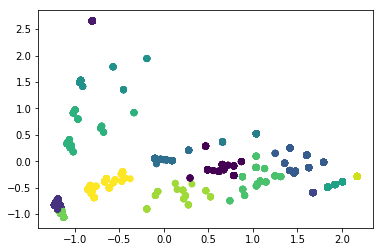

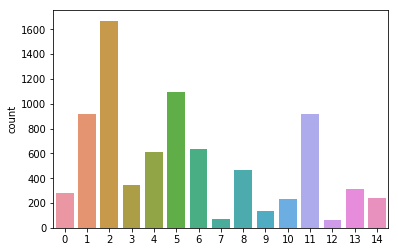

In [126]:
plt.scatter(to_plot[:,0],to_plot[:,1],c=kmeans.labels_)
plt.show()
sns.countplot(kmeans.labels_)

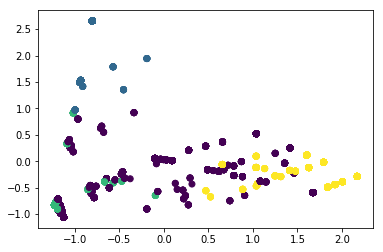

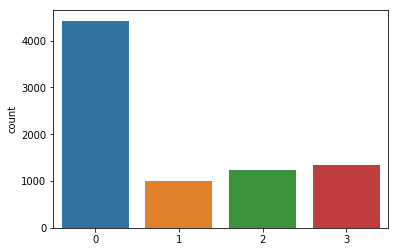

In [82]:
plt.scatter(to_plot[:,0],to_plot[:,1],c=probas_t.argmax(axis=-1))
plt.show()
sns.countplot(probas_t.argmax(axis=-1))

In [31]:
gMixture_Global.alpha_init

array([[[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       ...,

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0.

In [34]:
gMixture_Global.get_alpha()

array([0.9234385 , 0.00141734, 0.00526037, 0.06988384], dtype=float32)

In [14]:
import math
def plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
        divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange):
    def add_plot(aux):
        aux.xticks(M_values)
        aux.xlabel("M change")
        aux.legend()
        #aux.show()
    
    #first some plots
    M_values = range(1,1+len(logL_Mchange))
    
    aux = math.ceil(len(M_values)/3)
    f,axx = plt.subplots(3,aux,figsize=(15,7))
    for m in range(len(M_values)):
        axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
        axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
    f.tight_layout()
    plt.show()

    try:
        plt.figure(figsize=(15,5))
        for m in range(len(M_values)):
            plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
        plt.legend()
        plt.show()
        plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,plot_logL,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    except:
        plt.clf() #clf()
        #plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,logL_Mchange,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence2_Mchange,label="Divergence JS to real T matrixs")
    plt.plot(M_values,divergence1_Mchange,label="Divergence weighted JS to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,accTR_Mchange,label="Acc training")
    plt.plot(M_values,accTE_Mchange,label="Acc val")
    plt.plot(M_values,best_group_acc_Mchange,label="Acc val best group")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0,1)
    plt.show()

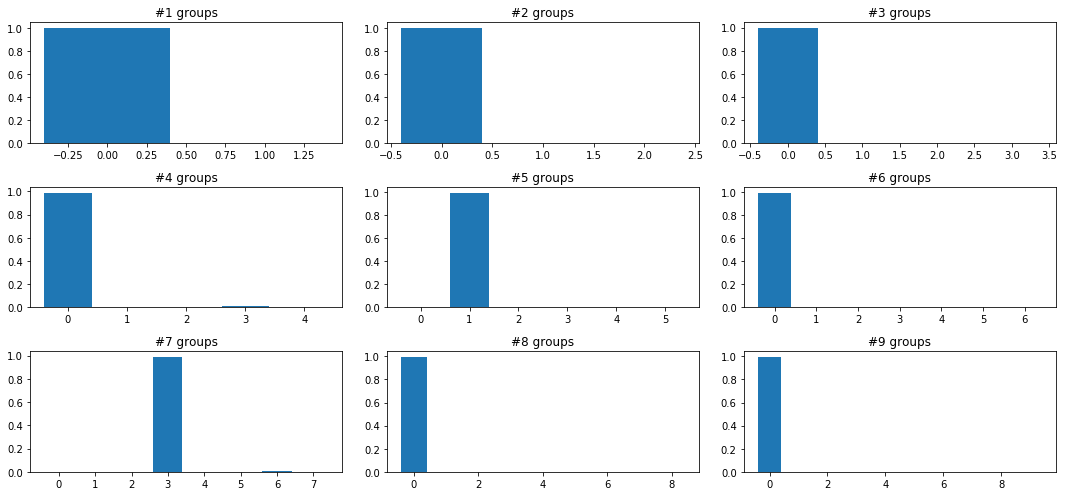

<Figure size 1080x360 with 0 Axes>

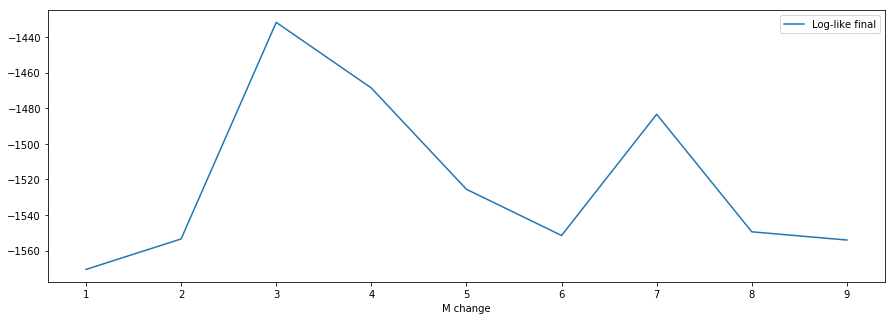

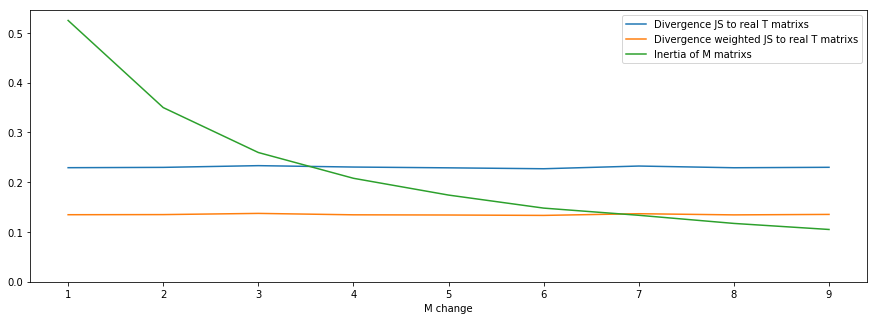

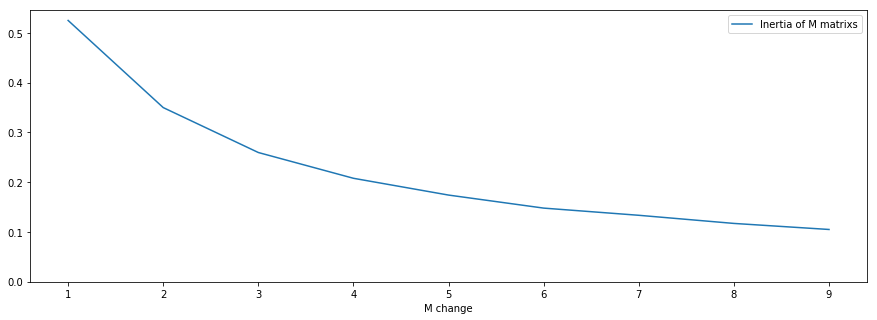

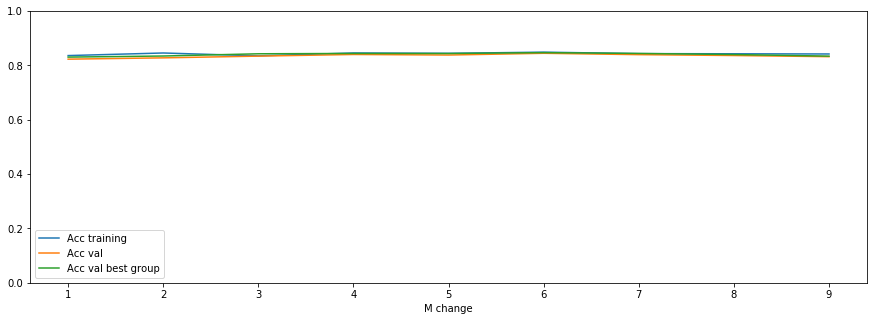

In [15]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [16]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


,#Groups,>=1 annotator,>=2 annotator,Used on annotators,Used on annotators limit >=0.01,Used on annotators limit >=0.05
0,1,1,1,1,1,1
1,2,1,1,1,1,1
2,3,1,1,1,1,1
3,4,1,1,1,1,1
4,5,1,1,1,1,1
5,6,1,1,1,1,1
6,7,1,1,1,1,1
7,8,1,1,1,1,1
8,9,1,1,1,1,1


1 o 3...

In [17]:
M_seted = ??

In [18]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.007303 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36202872 0.16869035]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 3.41 sec)	logL: -3532.364	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2335.253	Tol1: 0.33890	Tol2: 0.57895	Tol3: 0.16369	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2010.102	Tol1: 0.13924	Tol2: 0.16707	Tol3: 0.16888	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1858.473	Tol1: 0.07543	Tol2: 0.10848	Tol3: 0.20389	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1770.794	Tol1: 0.04718	Tol2: 0.07374	Tol3: 0.21931	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1713.365	Tol1: 0.03243	Tol2: 0.04579	Tol3: 0.23125	
Iter 7/50
M step: done,  E step: done //  (in 0.11 s

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [12]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [101]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global       0.979         0.979
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.920875      0.920875
====  ======  ==========  ============


*** Soft-Majority (Train with softMV) ***
Train


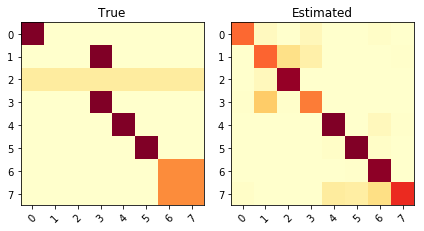

JS divergence: 0.6042	KL divergence: 3.2542


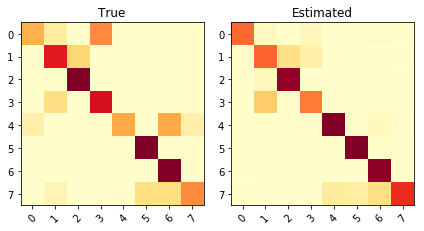

JS divergence: 0.3535	KL divergence: 0.9611


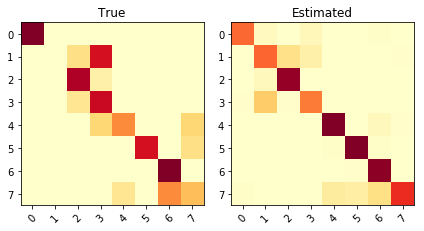

JS divergence: 0.4550	KL divergence: 1.7986


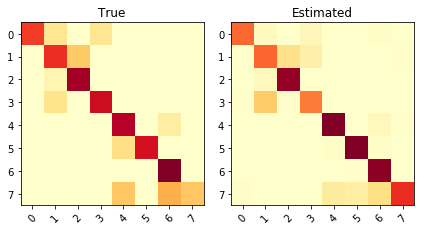

JS divergence: 0.3277	KL divergence: 0.6466


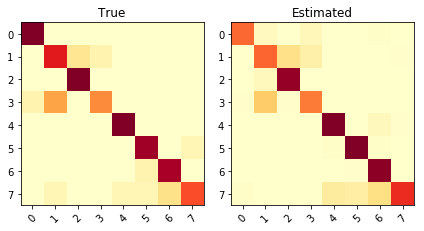

JS divergence: 0.4090	KL divergence: 1.0168


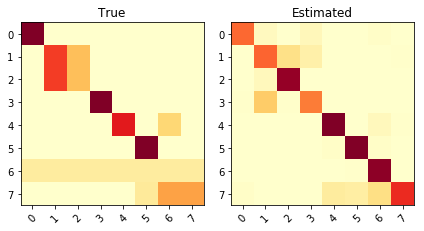

JS divergence: 0.4474	KL divergence: 2.0652


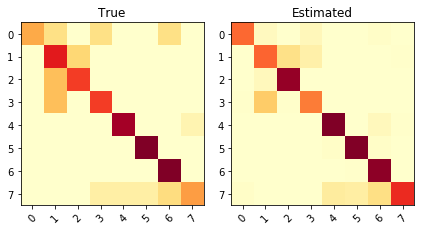

JS divergence: 0.3061	KL divergence: 0.7846


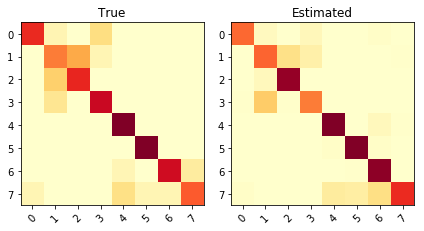

JS divergence: 0.3512	KL divergence: 0.9899


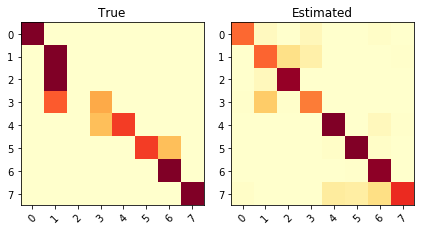

JS divergence: 0.5205	KL divergence: 1.5973


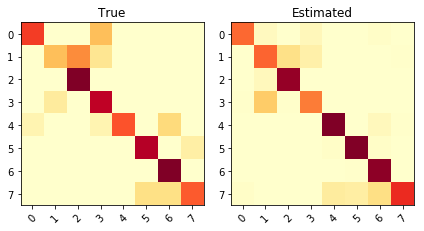

JS divergence: 0.3812	KL divergence: 1.1564


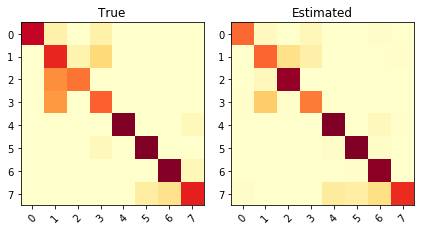

JS divergence: 0.3555	KL divergence: 0.8460


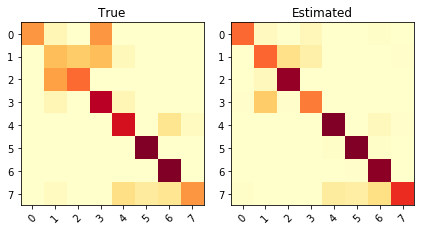

JS divergence: 0.2977	KL divergence: 0.8035


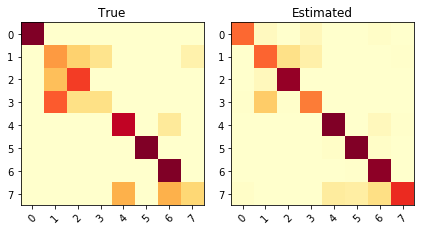

JS divergence: 0.3173	KL divergence: 0.6290


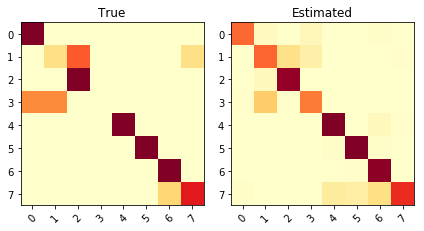

JS divergence: 0.4530	KL divergence: 0.8933


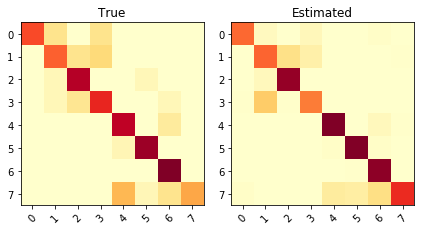

JS divergence: 0.3013	KL divergence: 0.7705
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.827         0.827    2.20961   0.445405     1.13939    0.390029
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.797138      0.797138
====  ======  ==========  ============


In [113]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


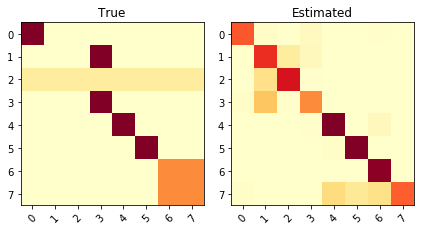

JS divergence: 0.5206	KL divergence: 2.8798


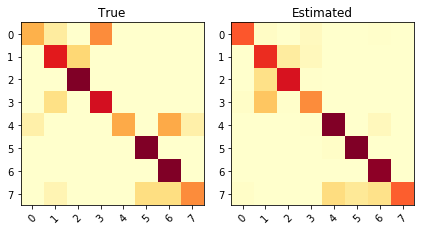

JS divergence: 0.3159	KL divergence: 1.0400


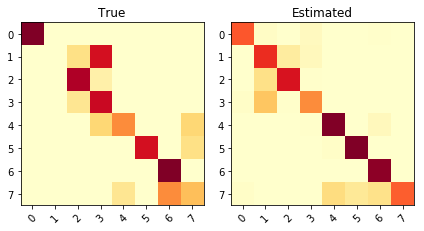

JS divergence: 0.3694	KL divergence: 1.4746


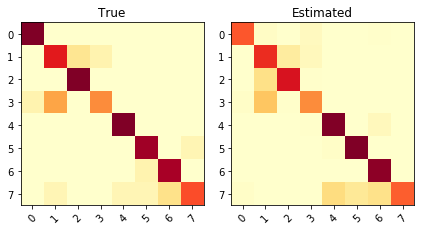

JS divergence: 0.3722	KL divergence: 1.0621


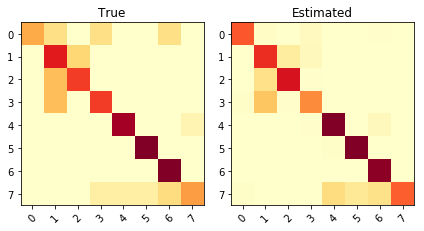

JS divergence: 0.2662	KL divergence: 0.8170


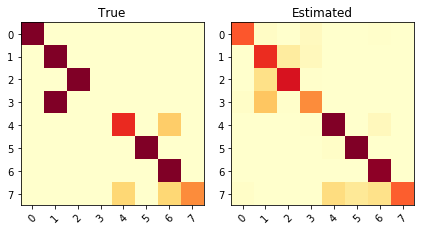

JS divergence: 0.4239	KL divergence: 0.8416


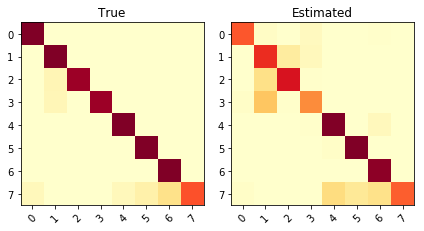

JS divergence: 0.4185	KL divergence: 0.8484


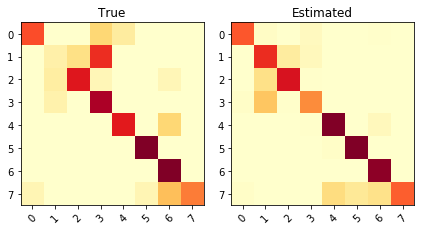

JS divergence: 0.2880	KL divergence: 0.8640


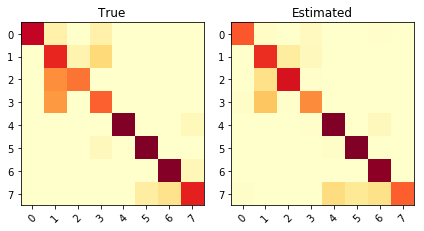

JS divergence: 0.3112	KL divergence: 0.8194


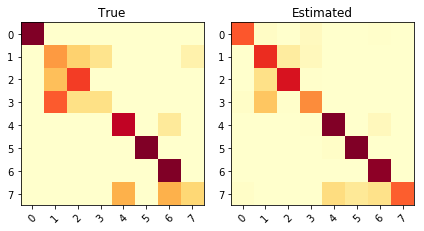

JS divergence: 0.2792	KL divergence: 0.6896


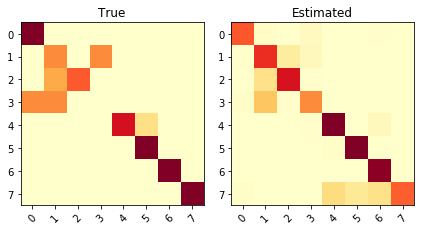

JS divergence: 0.4106	KL divergence: 1.1294


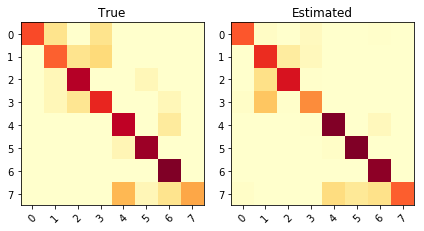

JS divergence: 0.2383	KL divergence: 0.6479


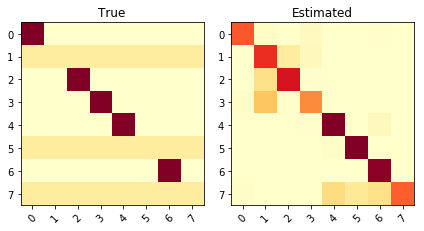

JS divergence: 0.4945	KL divergence: 3.7924


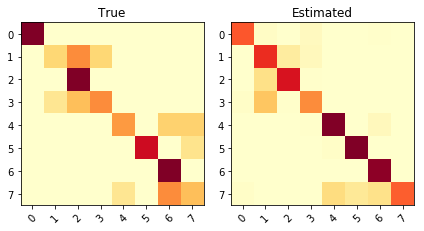

JS divergence: 0.3226	KL divergence: 1.3867


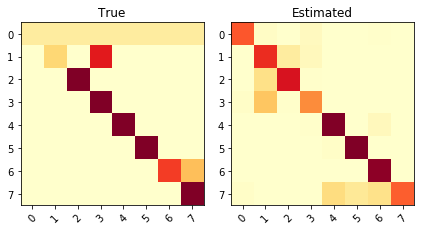

JS divergence: 0.4805	KL divergence: 2.3156
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.812         0.812    2.33873   0.415067     1.16027    0.343895
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.792088      0.792088
====  ======  ==========  ============


In [114]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


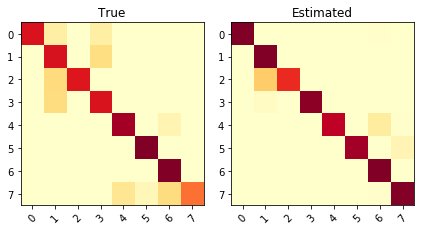

JS divergence: 0.0758	KL divergence: 1.0693


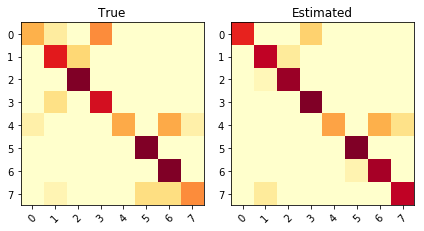

JS divergence: 0.0800	KL divergence: 1.3788


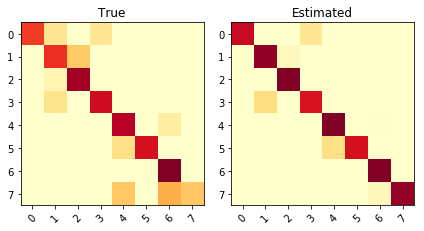

JS divergence: 0.0825	KL divergence: 1.1107


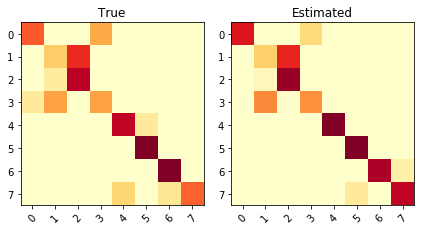

JS divergence: 0.0674	KL divergence: 1.2312


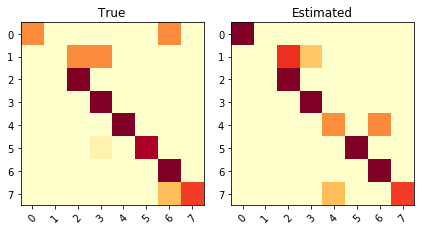

JS divergence: 0.1301	KL divergence: 1.7914


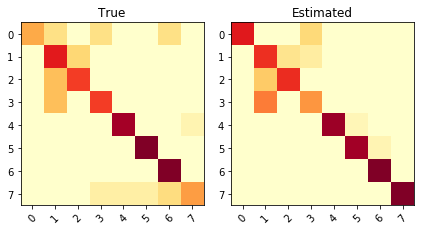

JS divergence: 0.0988	KL divergence: 1.3245


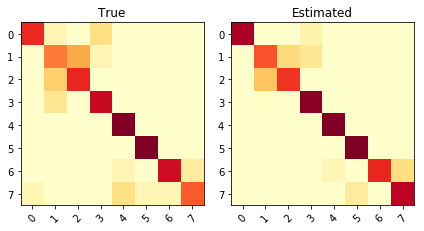

JS divergence: 0.0437	KL divergence: 0.4704


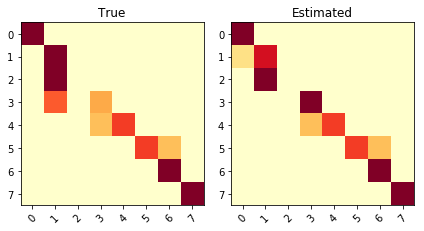

JS divergence: 0.0632	KL divergence: 0.9011


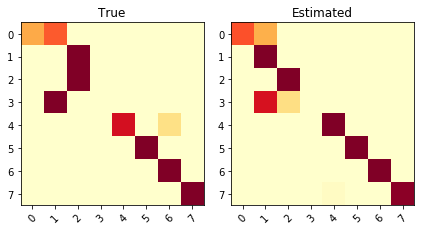

JS divergence: 0.1585	KL divergence: 2.3995


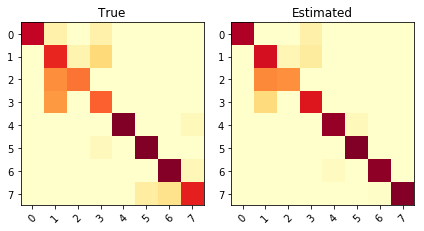

JS divergence: 0.0431	KL divergence: 0.5730


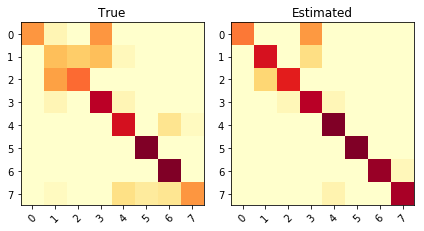

JS divergence: 0.0925	KL divergence: 1.2764


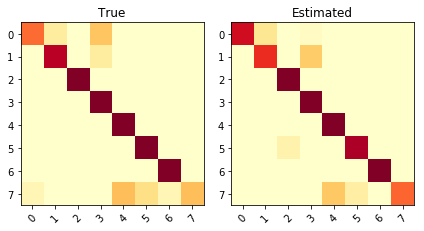

JS divergence: 0.0371	KL divergence: 0.3051


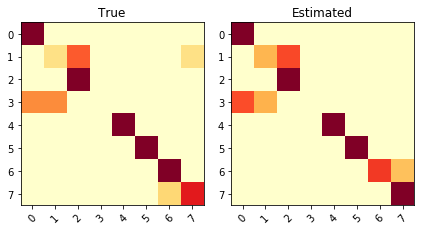

JS divergence: 0.0567	KL divergence: 0.8301


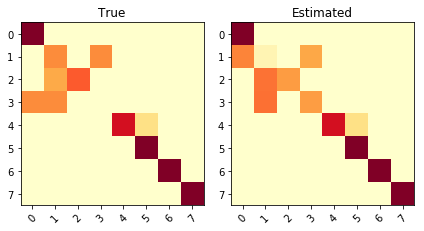

JS divergence: 0.1099	KL divergence: 1.0951


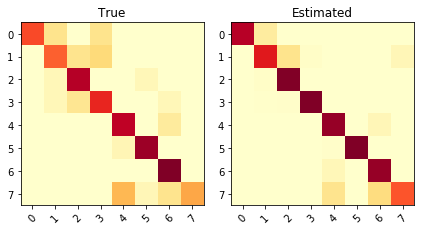

JS divergence: 0.0650	KL divergence: 0.7362
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.851         0.851    1.67215    0.16081     1.08425   0.0850474
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.819865      0.819865
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


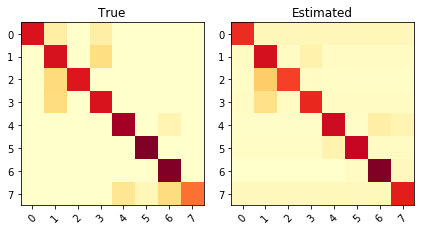

JS divergence: 0.1763	KL divergence: 0.3824


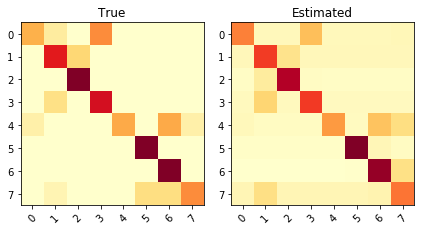

JS divergence: 0.2303	KL divergence: 0.5073


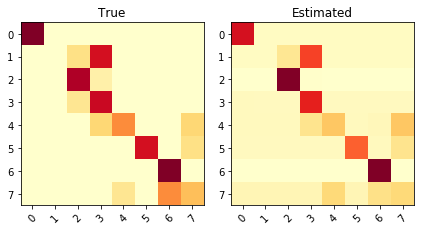

JS divergence: 0.2640	KL divergence: 0.5862


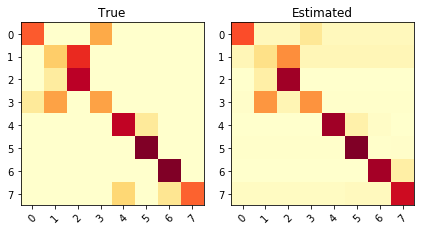

JS divergence: 0.2461	KL divergence: 0.5448


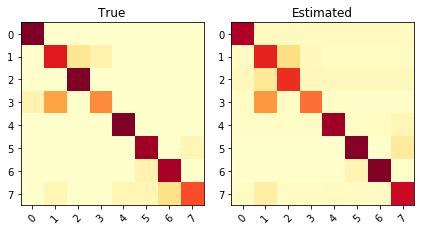

JS divergence: 0.1913	KL divergence: 0.4172


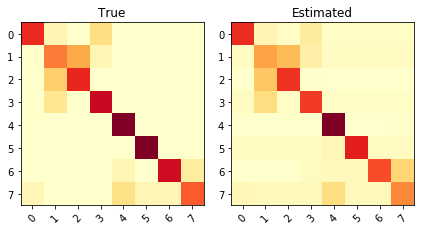

JS divergence: 0.1530	KL divergence: 0.3284


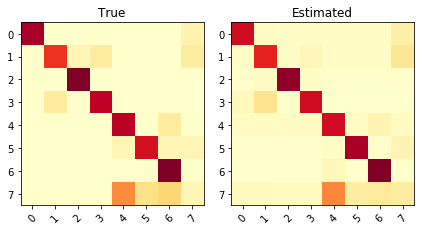

JS divergence: 0.1536	KL divergence: 0.3270


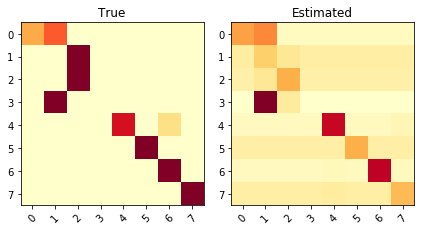

JS divergence: 0.4771	KL divergence: 1.2062


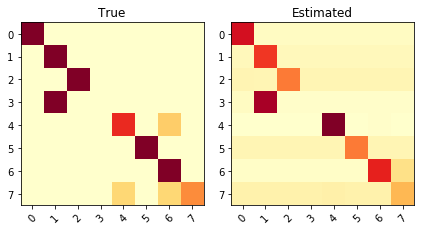

JS divergence: 0.3994	KL divergence: 0.9392


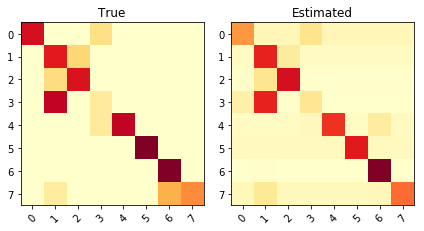

JS divergence: 0.2543	KL divergence: 0.5691


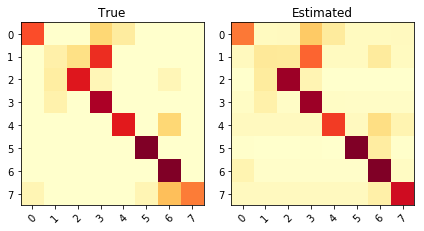

JS divergence: 0.1883	KL divergence: 0.4109


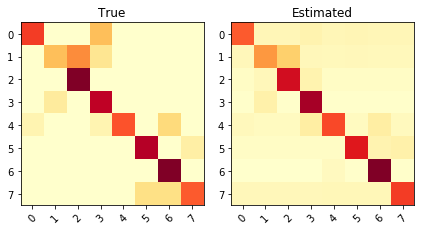

JS divergence: 0.2042	KL divergence: 0.4517


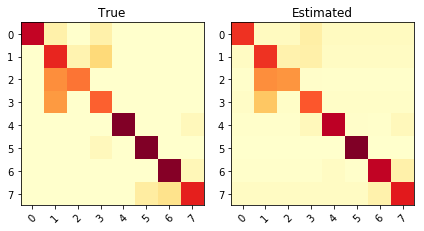

JS divergence: 0.1352	KL divergence: 0.2877


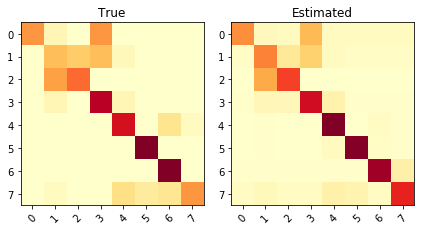

JS divergence: 0.1176	KL divergence: 0.2601


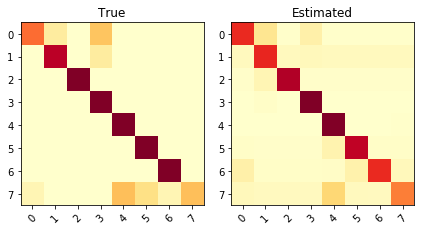

JS divergence: 0.2167	KL divergence: 0.4764
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global       0.854         0.854   0.707193     0.2941    0.541393    0.237015    0.0649323     0.0557519
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.83947                1.1736               

In [13]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)